<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/sythetic_analysis_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
!pip install tensorflow_text

In [170]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA
from scipy.special import softmax

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/')
import seq2seq_files.toy_functions as toy
import seq2seq_files.scan_functions as scan
import seq2seq_files.train_and_build as train_build
import seq2seq_files.analysis as analysis

In [171]:
# Reload modules if changes have been made to them
from importlib import reload

reload(toy)
reload(scan)
reload(train_build)
reload(analysis)

<module 'seq2seq_files.analysis' from '/content/drive/My Drive/ml_research/fixedpoints_nlp/seq2seq_files/analysis.py'>

In [172]:
# Skips any tests and just runs function definitions
run_tests = False

state_colors = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'r', 'gray', 'g', 'navy', 
                'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']
state_colors_light = ['salmon', 'limegreen', 'cornflowerblue', 'bisque', 'plum', 'pink', 'tomato', 'gray', 'lightgray', 'g', 'b', 
                      'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']

# Synthetic Data

#### Toy Data Tests

In [173]:
# Various tests/confirmations of phrase generation
if run_tests:

  toy_params = {
    'phrase_length': 5,
    'var_length': False,
    'min_phrase_len': 2,
    'base_words': 3,
    'loss_type': 'XE',
    'rules': [], #prev0
    'pad_dim': True,
    'emb_dim': 20,
    'reverse_out': True,
  }

  toy_params['in_words'], toy_params['in_words_pp'], toy_params['phrase_words'] = toy.generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['out_words_pp'], toy_params['translations'] = toy.generateOutputWordBank(toy_params)

  print('Input words:', toy_params['in_words'])
  print('Input phrase words:', toy_params['phrase_words'])
  print('Output words:', toy_params['out_words'])
  print('Translation dic:', toy_params['translations'])

  # Makes five phrases and reports scores
  print('Three phrases and translations:')
  for i in range(3):
    toy_phrase = toy.make_toy_phrase(toy_params)
    print('Input phrase:', toy_phrase)
    out_phrase = toy.translate_toy_phrase(toy_phrase, toy_params)
    print('Output phrase:', out_phrase)

  out_phrase, in_phrase, out_phrase_tensor, in_phrase_tensor, out_target_mask, in_target_mask = toy.randomTrainingExample(toy_params)
  print('Input phrase:', in_phrase)
  print('Input phrase tensor:', in_phrase_tensor)
  print('Input target mask:', in_target_mask)
  print('Output phrase:', out_phrase)
  print('Output phrase tensor:', out_phrase_tensor)
  print('Out target mask:', out_target_mask)

In [174]:
def multiply_scan(raw_in_phrases, raw_out_phrases, scan_params):
    """ Effectively creates additional copies of all words in SCAN, this makes it easy to scale up vocabulary 
    Since this can significantly increase the number of phrases of a given structure, raw_in_phrases and raw_out_phrases
    are output as a NESTED list now, separated by sentence structure.
    
    """
    
    def scan_mult_defaults(scan_params):
        """ Sets default values for multiplying SCAN """
        in_words = scan_params['in_words']
        base_translations = {}

        if  'run' in in_words:
            if 'run_count' not in scan_params: scan_params['run_count'] = 1
            base_translations['run'] = 'I_RUN'
        if  'left' in in_words:
            if 'left_count' not in scan_params: scan_params['left_count'] = 1
            base_translations['left'] = 'I_TURN_LEFT'
        if  'and' in in_words and 'and_count' not in scan_params: scan_params['and_count'] = 1
        if  'after' in in_words and 'after_count' not in scan_params: scan_params['after_count'] = 1

        if  'twice' in in_words and 'twice_count' not in scan_params: scan_params['twice_count'] = 1
        if  'thrice' in in_words and 'thrice_count' not in scan_params: scan_params['thrice_count'] = 1

        if  'opposite' in in_words and 'opposite_count' not in scan_params: scan_params['opposite_count'] = 1

        return scan_params, base_translations

    scan_params, base_translations = scan_mult_defaults(scan_params)

    mult_words = {}
    translations = {}
    new_in_words = []
    new_out_words = []
    for word in scan_params['in_words']:
        if word + '_count' not in scan_params:
            raise ValueError(f'{word}_count not found.')
        mult_words[word] = [word + f'{i}' for i in range(scan_params[word + '_count'])]
        new_in_words.extend([word + f'{i}' for i in range(scan_params[word + '_count'])])
        if word in ('run', 'left'): # words with one-to-one translations
            for idx in range(scan_params[word + '_count']):
                translations[word + f'{idx}'] = base_translations[word] + f'{idx}'
                new_out_words.append(base_translations[word] + f'{idx}')

    new_in_phrases = []
    new_out_phrases = []
    n_phrase = 0
    total_phrases = 0

    for phrase, out_phrase in zip(raw_in_phrases, raw_out_phrases):
        in_phrases_struct = []
        out_phrases_struct = []

        mult_count = np.zeros((len(phrase)))
        for word_idx, word in enumerate(phrase):
            mult_count[word_idx] = scan_params[word + '_count']
        
        n_phrase += np.prod(mult_count)
        mult_idxs = np.zeros((len(phrase)), dtype=np.int32)
        mult_idxs[0] = -1 # Makes it so it ouputs the all zero phrase

        first_mult = True # On first run, checks to see if translation rules are working correctly 

        while not (mult_idxs + 1 == mult_count).all(): # Enumerates all possible phrases of a given structure
             # Builds new phrase
            update_idx = 0
            # Sequentially goes through all possible mult_idx combinations, starting at first index
            while mult_idxs[update_idx] ==  mult_count[update_idx] - 1: 
                # Index is at a maximum, so goes to next and reset
                mult_idxs[update_idx] = 0
                update_idx += 1
                # if update_idx == len(phrase): break # Reached end of phrase
            mult_idxs[update_idx] += 1
            new_phrase = []
            for word_idx, word in enumerate(phrase):
                new_phrase.append(mult_words[word][mult_idxs[word_idx]])
            in_phrases_struct.append(new_phrase)
            total_phrases += 1

            # Translates new phrase (using old phrase as schematic)
            new_out_phrase = []
            after_idx = 0
            opposite_flag = False
            for word_idx, word in enumerate(phrase):
                if word == 'and': continue
                elif word == 'run': 
                    new_out_phrase.append(translations[new_phrase[word_idx]])
                elif word == 'left': # Inserts right before last word (which will be modifying verb)
                    new_out_phrase.insert(-1, translations[new_phrase[word_idx]])
                    if opposite_flag: # Inserts another if opposite flag is triggered
                        new_out_phrase.insert(-1, translations[new_phrase[word_idx]])
                        opposite_flag = False
                elif word == 'twice':
                    new_out_phrase.append(new_out_phrase[-1])
                elif word == 'thrice':
                    new_out_phrase.append(new_out_phrase[-1])
                    new_out_phrase.append(new_out_phrase[-1])
                elif word == 'after':
                    after_idx = len(new_out_phrase)
                elif word == 'opposite':
                    opposite_flag = True
            if after_idx != 0: # Flips the phrase at the occurence of after
                new_out_phrase = new_out_phrase[after_idx:] + new_out_phrase[:after_idx]
            out_phrases_struct.append(new_out_phrase)

            if first_mult: # Checks to see if translation rules are working correctly for phrase structure
                first_mult = False
                test_out_phrase = [word[:-1] for word in new_out_phrase] # Removes numbers
                assert np.array(test_out_phrase == out_phrase).all()
        new_in_phrases.append(in_phrases_struct)
        new_out_phrases.append(out_phrases_struct)

    print(f'Total new in_phrases: {total_phrases} (theory: {n_phrase})')

    print('New input words:', new_in_words)
    print('New output words:', new_out_words)

    scan_params['in_words'] = new_in_words
    scan_params['out_words'] = new_out_words

    return new_in_phrases, new_out_phrases, scan_params

#### Set SCAN params

Filtering out left twice occurences.
Before phrases: 42
After phrases: 20
Kept 20/20916 phrases. // Max in: 7 // Max out: 6 (pre-pad)
Multiplying SCAN phrases. Before phrases: 20
Total new in_phrases: 37744 (theory: 37744.0)
New input words: ['run0', 'run1', 'run2', 'run3', 'run4', 'run5', 'run6', 'run7', 'left0', 'left1', 'left2', 'left3', 'and0', 'and1', 'and2', 'twice0', 'opposite0', 'opposite1']
New output words: ['I_RUN0', 'I_RUN1', 'I_RUN2', 'I_RUN3', 'I_RUN4', 'I_RUN5', 'I_RUN6', 'I_RUN7', 'I_TURN_LEFT0', 'I_TURN_LEFT1', 'I_TURN_LEFT2', 'I_TURN_LEFT3']
SCAN data generated in: 0.09 sec.
Input words: ['run0', 'run1', 'run2', 'run3', 'run4', 'run5', 'run6', 'run7', 'left0', 'left1', 'left2', 'left3', 'and0', 'and1', 'and2', 'twice0', 'opposite0', 'opposite1', '<.>', '<pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<

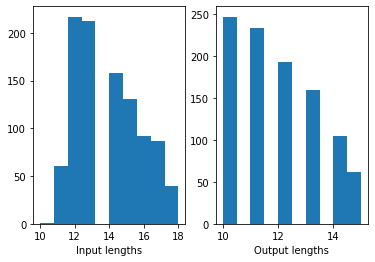

In [175]:
# Filter raw SCAN dataset and set toy parameters

# path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/tasks.txt'
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/tasks_mod1.txt'
text_data = scan.read_and_split_file(path)

# all_in_words = ['run', 'walk', 'look', 'jump', 'exercise', 'left', 'right', 'twice', 'opposite', 'thrice', 'turn', 'around', 'and', 'after']
# all_out_words = ['I_RUN', 'I_WALK', 'I_LOOK', 'I_JUMP', 'I_EXER1', 'I_EXER2', 'I_TURN_LEFT', 'I_TURN_RIGHT']

scan_params = {
    'in_words': ['run', 'left', 'and', 'twice', 'opposite',], 
    'out_words': ['I_RUN', 'I_TURN_LEFT',],
#   'in_words': ['run', 'walk', 'jump', 'left', 'right', 'and', 'twice', 'after'], 
#   'out_words': ['I_RUN', 'I_WALK', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_RIGHT'],
    'extend_scan': True,
    'min_out_len': 10,
    'max_out_len': 15,
    'max_in_len': 27,
    'trials': 1000,
    'plot_lens': True,
    'periods': True,
    'pad_dim': True,
    'emb_dim': 50,

    'multiply': True,
    'run_count': 8,
    'twice_count': 1,
    'and_count': 3,
    'left_count': 4,
    'opposite_count': 2,
    'after_count': 1,
}

# Reads in phrases from text_data and filters phrases to keep only those that have words in input_words
raw_in_phrases, raw_out_phrases = scan.read_and_filter_scan(text_data, scan_params['in_words'])

# Filters out `left twice' occurences
raw_in_phrases, raw_out_phrases = scan.filter_out_left_twice(raw_in_phrases, raw_out_phrases, scan_params)

max_in = max(list(map(len, raw_in_phrases)))
max_out = max(list(map(len, raw_out_phrases)))

print(f'Kept {len(raw_in_phrases)}/{len(text_data)} phrases. // Max in: {max_in} // Max out: {max_out} (pre-pad)')

# Multiplies scan
if scan_params['multiply']:
    print(f'Multiplying SCAN phrases. Before phrases: {len(raw_in_phrases)}')
    raw_in_phrases, raw_out_phrases, scan_params = multiply_scan(raw_in_phrases, raw_out_phrases, scan_params)
    
scan_data, scan_params = scan.generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=scan_params['trials'])
print('Input words:', scan_params['in_words'])
print('Output words:', scan_params['out_words'])

max_in = scan_data['inputs'].shape[1]
max_out = scan_data['labels'].shape[1]
print(f'Max in: {max_in} // Max out: {max_out} (post-pad)')

print('Scan input shape:', scan_data['inputs'].shape)
print('Scan labels shape:', scan_data['labels'].shape)
print('Scan in indexs shape:', scan_data['in_index'].shape)
print('Scan out indexs shape:', scan_data['out_index'].shape)

scan_params['plot_lens'] = False

# Sets toy parameters to match SCAN data so same code can be used below
toy_params = {
  'phrase_length': scan_params['max_in_len'],
  'var_length': True,
  'loss_type': 'XE',
  'in_words': scan_params['in_words'],
  'out_words': scan_params['out_words'],
  'scan_params': scan_params,
  'in_words_pp': scan_params['in_words_pp'],
  'out_words_pp': scan_params['out_words_pp'],
}


In [176]:
if run_tests:

  scan_params = {
    'in_words': ['run', 'walk', 'jump',],
    'out_words': ['I_RUN', 'I_WALK', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_RIGHT'],
    'extend_scan': True,
    'min_out_len': 25,
    'max_out_len': 30,
    'max_in_len': 31,
    'trials': 100,
    'plot_lens': True,
    'periods': False,
    'pad_dim': False
  }

  # Reads in phrases from text_data and filters phrases to keep only those that have words in input_words
  raw_in_phrases, raw_out_phrases = scan.read_and_filter_scan(text_data, scan_params['in_words'])

  max_in = max(list(map(len, raw_in_phrases)))
  max_out = max(list(map(len, raw_out_phrases)))

  print(f'Kept {len(raw_in_phrases)}/{len(text_data)} phrases. // Max in: {max_in} // Max out: {max_out} (pre-pad)')

  scan_data, scan_params = scan.generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=scan_params['trials'])

  max_in = scan_data['inputs'].shape[1]
  max_out = scan_data['labels'].shape[1]
  print('Total phrases:', scan_data['inputs'].shape[0], f'// Max in: {max_in} // Max out: {max_out} (post-pad)')

# Train and Build Network

#### Architecture Tests

In [177]:
if run_tests:

  seed = 342343
  prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

  data_type = 'toy'

  ########## Toy data parameters ##########
  if data_type == 'toy':
    toy_params = {
      'phrase_length': 10,
      'base_words': 3,
      'var_length': True,
      'min_phrase_len': 5,
      'loss_type': 'XE',
      'pad_dim': False,
      'emb_dim': 10,
      'rules': [None,] # prev0
    }

    toy_params['in_words'], toy_params['in_words_pp'], toy_params['phrase_words'] = toy.generateInputWordBank(toy_params)
    toy_params['out_words'], toy_params['out_words_pp'], toy_params['translations'] = toy.generateOutputWordBank(toy_params)

  ########## RNN hyperparameters ##########
  rnn_specs = {
    'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
    'arch': 'enc_dec_attmh',                          # Type of architecture
    'pos_enc_params': {'pos_enc': True, 'time_scale': 25, 'amplitude': 1.0}, 
    'shorts': (),
    'zero_rec': True,
    'zero_attention': False,
    'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
    'hidden_size': 128,                              # Number of units in the RNN
    'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
    'ro_bias': True,                                 # Include a bias with the readout
    'var_length': toy_params['var_length'],
    'ro_simplex_init': False,
    'phrase_length': toy_params['phrase_length'],     # Needed to build the attention matrix
    'attn_heads': 2,
  }
  if rnn_specs['var_length']: rnn_specs['in_eos_idx'] = toy_params['in_words'].index('<pad>')

  ########## Train hyperparameters ##########

  train_params = {
    'batch_size': 2,                     # How many examples in each batch
    'num_batchs': 1,                    # Total number of batches to train on.
    'l2reg': 1e-5,           # amount of L2 regularization on the weights
  }

  train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
  train_params, toy_params, rnn_specs = train_build.default_params(train_params, toy_params, rnn_specs)

  if rnn_specs['pos_enc_params']['pos_enc']:
    print('Adding random positional encoding rotation')
    rnn_specs['pos_enc_params']['rot'] = train_build.rvs(rnn_specs['input_size'])
  # Generate the data to run through the RNN
  if data_type == 'toy':
    syn_data = train_build.generate_data(train_params['train_set_size'], toy_params, rnn_specs)
  else:
    syn_data, _ = train_build.generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=train_params['train_set_size'])
  
  rnn_specs['out_len'] = syn_data['labels'].shape[1]

  print('Vocab:', toy_params['in_words'])
  print('Sythetic in lengths:', syn_data['in_index'])
  print('Sythetic out lengths:', syn_data['out_index'])

  # Initialize the optimizer.
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = train_build.build_rnn(rnn_specs)
  enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
  dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
  output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

  if rnn_specs['arch'] in ('enc_dec_att', 'enc_dec_attl', 'enc_dec_attmh'):
    rnn_params, rnn_params_dec, att_params, readout_params = initial_params
  elif rnn_specs['arch'] in ('enc_dec', 'enc_dec_short', 'enc_dec_atth'):
    rnn_params, rnn_params_dec, readout_params = initial_params
  else:
    rnn_params, readout_params = initial_params

  # cell = build_cell(rnn_specs)
  out_logits, attn_matrix = apply_fun(initial_params, syn_data['inputs'], syn_data['in_index'], return_att_matrix=True)

  print('Output logits shape:', out_logits.shape)
  print('Output logits:', out_logits)
  # print('Output logits:', out_logits[0, :5, :2])
  # print('Output logits:', out_logits[1, :5, :2])
  print('Output labels:', syn_data['labels'])

First time step: [ 0.12728995  0.43170977  0.47508404 -1.6039227  -1.0269896  -0.69033253
 -0.6736771 ]


Text(0, 0.5, 'Sequence Index')

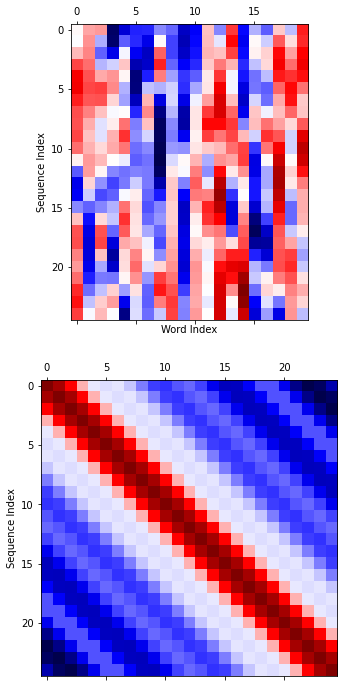

In [178]:
seq_len_test = 25
word_dims = 20
test_seq = np.zeros((5, seq_len_test, word_dims))
scale = 50
amp = 1
rand_seq_offset = False
offsets = np.zeros((test_seq.shape[0]))

# random_pos_enc_rot = np.identity(word_dims) 
random_pos_enc_rot = train_build.rvs(word_dims) 
pos_enc_inputs = test_seq, scale, amp, random_pos_enc_rot, rand_seq_offset, offsets
pos_enc = train_build.positional_encoding(pos_enc_inputs)

print('First time step:', pos_enc[0,0,:7])

pos_enc_dots = np.zeros((seq_len_test, seq_len_test))
for i in range(seq_len_test):
  for j in range(seq_len_test):
    pos_enc_dots[i,j] = np.dot(pos_enc[0,i], pos_enc[0,j])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.matshow(pos_enc[0], cmap=plt.cm.seismic)
ax2.matshow(pos_enc_dots, cmap=plt.cm.seismic)

ax1.set_ylabel('Sequence Index')
ax1.set_xlabel('Word Index')

ax2.set_ylabel('Sequence Index')
ax2.set_ylabel('Sequence Index')

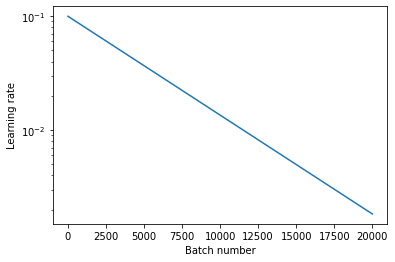

In [179]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9998     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                             decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [ ]:
print('Using random seed.')
seed = np.random.randint(0, 999999) #342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

data_type = 'scan' # toy or scan

if data_type == 'toy':
    ########## Toy data parameters ##########
    toy_params = {
        'phrase_length': 20,    # INPUT phrase length (output phrase length could be different)
        'base_words': 10,
        'var_length': True,
        'min_phrase_len': 15,
        'pad_dim': True,
        'emb_dim': 30,
    }

    (toy_params['in_words'], toy_params['in_words_pp'], toy_params['phrase_words']) = toy.generateInputWordBank(toy_params)
    toy_params['out_words'], toy_params['out_words_pp'], toy_params['translations'] = toy.generateOutputWordBank(toy_params)
 
########## RNN hyperparameters ##########
rnn_specs = {
    'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
    'arch': 'enc_dec_attmh',                  # Architecture, supports  'enc_dec_atth', 'enc_dec_atthl', 'enc_dec_attmh',
    'pos_enc_params': {'pos_enc': True, 'time_scale': 50.0, 'amplitude': 1.0, 'rand_seq_offset': False},
    'zero_rec': True,
    'zero_attention': False,
    'qk_size': 16,
    'v_size': 16,
    'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
    'hidden_size': 256,                              # Number of units in the RNN
    'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
    'ro_bias': False,                                # Include a bias with the readout
    'var_length': toy_params['var_length'],
    'teacher_force': True,                           # Pass targets in as inputs
    'attn_heads': 16,
}
if rnn_specs['var_length']: rnn_specs['in_eos_idx'] = toy_params['in_words'].index('<pad>')

########## Train hyperparameters ##########

train_params = {
    'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
    'l2reg': 1e-4,           # amount of L2 regularization on the weights

    'init_lr': 0.1,                     # initial learning rate
    'decay_factor': 0.9997,             # decay the learning rate this much
    'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
    'adam_b2': 0.99,
    'adam_eps': 1e-1,

    'batch_size': 64,                     # How many examples in each batch
    'num_batchs': 1000,                    # Total number of batches to train on.
    'print_every': 100,                     # Print training informatino every so often

    'n_datasets': 5,                           # Number of new train sets to generate total (this is slow)
    'epochs': 2,                               # How many times to go through each train set completely
    'test_set_size': 200,
}

train_params['decay_fun'] = optimizers.exponential_decay(train_params['init_lr'], decay_steps=1, 
                                                         decay_rate=train_params['decay_factor'])
train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
# Sets default parameters if they weren't set above
train_params, toy_params, rnn_specs = train_build.default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('# Input words (with dim pad):', len(toy_params['in_words']), '// (without):', len(toy_params['in_words_pp']), '// Input words:', toy_params['in_words_pp'])
print('# Output words (with dim pad):', len(toy_params['out_words']), '// (without):', len(toy_params['out_words_pp']), '// Output words:', toy_params['out_words_pp'])
print('Architecture:', rnn_specs['arch'])

# rnn_specs['pos_enc_params']['rot'] = np.identity(rnn_specs['input_size']) 
if rnn_specs['pos_enc_params']['pos_enc']:
    rnn_specs['pos_enc_params']['rot'] = train_build.rvs(rnn_specs['input_size']) 

save_data = True
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/mh16_ao_unitype_run8tand3left4twice1opp2_10to15_l2is1e-4.pickle'
save_data = train_build.override_data(path, save_data)

# Initialize the optimizer.  Please see jax/experimental/optimizers.py
init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = train_build.build_rnn(rnn_specs)
enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
opt_state, step_fun = train_build.build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

init_opt, update_opt, get_params = opt

train_params['train_losses'] = []
train_params['global_step'] = 0
train_params['total_steps'] = 0

# Generate synthetic data and run training on said data
if data_type == 'toy':
    opt_state, train_params = train_build.train_on_synthetic_data(opt_state, step_fun, get_params, accuracy_fun, train_params, toy_params, rnn_specs)
elif data_type == 'scan':
    raw_phrases = raw_in_phrases, raw_out_phrases
    opt_state, train_params = train_build.train_on_scan_data(scan_data, opt_state, step_fun, get_params, accuracy_fun, train_params, toy_params, rnn_specs, raw_phrases)

train_params.pop('decay_fun') # Can't pickle with decay fun
train_build.save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params, save_loss=True, )

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
if rnn_specs['arch'] in ('enc_dec_att', 'enc_dec_attl', 'enc_dec_attmh'):
    rnn_params, rnn_params_dec, att_params, readout_params = final_params
elif rnn_specs['arch'] in ('enc_dec', 'enc_dec_short', 'enc_dec_atth'):
    rnn_params, rnn_params_dec, readout_params = final_params
else:
    rnn_params, readout_params = final_params

Using random seed.
# Input words (with dim pad): 50 // (without): 20 // Input words: ['run0', 'run1', 'run2', 'run3', 'run4', 'run5', 'run6', 'run7', 'left0', 'left1', 'left2', 'left3', 'and0', 'and1', 'and2', 'twice0', 'opposite0', 'opposite1', '<.>', '<pad>']
# Output words (with dim pad): 50 // (without): 14 // Output words: ['I_RUN0', 'I_RUN1', 'I_RUN2', 'I_RUN3', 'I_RUN4', 'I_RUN5', 'I_RUN6', 'I_RUN7', 'I_TURN_LEFT0', 'I_TURN_LEFT1', 'I_TURN_LEFT2', 'I_TURN_LEFT3', '<.>', '<pad>']
Architecture: enc_dec_attmh
SCAN data generated in: 4.23 sec.
SCAN data generated in: 0.02 sec.
Using targets as decoder input
Using targets as decoder input
Using targets as decoder input
Step 100, step size: 0.09707, phrase acc 0.0000, word acc 0.3597, avg training loss 2.4203
Step 200, step size: 0.09420, phrase acc 0.0000, word acc 0.4406, avg training loss 2.1631
Step 300, step size: 0.09142, phrase acc 0.0000, word acc 0.5444, avg training loss 2.0204
Step 400, step size: 0.08872, phrase acc 0.0000

In [ ]:
# Save the network
path =  '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/vec_toy_3words_15to20_l2is1e-4_2.pickle'

if 'decay_fun' in train_params: train_params.pop('decay_fun')

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

In [17]:
# Loads network
# path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aed_toy_3words_55to60_l2is1e-5.pickle'
# path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aed_toy_3words_n256_notf_55to60_l2is1e-5.pickle'
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/mh8_ao_unitype_run8tand3left4twice1opp2_10to15_l2is1e-4.pickle'
# path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/mh2_ao_toy_3word_15to20_l2is5e-4_2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)
 
if rnn_specs['arch'] in ('enc_dec_atth'):
    rnn_params, rnn_params_dec, readout_params = params_loaded
if rnn_specs['arch'] in ('enc_dec_attl', 'enc_dec_attmh'):
    rnn_params, rnn_params_dec, att_params, readout_params = params_loaded
final_params = params_loaded
train_params, toy_params, rnn_specs = train_build.default_params(train_params, toy_params, rnn_specs)
data_type = 'scan'

print('Data Loaded: data type:', data_type)

Data Loaded: data type: scan


Text(0, 0.5, 'Train Loss')

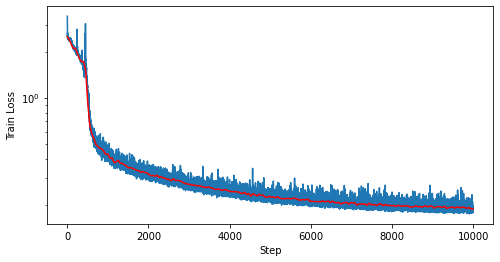

In [103]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]

plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [104]:
# Get RNN hidden states in response to a test batch.
n_trials = 1000
eos_idx = toy_params['in_words'].index('<pad>') if toy_params['var_length'] else 0 # assumes eos is last word in vocab

if rnn_specs['pos_enc_params']['rand_seq_offset']:
    print('Turning random seq offset off.')
    rnn_specs['pos_enc_params']['rand_seq_offset'] = False

if rnn_specs['teacher_force']:
    print('Turning teacher forcing off.')
    rnn_specs['teacher_force'] = False

_, apply_fun, _, _, accuracy_fun = train_build.build_rnn(rnn_specs)
  
if data_type == 'toy':
    hs_data = train_build.generate_data(n_trials, toy_params, rnn_specs)
elif data_type == 'scan':
    scan_data, _ = scan.generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=n_trials)
    hs_data =  {
        'inputs': scan_data['inputs'],
        'labels': scan_data['labels'],
        'in_index': scan_data['in_index'],
        'out_index': scan_data['out_index'],
    }

phrase_acc, word_acc = accuracy_fun(final_params, hs_data)
print('******** Test Acc:', np.mean(phrase_acc), 'Word Acc:', np.mean(word_acc), '********')

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

rnn_apply, attn_apply, ro_apply = analysis.build_applies(final_params, rnn_specs)
# cell, _, _ = analysis.build_cell(rnn_specs)
# cell_dec, attn_apply, readout_apply = analysis.build_cell(rnn_specs)
# cells = cell, cell_dec
# raw_logits, raw_hs  = analysis.rnn_states(cells, attn_apply, readout_apply, hs_data, final_params, rnn_specs, return_hidden=True)
raw_logits, raw_hs = apply_fun(final_params, hs_data['inputs'], hs_data['in_index'], targets=hs_data['labels'], returns={'hidden'})
#### Finds decoder input values ####
hs_data['dec_inputs'] = np.zeros((n_trials, dec_len), dtype=np.int32)
for logits, idx in zip(raw_logits, range(n_trials)):
    rolled_logits = np.roll(np.argmax(logits, axis=1), shift=1)
    rolled_logits[0] = len(toy_params['out_words_pp']) # Assigns <BoS> to first unused index
    hs_data['dec_inputs'][idx] = rolled_logits

# Creates special inputs to get outputs from just positional encoding
    # First (rnn_specs['input_size']) of these will be all a given input with '<pad>' at end
    # idx -2 will be average input with '<pad>' at end
    # idx -1 will be no input (with no pad)
special_inputs = np.zeros((2 + rnn_specs['input_size'],) + hs_data['inputs'][0].shape)
for i in range(rnn_specs['input_size']): # Creates an input that is one-hot in same position
    special_inputs[i, :-1, i] = np.ones((hs_data['inputs'][0].shape[0]-1))
special_inputs[-2, :-1, :] = 1/rnn_specs['input_size'] * np.ones((hs_data['inputs'][0].shape[0]-1, hs_data['inputs'][0].shape[1])) # average input
special_inputs[:-1, -1, eos_idx] =  np.ones((1 + rnn_specs['input_size']))
special_data =  {
    'inputs': special_inputs,
    'labels': jnp.zeros((special_inputs.shape[0],) + hs_data['labels'][0].shape), # These aren't used
    'in_index': jnp.asarray([np.max(hs_data['in_index']) for _ in range(special_inputs.shape[0])]),
    'out_index': jnp.asarray([np.max(hs_data['out_index']) for _ in range(special_inputs.shape[0])]),
}
print('Running special data ')
# _, special_hs = analysis.rnn_states(cells, attn_apply, readout_apply, special_data, final_params, rnn_specs, return_hidden=True)
rnn_specs['teacher_force'] = True
_, special_hs = apply_fun(final_params, special_data['inputs'], special_data['in_index'], targets=special_data['labels'], returns={'hidden'})
rnn_specs['teacher_force'] = False

hs = {}

hs = {
    'enc': [h[:enc_len] for h in raw_hs],
    'dec': [h[enc_len:enc_len + len] 
        for h, len in zip(raw_hs, hs_data['out_index'])], # includes final encoder hs 
    'encf': [h[enc_len-1] for h in raw_hs],
    'decf': [h[enc_len + len -1] for h, len in zip(raw_hs, hs_data['out_index'])],
}

print('Encoder list length:', len(hs['enc']) ,'// Individual shape:', hs['enc'][0].shape)
print('Decoder list length:', len(hs['dec']) ,'// Individual shape:', hs['dec'][1].shape)

hs['all'] = raw_hs
hs['special'] = special_hs
print('All list length:', len(hs['all']) ,'// Individual shape:', hs['all'][0].shape)

# test_acc = accuracy_fun_ext(final_params, hs_data)
# print('Test Accuracy:', test_acc)
# rnn_specs['zero_context'] = False

if rnn_specs['arch'] in ('enc_dec_atth', 'enc_dec_attl') and not rnn_specs['zero_rec']  and not rnn_specs['zero_attention']:
    if rnn_specs['ro_bias']: raise NotImplementedError
    hidden_split = rnn_specs['hidden_size'] # This works for LSTM too since cell is not included in readout
    readout = readout_params[hidden_split:, :len(toy_params['out_words_pp'])].T # Ignores padded dimensions
    readout_dec = readout_params[:hidden_split, :len(toy_params['out_words_pp'])].T
    print('Readout_context/Readout_dec ratio:', np.linalg.norm(readout)/ np.linalg.norm(readout_dec))
else:
    if rnn_specs['ro_bias']:
        wO, bO = readout_params
    else:
        readout = readout_params[:, :len(toy_params['out_words_pp'])].T
print('Readout shape:', readout.shape)

Turning teacher forcing off.
SCAN data generated in: 0.06 sec.
******** Test Acc: 0.93200004 Word Acc: 0.99043757 ********
Using GRU cell
Running special data 
Using targets as decoder input
Encoder list length: 1000 // Individual shape: (19, 256)
Decoder list length: 1000 // Individual shape: (10, 256)
All list length: 1000 // Individual shape: (35, 256)
Readout shape: (14, 256)


Top 10 components: 0.9426126 ( [0.22231178 0.21501255 0.17018609 0.13522036 0.07085583 0.06211824
 0.02996899 0.01431116 0.01284016 0.0097874 ] )
Participation Ratio: 6.51684837239447
Copy this: PCA: [0.22231178 0.21501255 0.17018609 0.13522036 0.07085583 0.06211824
 0.02996899 0.01431116 0.01284016 0.0097874 ] PR: 6.51684837239447
Readout vec proj via PCA: [[-2.44694397e-01 -1.25404924e-01 -2.87866294e-01 -1.35334074e-01
  -1.90321207e-02 -3.93350244e-01  3.24216895e-02 -6.95494041e-02
   1.49097890e-01 -1.84426963e-01 -2.01989695e-01]
 [ 3.72881472e-01  8.24414045e-02  4.06183787e-02 -4.44922239e-01
  -3.29549313e-01  7.90159404e-02 -5.15237153e-01  1.58416703e-01
   1.62277728e-01  2.74146348e-02  5.16517103e-01]
 [-2.93190092e-01 -1.88432887e-01  9.23665389e-02 -2.72694975e-01
  -1.24267921e-01 -2.67255843e-01 -5.09168580e-02 -2.03887727e-02
  -3.61799985e-01 -1.29714850e-02 -7.52809867e-02]
 [ 2.16810375e-01 -1.57368213e-01 -4.98849005e-02  1.42183408e-01
  -9.51687172e-02  1.1427

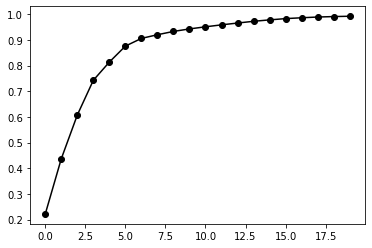

In [83]:
pc_dims = 10
pts_subset = 'all' # supports 'enc', 'dec', 'all', and 'encf'

# Finds percentage of variance explained by top pc_dims of PCA
# pca_full = PCA(n_components=rnn_specs['hidden_size'])
pca_full = PCA(n_components=np.min([len(hs[pts_subset]), rnn_specs['hidden_size']]))
_ = pca_full.fit_transform(np.vstack(hs[pts_subset]))
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', analysis.participation_ratio_vector(pca_full.explained_variance_))
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', analysis.participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
    total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(np.vstack(hs[pts_subset]))
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
cell, _, _ = analysis.build_cell(rnn_specs)
h0 = cell.get_initial_state(rnn_params)[:rnn_specs['hidden_size']]
print('h0 shape', h0.shape)

Plotting encoder states
Plotting decoder states
Example phrase length: 17
Example phrase: ['I4', 'I2', 'I4', 'I0', 'I3', 'I3', 'I3', 'I1', 'I6', 'I3', 'I9', 'I7', 'I6', 'I0', 'I1', 'I5', 'I8', '<pad>', '<pad>', '<pad>']


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


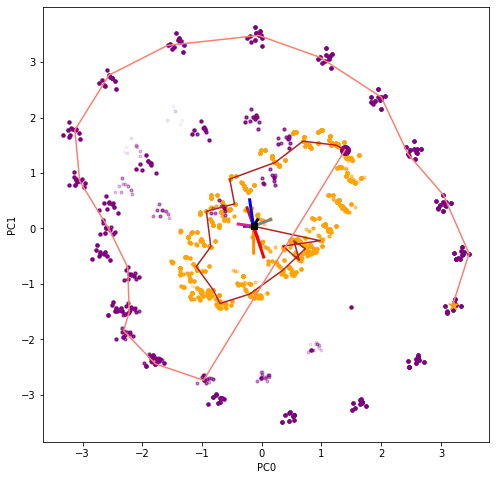

In [84]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pts_subset = 'all'

plt.figure(figsize=(8, 8))

pc1 = 0
pc2 = 1

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

final_hs_idx = 2*toy_params['phrase_length'] if pts_subset == 'all' and not rnn_specs['arch'] == 'one_to_one' else toy_params['phrase_length']
encode_hs_idx = 0 if pts_subset == 'dec' else enc_len

pca_h0 = pca.transform(np.atleast_2d(h0)).T
# pca_h0 = pca.transform(np.atleast_2d(np.concatenate([h0, np.zeros((h0.shape))], axis=0))).T

# Plots hidden states as scatter plot
fs_alpha = 0.05
if pts_subset in ['all', 'enc']: # Encoder states
    print('Plotting encoder states')
    pca_enc = pca.transform(np.vstack(hs['enc'])).T
    plt.scatter(pca_enc[pc1], pca_enc[pc2], color = 'orange', marker='.', alpha=fs_alpha, label='Encoder hs')
if pts_subset in ['all', 'dec']: # Decoder states
    print('Plotting decoder states')
    pca_dec = pca.transform(np.vstack(hs['dec'])).T
    plt.scatter(pca_dec[pc1], pca_dec[pc2], color = 'purple', marker='.', alpha=fs_alpha, label='Decoder hs')

# Plots example paths
hs_idxs = [0,] # [0]
for hs_idx in hs_idxs: # Plots example paths
    out_idx = hs_data['out_index'][hs_idx]
    print('Example phrase length:', out_idx)
    print('Example phrase:', toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    if pts_subset in ['enc', 'all']: # Adds h0 to path and plots
        pca_state = np.concatenate((pca_h0, pca.transform(hs[pts_subset][hs_idx]).T), axis=1) 
        if pts_subset == 'all':
            plt.plot(pca_state[pc1][:enc_len+1], pca_state[pc2][:enc_len+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
                     label=toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
            plt.plot(pca_state[pc1][enc_len:enc_len+out_idx+1], pca_state[pc2][enc_len:enc_len+out_idx+1], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
        elif pts_subset == 'enc':
            plt.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    else: # Doesn't add h0 to path and plots
        pca_state = pca.transform(hs[pts_subset][hs_idx]).T
        plt.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
                 label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    if pts_subset in ['dec', 'all']:  # Puts star on final hidden state
        pca_decf = pca.transform(np.atleast_2d(hs['decf'][hs_idx])).T
        plt.scatter(pca_decf[pc1], pca_decf[pc2], color = 'orange', marker='*', s=100.0, alpha=1.0)

    plt.scatter(pca_state[pc1, encode_hs_idx], pca_state[pc2, encode_hs_idx], color = 'purple', marker='o', 
                s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Special inputs plotting
# pos_enc_idxs = [0, 1, 2, 3]
# pos_enc_labs = ['0 hot', '1 hot', '2 hot', '3 hot', 'pos enc']
# for pos_enc_idx in pos_enc_idxs:
#   if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
#     pca_state = np.concatenate((pca_h0, pca.transform(hs['pos_enc'][pos_enc_idx]).T), axis=1) 
#   if pts_subset == 'all':
#     plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], 
#              marker=None, alpha=1.0, label=pos_enc_labs[pos_enc_idxs.index(pos_enc_idx)])
#     plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[pos_enc_idxs.index(pos_enc_idx)],
#              marker=None, alpha=1.0)
#   else:
#     plt.plot(pca_state[pc1], pca_state[pc2], color =  'k', marker=None, alpha=0.5, 
#               label=pos_enc_labs[pos_enc_idxs.index(pos_enc_idx)])
#   plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'k', marker='o', 
#                 s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# pca_states = pca.transform(np.vstack(hs)).T
# plt.plot(pca_states[pc1], pca_states[pc2], c = 'k', marker='o', alpha=0.01, label='Hidden sates')

# Plots readout direction
readout_type = 'att' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
pca_ro = pca.transform(readout_plot)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
# pca_zero = pca.transform(np.atleast_2d(np.zeros((2*rnn_specs['hidden_size'],)))).T
for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label=f'RO ({readout_type}): '+ toy_params['out_words'][i])

# path_idxs = [54, 56, 57]
# for path_idx in path_idxs:
#   print('Path labels:', syn_data_test['labels'][path_idx])
#   path_pca = pca.transform(hs[path_idx]).T
#   plt.plot(path_pca[pc1], path_pca[pc2], c='orange', marker='.', label='Random Path')

plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))
plt_lim = None
if plt_lim != None:
    plt.xlim(-plt_lim, plt_lim)
    plt.ylim(-plt_lim, plt_lim)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
for i in range(12):
    print(f'Example phrase {i}:', tensorToPhrase(hs_data['inputs'][i], toy_params['in_words']))

Example phrase 0: ['run', '<pad>', '<pad>', '<pad>']
Example phrase 1: ['walk', 'and', 'jump', '<pad>']
Example phrase 2: ['jump', 'and', 'run', '<pad>']
Example phrase 3: ['walk', '<pad>', '<pad>', '<pad>']
Example phrase 4: ['run', 'and', 'walk', '<pad>']
Example phrase 5: ['walk', 'and', 'run', '<pad>']
Example phrase 6: ['run', 'and', 'jump', '<pad>']
Example phrase 7: ['run', 'and', 'run', '<pad>']
Example phrase 8: ['jump', 'and', 'jump', '<pad>']
Example phrase 9: ['jump', 'and', 'walk', '<pad>']
Example phrase 10: ['jump', '<pad>', '<pad>', '<pad>']
Example phrase 11: ['walk', 'and', 'walk', '<pad>']


#### Readout Vector Analysis

In [ ]:
dec_mags = [[] for _ in range(dec_len)]
attn_mags = [[] for _ in range(dec_len)]
logit_angle = [[] for _ in range(dec_len)]

h = hs['all'][0]
logits = raw_logits[0]
out_idx = hs_data['out_index'][0]

seq_idx = 0
while seq_idx <= out_idx:
    dec_logits = np.copy(np.matmul(readout_dec, h[enc_len + seq_idx]))
    attn_logits = np.copy(logits[seq_idx] - dec_logits)

    # print('Dec perc:', np.linalg.norm(logits[seq_idx] - dec_logits)/np.linalg.norm(logits[seq_idx]))
    # print('Attn perc:', np.linalg.norm(logits[seq_idx] - attn_logits)/np.linalg.norm(logits[seq_idx]))
    dec_logits.sort()
    attn_logits.sort()

    print('Dec (mag ', np.linalg.norm(dec_logits), '):', dec_logits)
    print('Attn (mag ', np.linalg.norm(attn_logits), '):', attn_logits)
    print('Total (mag ', np.linalg.norm(logits[seq_idx]), '):', logits[seq_idx])
    print('Dec Attn Angle', analysis.angle_degrees(dec_logits, attn_logits))

    print('Dec diff:', [dec_logits[-1] - dec_logits[-1-i] for i in range(1, len(dec_logits))])
    print('Attn diff:', [attn_logits[-1] - attn_logits[-1-i] for i in range(1, len(attn_logits))])

    seq_idx += 1


Dec (mag  6.684656 ): [-5.607075  -0.5183538  0.661434   0.8074833  0.9373657  3.3179007]
Attn (mag  7.5797596 ): [-2.7300987 -2.2812839 -1.018064  -0.3169805 -0.2937076  6.6008987]
Total (mag  10.6170025 ): [ 0.4905028  0.3677264  7.5382643  1.0366169 -6.625139  -3.2484527]
Dec Attn Angle 42.78307211181468
Dec diff: [2.380535, 2.5104175, 2.6564667, 3.8362546, 8.924976]
Attn diff: [6.8946066, 6.917879, 7.618963, 8.882183, 9.330997]
Dec (mag  6.142621 ): [-5.4401016  0.3124997  0.5418773  0.6025218  1.3138984  2.3783267]
Attn (mag  10.613787 ): [-3.0234728  -2.189879   -2.0257242  -1.8684127  -0.59067047  9.527439  ]
Total (mag  13.3888445 ): [-1.587357  -1.7132244 10.069317   0.5099139  0.723228  -8.463574 ]
Dec Attn Angle 57.089077498230225
Dec diff: [1.0644282, 1.7758049, 1.8364494, 2.065827, 7.818428]
Attn diff: [10.11811, 11.395852, 11.553164, 11.717318, 12.550912]
Dec (mag  10.201471 ): [-8.9564705  0.6915134  0.8339033  1.0460703  1.9379011  4.222363 ]
Attn (mag  9.649733 ): [-3.

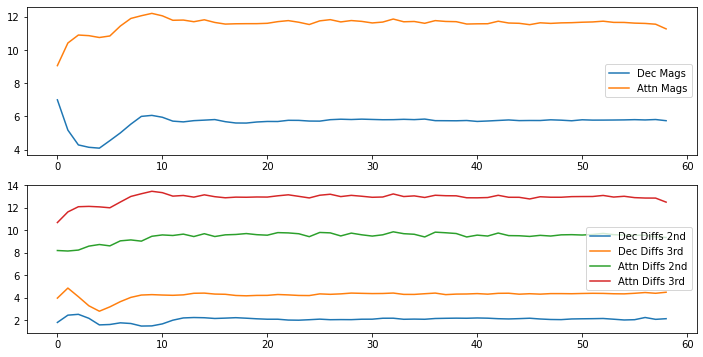

In [ ]:
# Finds how much each readout is used for classification

dec_mags = [[] for _ in range(dec_len-1)]
attn_mags = [[] for _ in range(dec_len-1)]
dec_diffs = [[] for _ in range(dec_len-1)]
attn_diffs = [[] for _ in range(dec_len-1)]
logit_angle = [[] for _ in range(dec_len-1)]

for h, logits, out_idx in zip(hs['all'], raw_logits, hs_data['out_index']):
  seq_idx = 0
  while seq_idx < out_idx:
    dec_logits = np.copy(np.matmul(readout_dec, h[enc_len + seq_idx]))
    attn_logits = np.copy(logits[seq_idx] - dec_logits)
    
    dec_logits.sort()
    attn_logits.sort()

    if (np.array([dec_logits[-1] - dec_logits[-1-i] for i in range(1, len(dec_logits))]) < 0).any():
      print('Difference below zero')

    dec_mags[seq_idx].append(np.linalg.norm(dec_logits))
    attn_mags[seq_idx].append(np.linalg.norm(attn_logits))
    dec_diffs[seq_idx].append([dec_logits[-1] - dec_logits[-1-i] for i in range(1, len(dec_logits))])
    attn_diffs[seq_idx].append([attn_logits[-1] - attn_logits[-1-i] for i in range(1, len(attn_logits))])

    logit_angle[seq_idx].append(analysis.angle_degrees(dec_logits, attn_logits))
    
    seq_idx += 1

dec_mags = [np.mean(seq_vals) for seq_vals in dec_mags]
attn_mags = [np.mean(seq_vals) for seq_vals in attn_mags]
dec_diffs = np.array([np.mean(np.array(seq_vals), axis=0) for seq_vals in dec_diffs])
attn_diffs = np.array([np.mean(np.array(seq_vals), axis=0) for seq_vals in attn_diffs])
logit_angle = [np.mean(seq_vals) for seq_vals in logit_angle]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.plot(np.arange(dec_len-1), dec_mags, label='Dec Mags')
ax1.plot(np.arange(dec_len-1), attn_mags, label='Attn Mags')
ax1.legend()
ax2.plot(np.arange(dec_len-1), dec_diffs[:, 0], label='Dec Diffs 2nd')
ax2.plot(np.arange(dec_len-1), dec_diffs[:, 1], label='Dec Diffs 3rd')
ax2.plot(np.arange(dec_len-1), attn_diffs[:, 0], label='Attn Diffs 2nd')
ax2.plot(np.arange(dec_len-1), attn_diffs[:, 1], label='Attn Diffs 3rd')
ax2.legend()

In [ ]:
for i in range(len(readout)):
  print('Readout (attn) {} mag:'.format(i), np.linalg.norm(readout[i]))
for i in range(len(readout_dec)):
  print('Readout (decoder) {} mag:'.format(i), np.linalg.norm(readout_dec[i]))
for i in range(len(readout_dec)):
  print('Readout att/decoder {} angle:'.format(i), analysis.angle_degrees(readout[i], readout_dec[i]))

Readout (attn) 0 mag: 2.7549293
Readout (attn) 1 mag: 2.7619731
Readout (attn) 2 mag: 2.756042
Readout (attn) 3 mag: 0.5302906
Readout (decoder) 0 mag: 0.59859645
Readout (decoder) 1 mag: 0.57708174
Readout (decoder) 2 mag: 0.58919597
Readout (decoder) 3 mag: 1.5766032
Readout att/decoder 0 angle: 85.75693872790451
Readout att/decoder 1 angle: 80.91104245518552
Readout att/decoder 2 angle: 81.46820147635097
Readout att/decoder 3 angle: 95.02155758227154


In [ ]:
# Check to see if we can reproduce the attention part of the readout by hand (to see if it matches subtract out)
idx = 0

# Calculate attention matrix via apply function
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]

_, new_apply_fun, _, _, _ = train_build.build_rnn(rnn_specs)
all_logits, attn_matrix_dir = new_apply_fun(final_params, hs_data['inputs'], hs_data['in_index'], return_att_matrix=True)

h = hs['all'][idx]
logits = raw_logits[idx]
in_idx = hs_data['in_index'][idx]
out_idx = hs_data['out_index'][idx]
attn_matrix = attn_matrix_dir[idx]

seq_idx = 0
while seq_idx <= out_idx:
  dec_logits = np.matmul(readout_dec, h[enc_len + seq_idx])
  attn_logits = logits[seq_idx] - dec_logits
  
  enc_hs = h[:enc_len]

  softmax_aligns = attn_matrix[:,seq_idx]
  # (enc_len) x (enc_len, hidden_size) -> (hidden_size)
  attention_state = jnp.einsum('i,ik->k', softmax_aligns, enc_hs)
  attn_logits2 = np.matmul(readout, attention_state)
  print('Attn (mag ', np.linalg.norm(attn_logits), '):', attn_logits)
  print('Attn2 (mag ', np.linalg.norm(attn_logits2), '):', attn_logits2)
  seq_idx += 1

Decoder sequence size: (1000, 20, 4)
Zero context False
Attn (mag  3.8420217 ): [-0.9880869  -1.8256617   3.2068353  -0.40985632]
Attn2 (mag  3.8420215 ): [-0.98808694 -1.8256615   3.206835   -0.40985626]
Attn (mag  3.029792 ): [ 2.5971427  -1.0912815  -0.98608005 -0.52080727]
Attn2 (mag  3.0297925 ): [ 2.5971434  -1.0912814  -0.98608005 -0.5208069 ]
Attn (mag  4.109438 ): [-1.40716     3.5308185  -1.3895359  -0.71406794]
Attn2 (mag  4.109438 ): [-1.40716     3.5308185  -1.3895359  -0.71406776]
Attn (mag  4.7978854 ): [-2.2138257 -0.786086   4.059351  -1.0111461]
Attn2 (mag  4.797885 ): [-2.2138255 -0.7860862  4.059351  -1.0111458]
Attn (mag  5.89882 ): [-2.2188725 -1.4763572  5.093123  -1.3240647]
Attn2 (mag  5.89882 ): [-2.218872  -1.4763572  5.093123  -1.3240645]
Attn (mag  6.29852 ): [-2.0745966 -1.5494956  5.4696054 -1.7463914]
Attn2 (mag  6.29852 ): [-2.0745964 -1.5494956  5.4696054 -1.7463914]
Attn (mag  5.176585 ): [-1.8469014  -0.07328963  4.281805   -2.2465    ]
Attn2 (mag  5

In [ ]:
from itertools import combinations 

def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x P vector
  For each of b's columns, finds the percentage of its magnitude which lies in 
  the subspace formed by the columns of A (its columnspace). Then averages these together
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
  b_proj = np.matmul(proj, b) # N x P martix

  norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

  return np.mean(norm_perc)

def ro_subspace_analysis(readout):
  readout = np.asarray(readout)
  ro_n = readout.shape[0]
  indices = [i for i in range(ro_n)]
  for ss_dim in range(1, ro_n): # Tries dimensions from 1 to ro_n - 1
    comb = combinations(indices, ss_dim) # Gets all possible combinations
    n_comb = 0
    perc_vals = 0
    for subspace_idxs in list(comb): # For each combination
      n_comb += 1
      A_idxs = list(subspace_idxs)
      b_idxs = list(filter(lambda a: a not in list(subspace_idxs), indices))
      A = readout[A_idxs]
      b = readout[b_idxs] 
      perc_vals += subspace_perc(A.T, b.T)
    print('Avg perc in rest for subspace dim {}:'.format(ss_dim), 1/n_comb * perc_vals)

readout_mags = []
readout_pca_mags = []
pc_dims = 2
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  # readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  # print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j])))

ro_subspace_analysis(readout)

if rnn_specs['arch'] in ['enc_dec_atth']:
  for i in range(len(readout_dec)):
    print('Readout (decoder) {} mag:'.format(i), np.linalg.norm(readout_dec[i]))
    # readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  for i in range(len(readout_dec)):
    print('Readout att/decoder {} dot:'.format(i), 180/np.pi * np.arccos(np.dot(readout[i], readout_dec[i])/
          (np.linalg.norm(readout[i])*np.linalg.norm(readout_dec[i]))))

Readout 0 mag: 4.0433307
Readout 1 mag: 3.998091
Readout 2 mag: 4.0279903
Readout 3 mag: 3.0289621
Angle (1, 0): 111.75584889788294
Angle (2, 0): 112.4901420449835
Angle (2, 1): 112.39183513225952
Angle (3, 0): 103.60207834974844
Angle (3, 1): 102.44027000211844
Angle (3, 2): 104.82435436210056
Avg perc in rest for subspace dim 1: 0.30676187202334404
Avg perc in rest for subspace dim 2: 0.5274186631043751
Avg perc in rest for subspace dim 3: 0.873762458562851
Readout (decoder) 0 mag: 2.3100767
Readout (decoder) 1 mag: 2.4662018
Readout (decoder) 2 mag: 2.0860424
Readout (decoder) 3 mag: 1.827806
Readout att/decoder 0 dot: 112.11012397994233
Readout att/decoder 1 dot: 115.64750627184861
Readout att/decoder 2 dot: 107.83646095588702
Readout att/decoder 3 dot: 93.49137664213525


Text(0.5, 0, 'Decoder Readout Idx')

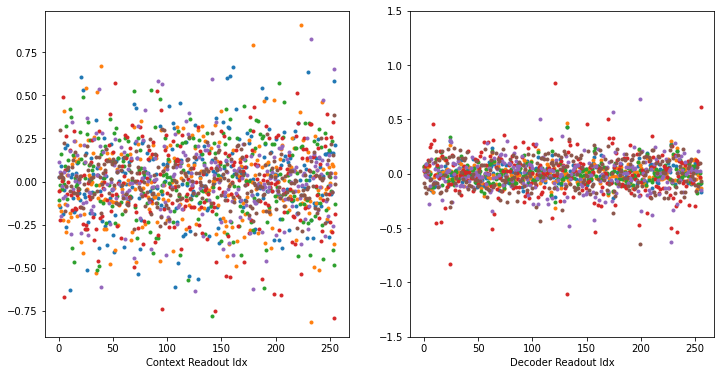

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

for i in range(6):
  ax1.plot(np.arange(256), readout[i], linewidth=0.0, marker='.')
for i in range(6):
  ax2.plot(np.arange(256), readout_dec[i], linewidth=0.0, marker='.')

plt.ylim([-1.5,1.5])
ax1.set_xlabel('Context Readout Idx')
ax2.set_xlabel('Decoder Readout Idx')

x 1.0
y 1.0
x.y 1.5832484e-08
Example phrase length: 57
Example phrase: ['I2', 'I0', 'I0', 'I2', 'I0', 'I1', 'I2', 'I2', 'I1', 'I0', 'I2', 'I0', 'I0', 'I0', 'I1', 'I1', 'I1', 'I2', 'I2', 'I0', 'I0', 'I0', 'I0', 'I1', 'I1', 'I0', 'I2', 'I2', 'I1', 'I1', 'I1', 'I0', 'I2', 'I2', 'I2', 'I2', 'I1', 'I2', 'I1', 'I2', 'I0', 'I1', 'I0', 'I1', 'I2', 'I0', 'I1', 'I1', 'I0', 'I2', 'I2', 'I1', 'I0', 'I2', 'I1', 'I0', 'I1', '<pad>', '<pad>', '<pad>']


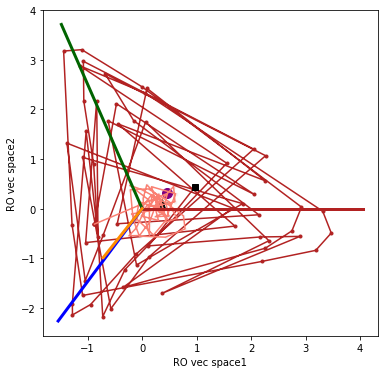

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
encode_hs_idx = 0 if pts_subset == 'dec' else enc_len

# Creates basis vectors for the readout space
readout_type = 'att' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
x_basis = readout_plot[ro1] / np.linalg.norm(readout_plot[ro1])
y_vec = readout_plot[ro2] - np.dot(x_basis, readout_plot[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

h0 = cell.get_initial_state(rnn_params)[:rnn_specs['hidden_size']]
h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)

# Plots hidden states
fs_alpha = 0.05
hs_x_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), x_basis)
hs_y_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), y_basis)
if pts_subset == 'all':
  plt.scatter(hs_x_vals[:enc_len], hs_y_vals[:enc_len], color = 'k', marker='.', alpha=fs_alpha)
  plt.scatter(hs_x_vals[enc_len:enc_len+dec_len], hs_y_vals[enc_len:enc_len+dec_len], color = 'gray', marker='.', alpha=fs_alpha)
else:
  plt.scatter(hs_x_vals, hs_y_vals, color = 'purple', marker='.', alpha=fs_alpha)

hs_idxs = [0]
for hs_idx in hs_idxs: # Plots example paths
  out_idx = hs_data['out_index'][hs_idx]
  print('Example phrase length:', hs_data['out_index'][hs_idx])
  print('Example phrase:', toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
    hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), x_basis)))
    hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), y_basis)))
  if pts_subset == 'dec' or pts_subset == 'all':  # Puts star on final hidden state
    x_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), x_basis)
    y_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), y_basis)
    plt.scatter(x_decf, y_decf, color = 'k', marker='*', 
                s=100.0, alpha=1.0)
  if pts_subset == 'all':
    plt.plot(hs_path_x[:enc_len+1], hs_path_y[:enc_len+1], color = state_colors[hs_idxs.index(hs_idx)], marker='.', alpha=1.0,
             label=toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    plt.plot(hs_path_x[enc_len:], hs_path_y[enc_len:], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
  else:
    plt.plot(hs_path_x, hs_path_y, color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  plt.scatter(hs_path_x[encode_hs_idx+1], hs_path_y[encode_hs_idx+1], color = 'purple', marker='o', 
                s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# # Positional encoding plotting
# if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
#   hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs['special'][0]), proj), x_basis)))
#   hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs['special'][0]), proj), y_basis)))
# if pts_subset == 'all':
#   plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = 'k', marker=None, alpha=1.0,
#             label='Pos Enc Output')
#   plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = 'k', marker=None, alpha=1.0)
# else:
#   plt.plot(pca_state[pc1], pca_state[pc2], color =  'k', marker=None, alpha=0.5, 
#             label='Pos Enc Output')
# plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'k', marker='o', 
#               s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Plots readout direction
pca_ro = pca.transform(readout_plot)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout_plot.shape[0]):
  ro_proj = np.matmul(proj, readout_plot[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], color=state_colors[i], 
           linewidth = 3, label=f'RO ({readout_type}): '+toy_params['out_words'][i])

plt.plot(h0_x_val, h0_y_val, 'ks', label='Initial state')

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt_lim = None
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
encode_hs_idx = 0 if pts_subset == 'dec' else enc_len

# Creates basis vectors for the readout space
readout_type = 'att' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
x_basis = readout_plot[ro1] / np.linalg.norm(readout_plot[ro1])
y_vec = readout_plot[ro2] - np.dot(x_basis, readout_plot[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

h0 = cell.get_initial_state(rnn_params)[:rnn_specs['hidden_size']]
h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)

# Plots hidden states
fs_alpha = 0.05
hs_x_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), x_basis)
hs_y_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), y_basis)
if pts_subset == 'all':
  plt.scatter(hs_x_vals[:enc_len], hs_y_vals[:enc_len], color = 'k', marker='.', alpha=fs_alpha)
  plt.scatter(hs_x_vals[enc_len:enc_len+dec_len], hs_y_vals[enc_len:enc_len+dec_len], color = 'gray', marker='.', alpha=fs_alpha)
else:
  plt.scatter(hs_x_vals, hs_y_vals, color = 'purple', marker='.', alpha=fs_alpha)

hs_idxs = [0]
for hs_idx in hs_idxs: # Plots example paths
  out_idx = hs_data['out_index'][hs_idx]
  print('Example phrase length:', hs_data['out_index'][hs_idx])
  print('Example phrase:', toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
    hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), x_basis)))
    hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), y_basis)))
  if pts_subset == 'dec' or pts_subset == 'all':  # Puts star on final hidden state
    x_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), x_basis)
    y_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), y_basis)
    plt.scatter(x_decf, y_decf, color = 'k', marker='*', 
                s=100.0, alpha=1.0)
  if pts_subset == 'all':
    plt.plot(hs_path_x[:enc_len+1], hs_path_y[:enc_len+1], color = state_colors[hs_idxs.index(hs_idx)], marker='.', alpha=1.0,
             label=toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    plt.plot(hs_path_x[enc_len:], hs_path_y[enc_len:], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
  else:
    plt.plot(hs_path_x, hs_path_y, color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  plt.scatter(hs_path_x[encode_hs_idx+1], hs_path_y[encode_hs_idx+1], color = 'purple', marker='o', 
                s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# # Positional encoding plotting
# if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
#   hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs['special'][0]), proj), x_basis)))
#   hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs['special'][0]), proj), y_basis)))
# if pts_subset == 'all':
#   plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = 'k', marker=None, alpha=1.0,
#             label='Pos Enc Output')
#   plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = 'k', marker=None, alpha=1.0)
# else:
#   plt.plot(pca_state[pc1], pca_state[pc2], color =  'k', marker=None, alpha=0.5, 
#             label='Pos Enc Output')
# plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'k', marker='o', 
#               s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Plots readout direction
pca_ro = pca.transform(readout_plot)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout_plot.shape[0]):
  ro_proj = np.matmul(proj, readout_plot[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], color=state_colors[i], 
           linewidth = 3, label=f'RO ({readout_type}): '+toy_params['out_words'][i])

plt.plot(h0_x_val, h0_y_val, 'ks', label='Initial state')

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt_lim = None
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
# Calculation of input and temporal components for plotting with readouts below

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

print('Using true average hidden state as temporal part')
temporal_hs = avg_hs
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]
if toy_params['var_length']:
  pad_in_idx = toy_params['in_words_pp'].index('<pad>')
  pad_out_idx = toy_params['out_words_pp'].index('<pad>')
# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - temporal_hs for h in hs['all']]

hs_inputs_bare, hs_outputs_bare = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params)
hs_inputs, hs_outputs = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=True, avg_hs=avg_hs)

Finding average hidden state at each time step...
Using true average hidden state as temporal part
Finding average hidden state at each time step...


x 1.0
y 1.0
x.y 7.4505806e-08


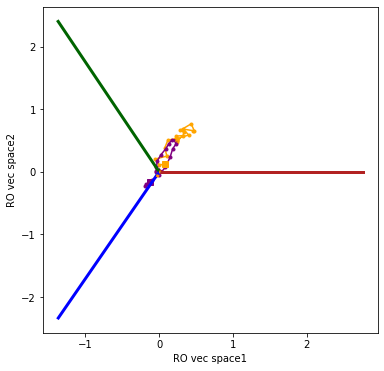

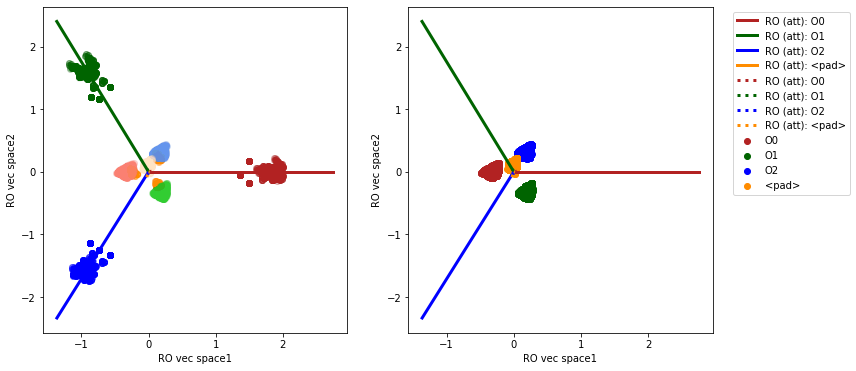

In [ ]:
# Project temporal and input-delta components onto readout space
ro1 = 0
ro2 = 1

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# Creates basis vectors for the readout space
readout_type = 'att' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
x_basis = readout_plot[ro1] / np.linalg.norm(readout_plot[ro1])
y_vec = readout_plot[ro2] - np.dot(x_basis, readout_plot[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden

# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))

##### Plotting for temporal part #####

pts_subset = 'all'

# pca_avg = PCA(n_components=5)
avg_hs_x = np.dot(np.matmul(avg_hs, proj), x_basis)
avg_hs_y = np.dot(np.matmul(avg_hs, proj), y_basis)

ax1.plot(avg_hs_x[:enc_len], avg_hs_y[:enc_len], marker='.', color='orange', label='encoder')
ax1.plot(avg_hs_x[enc_len:], avg_hs_y[enc_len:], marker='.', color='purple', label='decoder')
# Squares at start of each
ax1.plot(avg_hs_x[0], avg_hs_y[0], marker='s', color='orange')
ax1.plot(avg_hs_x[enc_len], avg_hs_y[enc_len], marker='s', color='purple')
# Stars at the end
ax1.plot(avg_hs_x[enc_len-1], avg_hs_y[enc_len-1], marker='*', color='orange')
ax1.plot(avg_hs_x[-1], avg_hs_y[-1], marker='*', color='purple')

# hs_idxs = [0]
# for hs_idx in hs_idxs: # Plots example paths
#   out_idx = hs_data['out_index'][hs_idx]
#   hs_path_x = np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), x_basis)
#   hs_path_y = np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), y_basis)
#   ax1.plot(hs_path_x[:enc_len], hs_path_y[:enc_len], color = state_colors[hs_idxs.index(hs_idx)], marker='.', alpha=1.0,
#              label='random path')
#   ax1.plot(hs_path_x[enc_len:], hs_path_y[enc_len:], color = state_colors_light[hs_idxs.index(hs_idx)], marker='.', alpha=1.0)

# ax1.legend()

##### Plotting for word part #####

pts_subset = 'all'

alpha_s = 0.05

for inp_idx in range(len(toy_params['in_words_pp'])):
  hs_word = []
  for time_idx in range(enc_len):
    hs_word.extend(hs_inputs[time_idx][inp_idx])
  hs_word = np.array(hs_word)
  hs_word_x = np.dot(np.matmul(hs_word, proj), x_basis)
  hs_word_y = np.dot(np.matmul(hs_word, proj), y_basis)
  ax2.scatter(hs_word_x, hs_word_y, color=state_colors[inp_idx], alpha=alpha_s,
              label=toy_params['in_words'][inp_idx])
for out_idx in range(len(toy_params['out_words_pp'])):
  hs_word = []
  for time_idx in range(dec_len):
    hs_word.extend(hs_outputs[time_idx][out_idx])
  hs_word = np.array(hs_word)
  hs_word_x = np.dot(np.matmul(hs_word, proj), x_basis)
  hs_word_y = np.dot(np.matmul(hs_word, proj), y_basis)
  ax2.scatter(hs_word_x, hs_word_y, color=state_colors_light[out_idx], alpha=alpha_s)


# ax3.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
for out_idx in range(len(toy_params['out_words_pp'])):
  hs_word = []
  for time_idx in range(dec_len):
    hs_word.extend(hs_outputs[time_idx][out_idx])
  hs_word = np.array(hs_word)
  hs_word_x = np.dot(np.matmul(hs_word, proj), x_basis)
  hs_word_y = np.dot(np.matmul(hs_word, proj), y_basis)
  ax3.scatter(hs_word_x, hs_word_y, color=state_colors[out_idx], label=toy_params['out_words'][out_idx])

# Plots readout direction
readout_types = ['att', 'hs']  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_color_idxs = [0, 1, 2, 3, 6, 7]
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  # Plots readout direction
  for i in range(readout_plot.shape[0]):
    ro_proj = np.matmul(proj, readout_plot[i])
    for ax in (ax1, ax2, ax3):
      ax.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], color=state_colors[i], linestyle=ro_styles[idx],
              linewidth = 3, label=f'RO ({readout_type}): '+toy_params['out_words'][i])

ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in (ax1, ax2, ax3):
  ax.set_xlabel('RO vec space1')
  ax.set_ylabel('RO vec space2')

for ax in [ax1, ax2]:
  plt_lim = None
  if plt_lim != None:
    ax.xlim(-plt_lim, plt_lim)
    ax.ylim(-plt_lim, plt_lim)

#### Attention Analysis

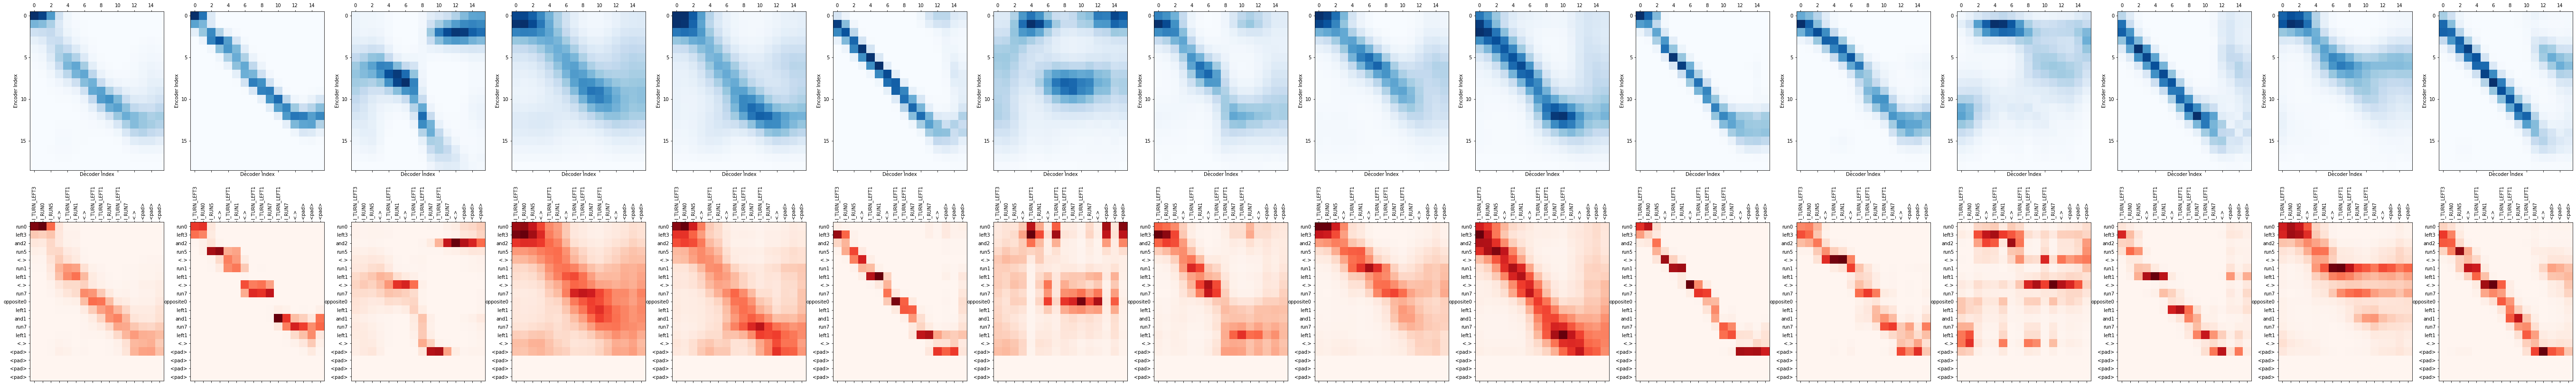

In [105]:
# Calculate attention matrix via apply function
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]

all_logits, attn_matrix_dir = apply_fun(final_params, hs_data['inputs'], hs_data['in_index'], returns={'att_matrix'})

phrase_idxs = [12, 1]

# Mean attention matrix
if rnn_specs['arch'] in ('enc_dec_attmh',):
    fig, (mean_axs, samp_axs) = plt.subplots(2, rnn_specs['attn_heads'], figsize=(6*rnn_specs['attn_heads'],15))

    enc_labels = toy.tensorToPhrase(hs_data['inputs'][phrase_idxs[0]], toy_params['in_words'])
    dec_labels = toy.tensorToPhrase(hs_data['labels'][phrase_idxs[0]], toy_params['out_words'])
    if  rnn_specs['attn_heads'] == 1: # Turns axes into to tuples if using only one head
        mean_axs, samp_axs = (mean_axs,), (samp_axs,)

    for head_idx, ax in zip(range(rnn_specs['attn_heads']), mean_axs):
        ax. matshow(np.mean(attn_matrix_dir[:, :, :, head_idx], axis=0), cmap=plt.cm.Blues)
        ax.set_ylabel('Encoder Index')
        ax.set_xlabel('Decoder Index')

    for head_idx, ax in zip(range(rnn_specs['attn_heads']), samp_axs):
        ax.matshow(attn_matrix_dir[phrase_idxs[0], :, :, head_idx], cmap=plt.cm.Reds)
        ax.set_xticks([j for j in range(dec_len)])
        ax.set_yticks([j for j in range(enc_len)])
        ax.set_yticklabels(enc_labels, rotation=0)
        ax.set_xticklabels(dec_labels, rotation=90)
else:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,24))

    ax1.matshow(np.mean(attn_matrix_dir, axis=0), cmap=plt.cm.Blues)

    ax1.set_ylabel('Encoder Index')
    ax1.set_xlabel('Decoder Index')
    for ax, i in zip((ax2, ax3), phrase_idxs):
        print('In index', hs_data['in_index'][i])
        print('Out index', hs_data['out_index'][i])

        ax.matshow(attn_matrix_dir[i], cmap=plt.cm.Blues)
        enc_labels = toy.tensorToPhrase(hs_data['inputs'][i], toy_params['in_words'])
        dec_labels = toy.tensorToPhrase(hs_data['labels'][i], toy_params['out_words'])

        ax.set_ylabel('Encoder Index')
        ax.set_xlabel('Decoder Index')

        ax.set_xticks([j for j in range(dec_len)])
        ax.set_yticks([j for j in range(enc_len)])
        ax.set_yticklabels(enc_labels, rotation=0)
        ax.set_xticklabels(dec_labels, rotation=90)

In [ ]:
# Calculate attention average attention matrix by hand via hidden states

from scipy.special import softmax
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,24))

print('Single sequence shape:', hs['all'][0].shape)
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]
attention_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
for h_idx in range(len(hs['all'])):
  if h_idx % 100 == 0: print(h_idx)
  enc_seq = hs['all'][h_idx][:enc_len]
  for seq_idx in range(dec_len):
    raw_aligns = np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx])
    # Masks if beyond in_index length
    raw_aligns[hs_data['in_index'][h_idx]+1:] = -10000 * np.ones((enc_len - hs_data['in_index'][h_idx]-1))
    attention_matrix[h_idx, :, seq_idx] = softmax(raw_aligns)

# Mean attention matrix
ax1.matshow(np.mean(attention_matrix, axis=0), cmap=plt.cm.Blues)

phrase_idxs = [8, 9]

ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

for ax, i in zip((ax2, ax3), phrase_idxs):
  ax.matshow(attention_matrix[i], cmap=plt.cm.Blues)
  enc_labels = tensorToPhrase(hs_data['inputs'][i], toy_params['in_words'])
  dec_labels = tensorToPhrase(hs_data['labels'][i], toy_params['out_words'])

  ax.set_ylabel('Encoder Index')
  ax.set_xlabel('Decoder Index')

  ax.set_xticks([j for j in range(dec_len)])
  ax.set_yticks([j for j in range(enc_len)])
  ax.set_yticklabels(enc_labels, rotation=0)
  ax.set_xticklabels(dec_labels, rotation=90)

Get all states with arch: enc_dec_atth
Running attnh with pos_enc: False
Decoder sequence size: (6, 60, 4)
Zero context False


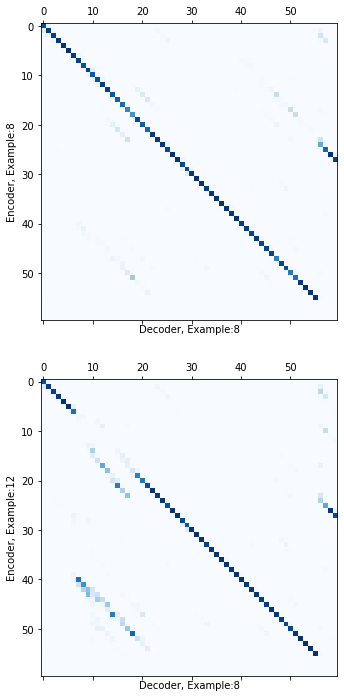

In [ ]:
# Compares the attention matrix calculated with a given encoder and decoder pair beloninging
# to the same example, versus the encoder phrase of another example.

from scipy.special import softmax
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

phrase_idx = 8
comparison_idx = 12
# Creates more special hs_data that differ from the reference phrase
test_inputs = np.zeros((6,) + hs_data['inputs'][0].shape)
test_inputs[0,] = hs_data['inputs'][phrase_idx]
# test_inputs[1,:30] = hs_data['inputs'][phrase_idx][:30]
# test_inputs[1,30:] = hs_data['inputs'][comparison_idx][30:]
# test_inputs[1,:5] = hs_data['inputs'][comparison_idx][:5]
# test_inputs[1,5:] = hs_data['inputs'][phrase_idx][5:]
st, et = 5, 10 # start transition/end transition times
test_inputs[1,:st] = hs_data['inputs'][phrase_idx][:st]
test_inputs[1,st:et] = hs_data['inputs'][comparison_idx][st:et]
test_inputs[1,et:] = hs_data['inputs'][phrase_idx][et:]
st, et = 15, 20 # start transition/end transition times
test_inputs[2,:st] = hs_data['inputs'][phrase_idx][:st]
test_inputs[2,st:et] = hs_data['inputs'][comparison_idx][st:et]
test_inputs[2,et:] = hs_data['inputs'][phrase_idx][et:]
st, et = 25, 30 # start transition/end transition times
test_inputs[3,:st] = hs_data['inputs'][phrase_idx][:st]
test_inputs[3,st:et] = hs_data['inputs'][comparison_idx][st:et]
test_inputs[3,et:] = hs_data['inputs'][phrase_idx][et:]
st, et = 35, 40 # start transition/end transition times
test_inputs[4,:st] = hs_data['inputs'][phrase_idx][:st]
test_inputs[4,st:et] = hs_data['inputs'][comparison_idx][st:et]
test_inputs[4,et:] = hs_data['inputs'][phrase_idx][et:]
st, et = 45, 50 # start transition/end transition times
test_inputs[5,:st] = hs_data['inputs'][phrase_idx][:st]
test_inputs[5,st:et] = hs_data['inputs'][comparison_idx][st:et]
test_inputs[5,et:] = hs_data['inputs'][phrase_idx][et:]
special_test_data =  {
  'inputs': test_inputs,
  'labels': jnp.zeros((test_inputs.shape[0],) + hs_data['labels'][0].shape), # These aren't used
  # 'in_index': jnp.array([hs_data['in_index'][phrase_idx], hs_data['in_index'][comparison_idx]]),
  'in_index': jnp.array([hs_data['in_index'][phrase_idx] for _ in range(test_inputs.shape[0])]),
  'out_index': jnp.array([hs_data['out_index'][phrase_idx] for _ in range(test_inputs.shape[0])]),
}
test_logits, hs['test'] = analysis.rnn_states(cells, readout_apply, special_test_data, final_params, rnn_specs, return_hidden=True)

enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]
attention_matrix = np.zeros((len(phrase_idxs), enc_len, dec_len))

for h_idx in range(2):
  enc_seq = hs['test'][h_idx][:enc_len]
  for seq_idx in range(dec_len):
    # Always use phrase_idx for the decoder sequence
    raw_aligns = np.dot(enc_seq, hs['test'][0][enc_len + seq_idx])
    # Masks if beyond in_index length
    raw_aligns[special_test_data['in_index'][h_idx]+1:] = -10000 * np.ones((enc_len - special_test_data['in_index'][h_idx]-1))
    attention_matrix[h_idx, :, seq_idx] = softmax(raw_aligns)


ax1.set_ylabel('Encoder, Example:' + str(phrase_idx))
ax1.set_xlabel('Decoder, Example:' + str(phrase_idx))
ax2.set_ylabel('Encoder, Example:' + str(comparison_idx))
ax2.set_xlabel('Decoder, Example:' + str(phrase_idx))

for ax, idx, phrase_idx in zip((ax1, ax2), range(len(phrase_idxs)), phrase_idxs):
  ax.matshow(attention_matrix[idx], cmap=plt.cm.Blues)
  # enc_labels = toy.tensorToPhrase(hs_data['inputs'][phrase_idx], toy_params['in_words'])
  # dec_labels = toy.tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['out_words'])

  # ax.set_xticks([j for j in range(dec_len)])
  # ax.set_yticks([j for j in range(enc_len)])
  # ax.set_yticklabels(enc_labels, rotation=0)
  # ax.set_xticklabels(dec_labels, rotation=90)

DeviceArray([ True,  True,  True,  True,  True, False, False, False,
             False, False,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
             False, False, False, False], dtype=bool)

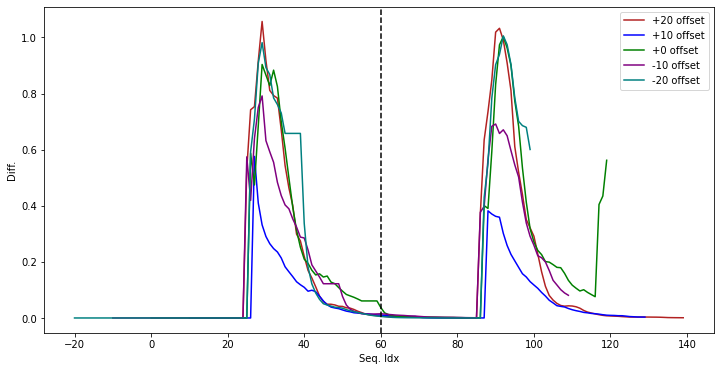

In [ ]:
# Calculates difference of hidden states as a function of time

diff1 = np.linalg.norm(hs['test'][0] - hs['test'][1], axis=1)/np.linalg.norm(hs['test'][0], axis=1)
diff2 = np.linalg.norm(hs['test'][0] - hs['test'][2], axis=1)/np.linalg.norm(hs['test'][0], axis=1)
diff3 = np.linalg.norm(hs['test'][0] - hs['test'][3], axis=1)/np.linalg.norm(hs['test'][0], axis=1)
diff4 = np.linalg.norm(hs['test'][0] - hs['test'][4], axis=1)/np.linalg.norm(hs['test'][0], axis=1)
diff5 = np.linalg.norm(hs['test'][0] - hs['test'][5], axis=1)/np.linalg.norm(hs['test'][0], axis=1)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.arange(enc_len+dec_len)+20, diff1, color='firebrick', label='+20 offset')
ax1.plot(np.arange(enc_len+dec_len)+10, diff2, color='blue', label='+10 offset')
ax1.plot(np.arange(enc_len+dec_len), diff3, color='green', label='+0 offset')
ax1.plot(np.arange(enc_len+dec_len)-10, diff4, color='purple', label='-10 offset')
ax1.plot(np.arange(enc_len+dec_len)-20, diff5, color='teal', label='-20 offset')
ax1.set_ylabel('Diff.')
ax1.set_xlabel('Seq. Idx')
ax1.axvline(enc_len, color='k', linestyle='dashed')
ax1.legend()
# ax1.axvline(25.0, color='firebrick', linestyle='dashed')
# ax1.axvline(enc_len+25.0, color='firebrick', linestyle='dashed')
# ax1.axvline(20.0, color='b', linestyle='dashed')
# ax1.axvline(enc_len+20.0, color='b', linestyle='dashed')
# ax1.axvline(10.0, color='green', linestyle='dashed')
# ax1.axvline(enc_len+10.0, color='green', linestyle='dashed')

np.argmax(test_logits[1], axis=1) == np.argmax(test_inputs[0], axis=1)

### Temporal Analysis

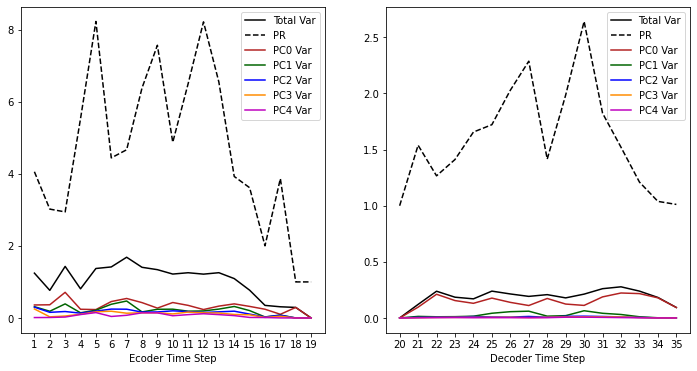

In [18]:
# Plots various variances and the participation ratio of hidden states as a function of time step 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pc_dims = 5
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

hs_time_word_enc, hs_time_word_dec = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params)

time_var = np.zeros((hs['all'][0].shape[0]))
time_pr = np.zeros((hs['all'][0].shape[0]))
time_pc_var = np.zeros((hs['all'][0].shape[0], pc_dims))

for time_idx in range(hs['all'][0].shape[0]):
  time_hs = []
  if time_idx < enc_len: # Encoder
    for word_list in hs_time_word_enc[time_idx]:
      time_hs.extend(word_list)
  else:
    for word_list in hs_time_word_dec[time_idx-enc_len]:
      time_hs.extend(word_list)
    
  time_hs = np.array(time_hs)
  pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
  _ = pca_time.fit_transform(time_hs)
  time_var[time_idx] = np.sum(pca_time.explained_variance_)
  time_pr[time_idx] = analysis.participation_ratio_vector(pca_time.explained_variance_)
  time_pc_var[time_idx] = pca_time.explained_variance_[:pc_dims]

enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
ax1.plot(enc_times, time_var[:enc_len], color='k', label='Total Var')
ax1.plot(enc_times, time_pr[:enc_len], color='k', linestyle='dashed', label='PR')
ax2.plot(dec_times, time_var[enc_len:], color='k', label='Total Var')
ax2.plot(dec_times, time_pr[enc_len:], color='k', linestyle='dashed', label='PR')
for i in range(pc_dims):
  ax1.plot(enc_times, time_pc_var[:enc_len, i], color=state_colors[i], label=f'PC{i} Var')
  ax2.plot(dec_times, time_pc_var[enc_len:, i], color=state_colors[i], label=f'PC{i} Var')

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

ax1.legend()
ax2.legend()

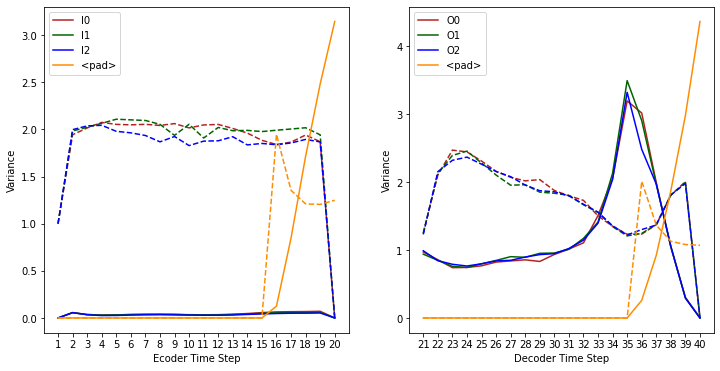

In [ ]:
# Plots variances of hidden states corresponding to individual inputs/ouput words as a function of time step 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

words = np.max([len(toy_params['in_words']), len(toy_params['out_words'])])
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
all_hs_array = np.asarray(hs['all'])

word_var = np.zeros((hs['all'][0].shape[0], words))
word_pr = np.zeros((hs['all'][0].shape[0], words))

for time_idx in range(enc_len):
  for inp_idx in range(len(toy_params['in_words_pp'])):
    time_hs = np.asarray([h for h, inp in zip(all_hs_array[:, time_idx, :], hs_data['inputs'][:, time_idx, :]) if np.argmax(inp) == inp_idx]) 
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    if time_hs.shape[0] > 0: # Sometimes it is not possible for words to appear at a certain input position
      _ = pca_time.fit_transform(time_hs)
      word_var[time_idx, inp_idx] = np.sum(pca_time.explained_variance_)
      word_pr[time_idx, inp_idx] = analysis.participation_ratio_vector(pca_time.explained_variance_)
for time_idx in range(enc_len, enc_len+dec_len):
  for out_idx in range(len(toy_params['out_words_pp'])):
    time_hs = np.asarray([h for h, out in zip(all_hs_array[:, time_idx, :], hs_data['labels'][:, time_idx - enc_len, :]) if np.argmax(out) == out_idx]) 
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    if time_hs.shape[0] > 0: # Sometimes it is not possible for words to appear at a certain output position
      _ = pca_time.fit_transform(time_hs)
      word_var[time_idx, out_idx] = np.sum(pca_time.explained_variance_)
      word_pr[time_idx, out_idx] = analysis.participation_ratio_vector(pca_time.explained_variance_)

enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
for inp_idx in range(len(toy_params['in_words_pp'])):
  ax1.plot(enc_times, word_var[:enc_len, inp_idx], color=state_colors[inp_idx], label=toy_params['in_words_pp'][inp_idx])
  ax1.plot(enc_times, word_pr[:enc_len, inp_idx], color=state_colors[inp_idx], linestyle='dashed')
for out_idx in range(len(toy_params['out_words_pp'])):
  ax2.plot(dec_times, word_var[enc_len:, out_idx], color=state_colors[out_idx], label=toy_params['out_words_pp'][out_idx])
  ax2.plot(dec_times, word_pr[enc_len:, out_idx], color=state_colors[out_idx], linestyle='dashed')

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_ylabel('Variance')
ax2.set_ylabel('Variance')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

ax1.legend()
ax2.legend()

In [ ]:
# Gets word frequencies

in_word_count = np.zeros((len(toy_params['in_words_pp'])))
out_word_count = np.zeros((len(toy_params['out_words_pp'])))

for in_idx, out_idx, input, label in zip(hs_data['in_index'], hs_data['out_index'], hs_data['inputs'], hs_data['labels']):
  in_word_count += np.sum(input[:in_idx+1], axis=0)[:len(toy_params['in_words_pp'])]
  out_word_count += np.sum(label[:out_idx+1], axis=0)[:len(toy_params['out_words_pp'])]

print('In word count:', in_word_count)
print('Out word count:', out_word_count)

In word count: [1845. 1786. 1785. 1813. 2564. 1851. 2852. 1000.]
Out word count: [2438. 2423. 2406. 1813. 2852. 1000.]


Finding average hidden state at each time step...
Finding average hidden state at each time step...
Encoder Variance reduction: 0.007117635975213271
Decoder Variance reduction: 0.005495015257909811


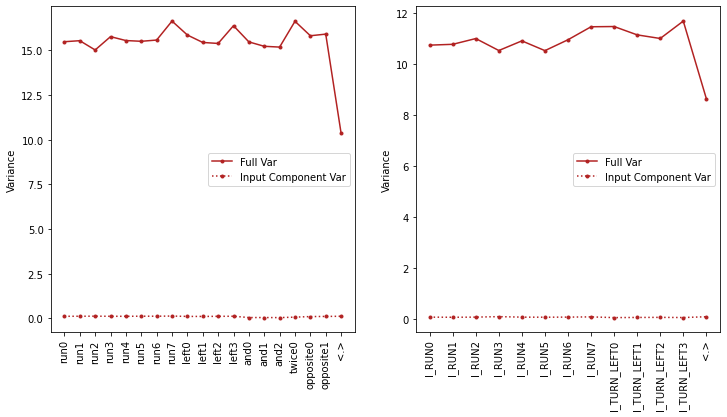

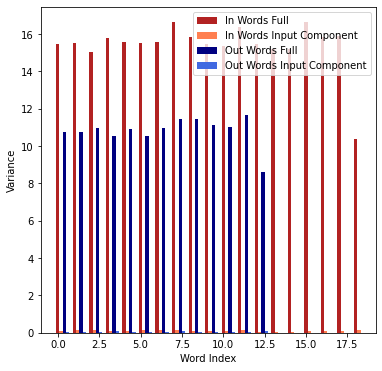

In [22]:
# Plots variance of words before and after temporal subtraction
word_var_enc, word_var_enc_nt, word_var_dec, word_var_dec_nt = analysis.var_before_after_temp(hs, hs_data, toy_params)

print('Encoder Variance reduction:', np.mean(word_var_enc_nt/word_var_enc))
print('Decoder Variance reduction:', np.mean(word_var_dec_nt/word_var_dec))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig, ax3 = plt.subplots(1, 1, figsize=(6,6))

in_words = toy_params['in_words_pp'].copy()
out_words = toy_params['out_words_pp'].copy()
# Removes pads
if '<pad>' in in_words: in_words.remove('<pad>')
if '<pad>' in out_words: out_words.remove('<pad>')

ax1.plot([i for i in range(len(in_words))], word_var_enc, marker='.', color='firebrick',  label='Full Var')
ax1.plot([i for i in range(len(in_words))], word_var_enc_nt, marker='.', color='firebrick', linestyle='dotted', label='Input Component Var')
ax1.set_ylabel('Variance')
ax1.set_xticks([i for i in range(len(in_words))])
ax1.set_xticklabels(in_words, rotation=90)
ax1.legend()

ax2.plot([i for i in range(len(out_words))], word_var_dec, marker='.', color='firebrick',  label='Full Var')
ax2.plot([i for i in range(len(out_words))], word_var_dec_nt, marker='.', color='firebrick', linestyle='dotted', label='Input Component Var')
ax2.set_ylabel('Variance')
ax2.set_xticks([i for i in range(len(out_words))])
ax2.set_xticklabels(out_words, rotation=90)
ax2.legend()

ax3.bar([i for i in range(len(in_words))], word_var_enc, width=0.2, color='firebrick',  label='In Words Full')
ax3.bar([i+0.2 for i in range(len(in_words))], word_var_enc_nt, width=0.2, color='coral', linestyle='dotted', label='In Words Input Component')
ax3.bar([i+0.4 for i in range(len(out_words))], word_var_dec, width=0.2, color='navy',  label='Out Words Full')
ax3.bar([i+0.6 for i in range(len(out_words))], word_var_dec_nt, width=0.2, color='royalblue', linestyle='dotted', label='Out Words Input Component')
ax3.set_ylabel('Variance')
ax3.set_xlabel('Word Index')
ax3.legend()

In [ ]:
max_score = (words - 1) * np.sum([words**i for i in range(enc_length)])
print('Max score', max_score)
words = len(toy_params['in_words_pp']) - 1
print(get_color_score(hs_data['inputs'][0][:enc_length], words))

Max score 242
56


Max score 242


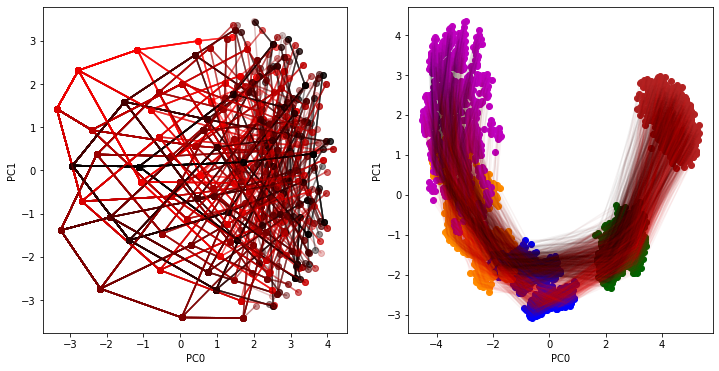

In [ ]:
# Plots hidden states up to a given index

def get_color_score(input_tensor, words):
  c_score = 0
  for time_tensor, idx in zip(input_tensor, range(input_tensor.shape[0])):
    c_score += words**(enc_length - idx - 1) * np.argmax(time_tensor)
  return c_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pc0 = 0
pc1 = 1

pc_dims = 5
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

hs_time_word_enc, hs_time_word_dec = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params)

start_idx = 0
enc_length = 5
dec_length = 5

words = len(toy_params['in_words_pp']) - 1 # distinct words
max_score = (words - 1) * np.sum([words**i for i in range(enc_length)]) # distinct phrases
print('Max score', max_score)

enc_hs_time = [[] for _ in range(enc_length)]
dec_hs_time = [[] for _ in range(dec_length)]

for time_idx in range(enc_length):
  time_hs = []
  for word_idx in range(len(toy_params['in_words_pp'])):
    time_hs.extend(hs_time_word_enc[start_idx + time_idx][word_idx])
  enc_hs_time[time_idx] = time_hs
for time_idx in range(dec_length):
  time_hs = []
  for word_idx in range(len(toy_params['out_words_pp'])+1):
    time_hs.extend(hs_time_word_dec[start_idx + time_idx][word_idx])
  dec_hs_time[time_idx] = time_hs

# Plots encoder hidden states
pca_enc = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_enc.fit(np.vstack(enc_hs_time))
# for time_idx in range(enc_length):
#   pca_time_hs = pca_enc.transform(enc_hs_time[time_idx]).T
#   ax1.scatter(pca_time_hs[pc0], pca_time_hs[pc1], color=state_colors[time_idx])
# Plots all paths
for h, inp in zip(hs['all'], hs_data['inputs']):
  pca_path = pca_enc.transform(h).T
  c_score = get_color_score(inp[:enc_length], words)
  ax1.plot(pca_path[pc0, start_idx:start_idx+enc_length], pca_path[pc1, start_idx:start_idx+enc_length], 
           color=[(max_score-c_score)/max_score,0,0], alpha=0.25, marker='o')

# Plots decoder hidden states
pca_dec = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_dec.fit(np.vstack(dec_hs_time))
for time_idx in range(dec_length):
  pca_time_hs = pca_dec.transform(dec_hs_time[time_idx]).T
  ax2.scatter(pca_time_hs[pc0], pca_time_hs[pc1], color=state_colors[time_idx])
# Plots all paths
for h, lab in zip(hs['all'], hs_data['labels']):
  pca_path = pca_dec.transform(h).T
  c_score = get_color_score(lab[:dec_length], words)
  ax2.plot(pca_path[pc0, enc_len+start_idx:enc_len+start_idx+dec_length], pca_path[pc1, enc_len+start_idx:enc_len+start_idx+dec_length], 
           color=[(max_score-c_score)/max_score,0,0], alpha=0.05)

for ax in (ax1, ax2):
  ax.set_xlabel('PC'+str(pc0))
  ax.set_ylabel('PC'+str(pc1))

#### Time Averaging

Finding average hidden state at each time step...
Encoder magnitude ratio: 13.407509633608868
Decoder magnitude ratio: 49.15856274849502
Attention matrix \ Max: 0.9999978957086995 \ Min: 6.249320779316174e-93
Attention null \ Max: 0.9807124733924866 \ Min: 0.0
Var ex ratios: [0.30713633 0.18837235 0.14513122 0.11396939 0.09847124]
PR: 4.19291965925255


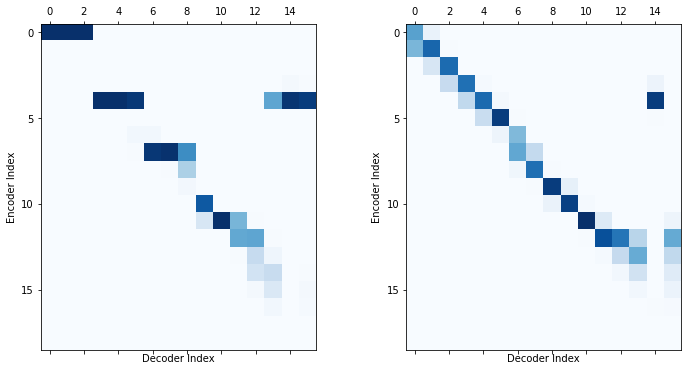

In [19]:
# Checks to see if attention matrix can be explained by average of hidden states at a given time step
from scipy.special import softmax

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)
hs_inputs = np.asarray([h - avg_hs for h in hs['all']])

att_head = 0

if rnn_specs['arch'] in ('enc_dec_attl'):
  rnn_params, rnn_params_dec, att_params, readout_params = final_params
  q_mat, k_mat, v_mat = att_params
elif rnn_specs['arch'] in ('enc_dec_attmh'):
  rnn_params, rnn_params_dec, att_params, readout_params = final_params
  q_mat, k_mat, v_mat = att_params[0][att_head]
  co_mat = att_params[1][att_head*rnn_specs['v_size']:(att_head+1)*rnn_specs['v_size'], :]

attn_align = analysis.get_attn_align(rnn_specs, final_params, head=att_head)

print('Encoder magnitude ratio:', np.mean(np.linalg.norm(avg_hs[:enc_len]))/np.mean(np.linalg.norm(hs_inputs[:, :enc_len, :], axis=2)))
print('Decoder magnitude ratio:', np.mean(np.linalg.norm(avg_hs[enc_len:]))/np.mean(np.linalg.norm(hs_inputs[:, enc_len:, :], axis=2)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# Attention matrix from mean input states
attn_matrix = np.zeros((enc_len, dec_len))
enc_seq = avg_hs[:enc_len, :]
for seq_idx in range(dec_len):
  attn_matrix[:, seq_idx] = softmax(attn_align(enc_seq, avg_hs[enc_len + seq_idx, :]))

# Attention matrix from null input
attn_matrix_null = np.zeros((enc_len, dec_len))
enc_seq = hs['special'][-1][:enc_len, :]
for seq_idx in range(dec_len):
  attn_matrix_null[:, seq_idx] = softmax(attn_align(enc_seq, hs['special'][-1][enc_len + seq_idx, :]))

print(f'Attention matrix \\ Max: {np.max(attn_matrix)} \\ Min: {np.min(attn_matrix)}')
ax1.matshow(attn_matrix, cmap=plt.cm.Blues)
ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

print(f'Attention null \\ Max: {np.max(attn_matrix_null)} \\ Min: {np.min(attn_matrix_null)}')
ax2.matshow(attn_matrix_null, cmap=plt.cm.Blues)
ax2.set_ylabel('Encoder Index')
ax2.set_xlabel('Decoder Index')

# pca_avg = PCA(n_components=np.min([avg_hs.shape[0], rnn_specs['hidden_size']]))
pca_avg = PCA(n_components=5)
_ = pca_avg.fit_transform(avg_hs[:]).T
pca_avg_hs = pca_avg.transform(avg_hs).T
pca_avg_input = pca_avg.transform(hs['special'][-1]).T
print('Var ex ratios:', pca_avg.explained_variance_ratio_[:5])
print('PR:', analysis.participation_ratio_vector(pca_avg.explained_variance_))

In [20]:
# Calculates average hidden state and subtracts it out from hidden states at all time steps to isolate word subspace
# Average hidden state does NOT include repeated <pad>'s for encoder or decoder

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

print('Using true average hidden state as temporal part')
temporal_hs = avg_hs
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]
if toy_params['var_length']:
  pad_in_idx = toy_params['in_words_pp'].index('<pad>')
  pad_out_idx = toy_params['out_words_pp'].index('<pad>')
# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - temporal_hs for h in hs['all']]

hs_inputs_bare, hs_outputs_bare = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params)
hs_inputs, hs_outputs = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=True, avg_hs=avg_hs)

# Projections for various types of learnable attention
if rnn_specs['arch'] in ('enc_dec_atth',): # No projections for dot product attention
    enc_temp_proj = np.identity(rnn_specs['hidden_size'])
    dec_temp_proj = np.identity(rnn_specs['hidden_size'])
    word_proj = np.identity(rnn_specs['hidden_size'])
elif rnn_specs['arch'] in ('enc_dec_attl',):
    enc_temp_proj = k_mat
    dec_temp_proj = q_mat
    word_proj = v_mat
elif rnn_specs['arch'] in ('enc_dec_attmh',):
    enc_temp_proj = k_mat
    dec_temp_proj = q_mat
    word_proj = np.matmul(v_mat, co_mat) # Both values and context_out projection for given head

avg_hs_holder = np.zeros((avg_hs.shape[0], rnn_specs['qk_size']))
avg_hs_holder[:enc_len] = np.matmul(avg_hs[:enc_len], enc_temp_proj)
avg_hs_holder[enc_len:] = np.matmul(avg_hs[enc_len:], dec_temp_proj)
temporal_hs = avg_hs_holder

Finding average hidden state at each time step...
Using true average hidden state as temporal part
Finding average hidden state at each time step...


Diff mean 0.5521141134835372


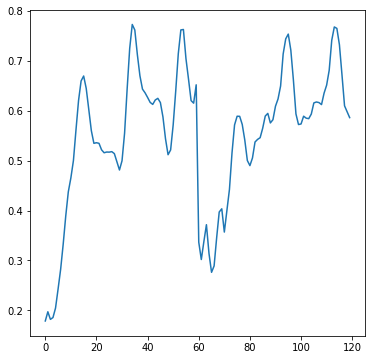

In [ ]:
null_input = hs['special'][-1]
null_diff = np.linalg.norm(avg_hs - null_input, axis=1)/np.linalg.norm(avg_hs, axis=1)
print('Diff mean', np.mean(null_diff))

fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
ax1.plot(np.arange(enc_len+dec_len), null_diff)

Var ex ratios: [5.65026269e-01 2.83272765e-01 1.32173748e-01 1.91946347e-02
 2.58700990e-04]
PR: 2.3961476813937352


IndexError: ignored

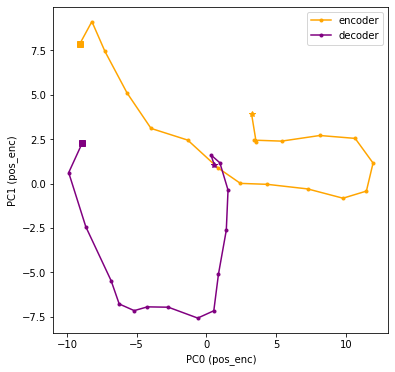

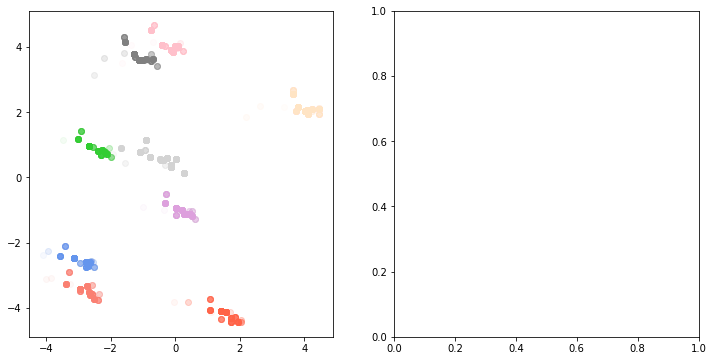

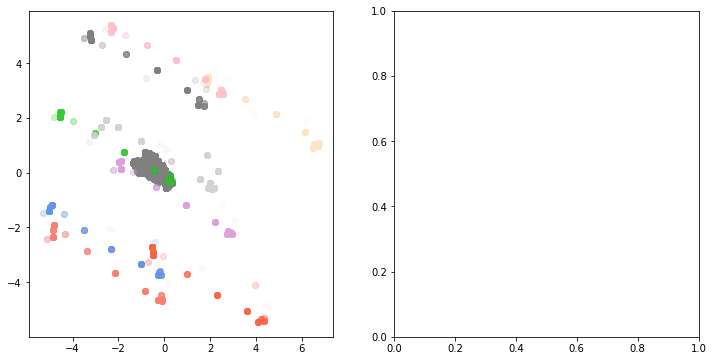

In [21]:
# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))
fig3, (ax4, ax5) = plt.subplots(1, 2, figsize=(12, 6))

##### Plotting for temporal part #####

pts_subset = 'all'

pc1 = 0
pc2 = 1

# pca_avg = PCA(n_components=5)
if pts_subset == 'enc': # Fits PCA to only enecoder hidden states
  pca_avg = PCA(n_components=np.min([temporal_hs[:enc_len].shape[0], temporal_hs.shape[1]]))
  _ = pca_avg.fit(temporal_hs[:enc_len])
  pca_avg_hs = pca_avg.transform(temporal_hs).T
elif pts_subset == 'all':
  pca_avg = PCA(n_components=np.min([temporal_hs.shape[0], temporal_hs.shape[1]]))
  pca_avg_hs = pca_avg.fit_transform(temporal_hs).T
# pca_mod_pe_hs = pca_avg.transform(np.vstack(hs_mod_pos_enc)).T
# pca_avg_input = pca_avg.transform(hs['special'][-2]).T
# pca_null_input = pca_avg.transform(hs['special'][-1]).T
print('Var ex ratios:', pca_avg.explained_variance_ratio_[:5])
print('PR:', analysis.participation_ratio_vector(pca_avg.explained_variance_))

ax1.plot(pca_avg_hs[pc1,:enc_len], pca_avg_hs[pc2,:enc_len], marker='.', color='orange', label='encoder')
ax1.plot(pca_avg_hs[pc1,enc_len:], pca_avg_hs[pc2,enc_len:], marker='.', color='purple', label='decoder')
# Squares at start of each
ax1.plot(pca_avg_hs[pc1,0], pca_avg_hs[pc2,0], marker='s', color='orange')
ax1.plot(pca_avg_hs[pc1,enc_len], pca_avg_hs[pc2,enc_len], marker='s', color='purple')
# Stars at the end
ax1.plot(pca_avg_hs[pc1,enc_len-1], pca_avg_hs[pc2,enc_len-1], marker='*', color='orange')
ax1.plot(pca_avg_hs[pc1,-1], pca_avg_hs[pc2,-1], marker='*', color='purple')

# ax1.plot(pca_avg_input[pc1,:enc_len], pca_avg_input[pc2,:enc_len], color='orange', linestyle='dashed', label='encoder (avg inp)')
# ax1.plot(pca_avg_input[pc1,enc_len:], pca_avg_input[pc2,enc_len:], color='purple', linestyle='dashed', label='decoder (avg inp)')
# ax1.plot(pca_null_input[pc1,:enc_len], pca_null_input[pc2,:enc_len], color='red', linestyle='dashed', label='encoder (zero inp)')
# ax1.plot(pca_null_input[pc1,enc_len:], pca_null_input[pc2,enc_len:], color='green', linestyle='dashed', label='decoder (zero inp)')
ax1.legend()

ax1.set_xlabel('PC'+str(pc1)+' (pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (pos_enc)')

# # Plots readout direction
# readout_types = ['att',]  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_color_idxs = [0, 1, 2, 3, 6, 7]
# ro_styles = ['solid', 'solid', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   # pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((2*rnn_specs['hidden_size'],)))).T

#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[ro_color_idxs[i]], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

##### Plotting for word part #####

pts_subset = 'all'

pc1 = 0
pc2 = 1

alpha_s = 0.05

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])
if pts_subset == 'enc': # Fits PCA to only enecoder hidden states
    _ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
    pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T
elif pts_subset == 'all':
    pca_mod_pe_hs = pca_mod_pe.fit_transform(np.matmul(np.vstack(hs_mod_pos_enc), word_proj)).T
pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
# ax2.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
ax4.scatter(pca_hs[pc1], pca_hs[pc2], color='grey')
for inp_idx in range(len(toy_params['in_words_pp'])):
  hs_word = []
  hs_word_bare = []
  for time_idx in range(enc_len):
    hs_word.extend(hs_inputs[time_idx][inp_idx])
    hs_word_bare.extend(hs_inputs_bare[time_idx][inp_idx])
  hs_word_bare = np.matmul(np.array(hs_word_bare), word_proj)
  hs_word = np.matmul(np.array(hs_word), word_proj)
  pca_mod_pe_word = pca_mod_pe.transform(hs_word).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors_light[inp_idx], alpha=alpha_s,
              label=toy_params['in_words'][inp_idx])
  pca_word = pca_mod_pe.transform(hs_word_bare).T
  ax4.scatter(pca_word[pc1], pca_word[pc2], color=state_colors_light[inp_idx], alpha=alpha_s,
              label=toy_params['in_words'][inp_idx])
for out_idx in range(len(toy_params['out_words_pp'])):
  hs_word = []
  for time_idx in range(dec_len):
    hs_word.extend(hs_outputs[time_idx][out_idx])
  hs_word = np.array(hs_word)
  pca_mod_pe_word = pca_mod_pe.transform(hs_word).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[out_idx], alpha=alpha_s)


ax3.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
ax5.scatter(pca_hs[pc1], pca_hs[pc2], color='grey')
for out_idx in range(len(toy_params['out_words_pp'])):
  hs_word = []
  hs_word_bare = []
  for time_idx in range(dec_len):
    hs_word.extend(hs_outputs[time_idx][out_idx])
    hs_word_bare.extend(hs_outputs_bare[time_idx][out_idx])
  hs_word = np.array(hs_word)
  hs_word_bare = np.array(hs_word_bare)
  pca_mod_pe_word = pca_mod_pe.transform(hs_word).T
  ax3.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])
  pca_word = pca_mod_pe.transform(hs_word_bare).T
  ax5.scatter(pca_word[pc1], pca_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])

# Average directions of hidden states for encoder/decoder (used to project readouts)
avg_enc = np.mean(temporal_hs[:enc_len], axis=0)
avg_dec = np.mean(temporal_hs[enc_len:], axis=0)
avg_enc_dir = avg_enc/(np.linalg.norm(avg_enc))
avg_dec_dir = avg_dec/(np.linalg.norm(avg_dec))

# Plots readout direction
readout_types = ['att',]  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  pca_ro = pca_mod_pe.transform(readout_plot)
  pca_zero = pca_mod_pe.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
  # pca_zero = pca_mod_pe.transform(np.atleast_2d(np.zeros((2*rnn_specs['hidden_size'],)))).T
  for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    for ax in [ax2, ax3, ax4, ax5]:
      ax.plot(x_ro, y_ro, color=state_colors[ro_color_idxs[i]], linewidth = 3, linestyle=ro_styles[idx],
              label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in [ax2, ax3, ax4, ax5]:
  ax.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
  ax.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

for ax in [ax1, ax2]:
  plt_lim = None
  if plt_lim != None:
    ax.xlim(-plt_lim, plt_lim)
    ax.ylim(-plt_lim, plt_lim)

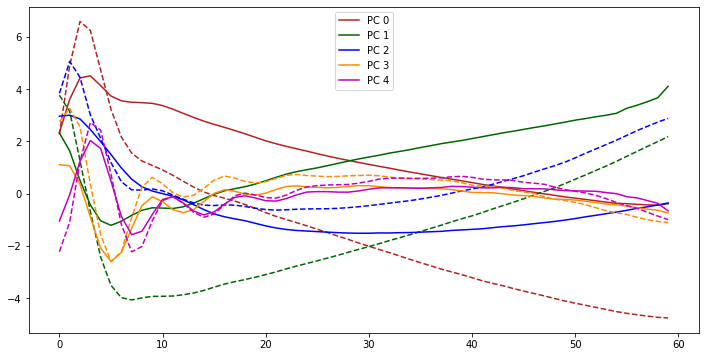

In [ ]:
pcs = 5
fig, ax1 = plt.subplots(1,1, figsize=(12,6))

for pc_idx in range(pcs):
  # ax1.plot(pca_null_input[pc_idx,:enc_len], color=state_colors[pc_idx], linestyle='solid', label='PC '+str(pc_idx))
  # ax1.plot(pca_null_input[pc_idx,enc_len:],  color=state_colors[pc_idx], linestyle='dashed')
  ax1.plot(pca_avg_hs[pc_idx,:enc_len], color=state_colors[pc_idx], linestyle='solid', label='PC '+str(pc_idx))
  ax1.plot(pca_avg_hs[pc_idx,enc_len:],  color=state_colors[pc_idx], linestyle='dashed')


ax1.legend()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


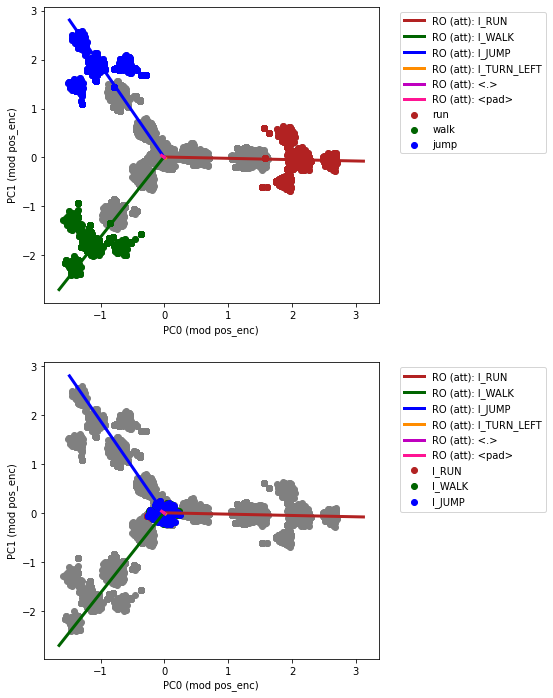

In [ ]:
# Plot using a more specific PCA

fig2, (ax2, ax3) = plt.subplots(2, 1, figsize=(6, 12))

words_in_pca = ['run', 'walk', 'jump']
words_in_pca_idxs = [toy_params['in_words_pp'].index(word) for word in words_in_pca]
pca_list = []
for inp_idx in words_in_pca_idxs:
  pca_list = pca_list + hs_inputs[inp_idx]

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_mod_pe.fit(np.vstack(np.asarray(pca_list)))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

ax2.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
# for inp_idx in range(len(toy_params['in_words_pp'])):
for inp_idx in words_in_pca_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_inputs[inp_idx])).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])

ax3.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
# for out_idx in range(len(toy_params['out_words_pp'])):
for out_idx in words_in_pca_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_outputs[out_idx])).T
  ax3.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])

# Plots readout direction
readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  pca_ro = pca_mod_pe.transform(readout_plot)
  pca_zero = pca_mod_pe.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
  for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    for ax in [ax2, ax3, ax4, ax5]:
      ax.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
              label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in [ax2, ax3]:
  ax.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
  ax.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

In [25]:
ic_enc.shape

(8, 128)

Finding average hidden state at each time step...
Finding average hidden state at each time step...


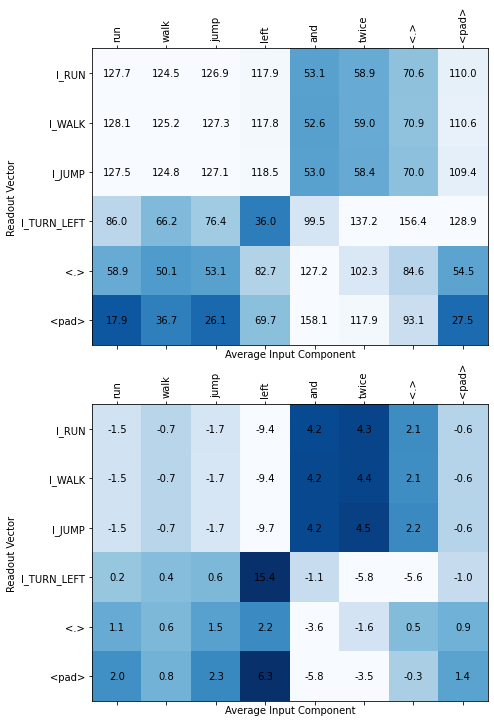

In [27]:
# Plots alignments between readout vectors and input components

att_head = 0

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# hs_time_word_enc_ic, hs_time_word_dec_ic = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=False)
# hs_time_word_enc_ic, hs_time_word_dec_ic = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=True)
avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

ic_enc, ic_dec = analysis.calculate_input_components(hs, hs_data, toy_params, rnn_specs)

readout_avg_aligns = np.zeros((readout.shape[0], len(toy_params['in_words_pp'])))
readout_avg_dots = np.zeros((readout.shape[0], len(toy_params['in_words_pp'])))

# Projections for various types of learnable attention
if rnn_specs['arch'] in ('enc_dec_atth',): # No projections for dot product attention
    word_proj = np.identity(rnn_specs['hidden_size'])
elif rnn_specs['arch'] in ('enc_dec_attl',):
    _, _, att_params, _ = final_params
    _, _, v_mat = att_params
    word_proj = v_mat
elif rnn_specs['arch'] in ('enc_dec_attmh',):
    _, _, att_params, _ = final_params
    _, _, v_mat = att_params[0][att_head]
    co_mat = att_params[1][att_head*rnn_specs['v_size']:(att_head+1)*rnn_specs['v_size'], :]
    word_proj = np.matmul(v_mat, co_mat) # Both values and context_out projection for given head

ic_enc = np.matmul(ic_enc, word_proj) 

for ro_idx in range(readout.shape[0]):
  for word_idx in range(len(toy_params['in_words_pp'])):
    readout_avg_aligns[ro_idx, word_idx] = analysis.angle_degrees(readout[ro_idx], ic_enc[word_idx])
    readout_avg_dots[ro_idx, word_idx] = np.dot(readout[ro_idx], ic_enc[word_idx])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12))

ax1.matshow(readout_avg_aligns, cmap=plt.cm.Blues_r, vmin= 0, vmax=120)
ax2.matshow(readout_avg_dots, cmap=plt.cm.Blues, vmin= -3, vmax=5)

for i in range(readout_avg_aligns.shape[1]):
  for j in range(readout_avg_aligns.shape[0]):
    c = readout_avg_aligns[j,i]
    ax1.text(i, j, str(round(c, 1)), va='center', ha='center')
    c = readout_avg_dots[j,i]
    ax2.text(i, j, str(round(c, 1)), va='center', ha='center')

for ax in (ax1, ax2):
  ax.set_xticks([i for i in range(len(toy_params['in_words_pp']))])
  ax.set_xticklabels(toy_params['in_words_pp'], rotation=90)
  ax.set_yticks([i for i in range(len(toy_params['out_words_pp']))])
  ax.set_yticklabels(toy_params['out_words_pp'], rotation=0)
  ax.set_ylabel('Readout Vector')
  ax.set_xlabel('Average Input Component')

Using true average hidden state as temporal part


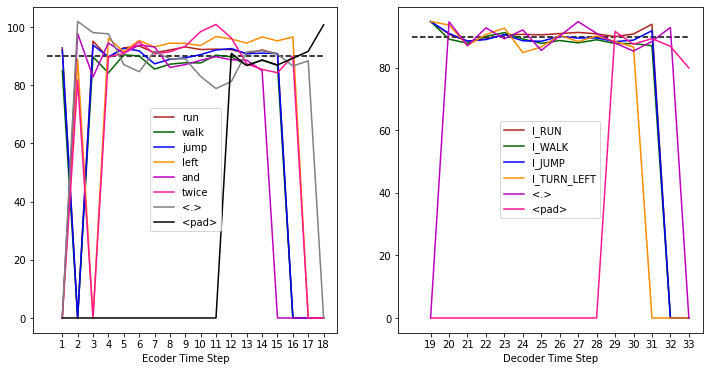

In [ ]:

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

print('Using true average hidden state as temporal part')
temporal_hs = avg_hs
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>')

avg_angle_enc = np.zeros((len(toy_params['in_words_pp']), enc_len))
avg_angle_dec = np.zeros((len(toy_params['out_words_pp']), dec_len))

for time_idx in range(enc_len): # Encoder
  time_hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
  for h, inp in zip(hs['all'], hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        time_hs_word[np.argmax(inp[time_idx])].append(h[time_idx])
    else: # Automatically adds if first index
      time_hs_word[np.argmax(inp[time_idx])].append(h[time_idx])
  for word_idx in range(len(time_hs_word)):
    if len(time_hs_word[word_idx]) > 0:
      time_word_array = np.asarray(time_hs_word[word_idx])
      angles = np.asarray([angle_degrees(hid - temporal_hs[time_idx], temporal_hs[time_idx]) for hid in time_word_array])
      # angles = np.asarray([proj_perc(hid - temporal_hs[time_idx], temporal_hs[time_idx]) for hid in time_word_array])
      avg_angle_enc[word_idx, time_idx] = np.mean(angles, axis=0)
for time_idx in range(dec_len): # Decoder
  time_hs_word = [[] for _ in range(len(toy_params['out_words_pp']))]
  for h, out in zip(hs['all'], hs_data['labels']):
    if time_idx > 0:
      if np.argmax(out[time_idx]) != pad_out_idx or np.argmax(out[time_idx-1]) != pad_out_idx:
        time_hs_word[np.argmax(out[time_idx])].append(h[enc_len + time_idx])
    else: # Automatically adds if first index
      time_hs_word[np.argmax(out[time_idx])].append(h[enc_len + time_idx])
  for word_idx in range(len(time_hs_word)):
    if len(time_hs_word[word_idx]) > 0:
      time_word_array = np.asarray(time_hs_word[word_idx])
      # if (time_word_array == temporal_hs[enc_len + time_idx]).any():
      #   raise ValueError('Output is same as null')
      angles = np.asarray([angle_degrees(hid - temporal_hs[enc_len + time_idx], temporal_hs[enc_len + time_idx]) for hid in time_word_array])
      # angles = np.asarray([proj_perc(hid - temporal_hs[enc_len + time_idx], temporal_hs[enc_len + time_idx]) for hid in time_word_array])
      avg_angle_dec[word_idx, time_idx] = np.mean(angles, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
for word_idx in range(len(toy_params['in_words_pp'])):
  ax1.plot(enc_times, avg_angle_enc[word_idx], color=state_colors[word_idx], label=toy_params['in_words_pp'][word_idx])
for word_idx in range(len(toy_params['out_words_pp'])):
  ax2.plot(dec_times, avg_angle_dec[word_idx], color=state_colors[word_idx], label=toy_params['out_words_pp'][word_idx])

ax1.hlines(90.0, 0, enc_len, color='k', linestyle='dashed')
ax2.hlines(90.0, enc_len, enc_len+dec_len, color='k', linestyle='dashed')
ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

# ax1.set_ylim([80, 100])
# ax2.set_ylim([80, 100])

ax1.legend()
ax2.legend()

Example phrase length: 18
Example phrase: ['I0', 'I1', 'I0', 'I1', 'I1', 'I0', 'I1', 'I0', 'I2', 'I0', 'I0', 'I2', 'I1', 'I1', 'I1', 'I0', 'I0', 'I0', '<pad>', '<pad>']


Text(0, 0.5, 'PC2 (pos_enc)')

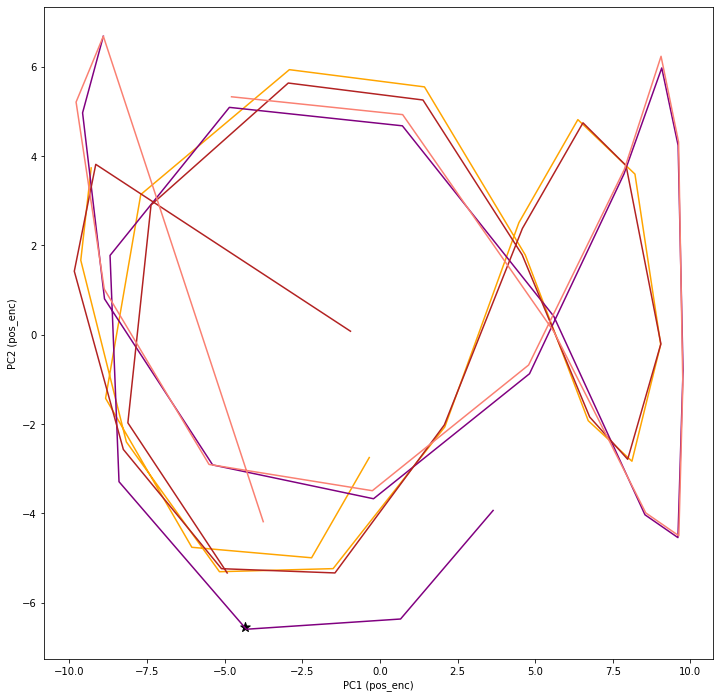

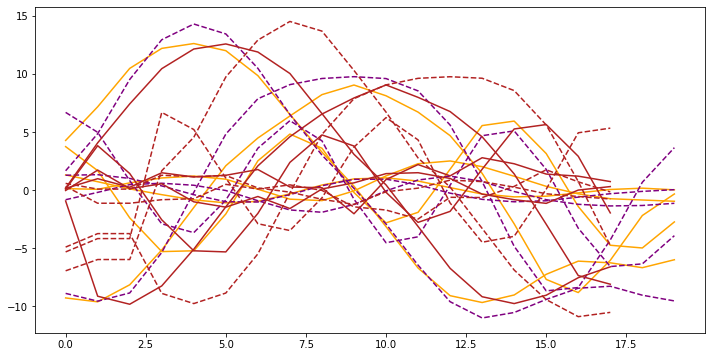

In [63]:
# Plots the temporal components and some example paths

pts_subset = 'all'

fig1, ax1 = plt.subplots(1, 1, figsize=(12, 12))
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
pcs = 5
pc1 = 1
pc2 = 2

h0 = cell.get_initial_state(rnn_params)[:rnn_specs['hidden_size']]

if pts_subset in ['all', 'enc']:
  ax1.plot(pca_avg_hs[pc1,:enc_len], pca_avg_hs[pc2,:enc_len], color='orange', label='encoder')
  # ax1.plot(pca_avg_input[pc1,:enc_len], pca_avg_input[pc2,:enc_len], color='orange', linestyle='dashed', label='encoder (avg inp)')
  for pc_idx in range(pcs):
    ax2.plot(np.arange(enc_len), pca_avg_hs[pc_idx,:enc_len], color='orange')
if pts_subset in ['all', 'dec', 'enc']:
  ax1.plot(pca_avg_hs[pc1,enc_len:], pca_avg_hs[pc2,enc_len:], color='purple', label='decoder')
  # ax1.plot(pca_avg_input[pc1,enc_len:], pca_avg_input[pc2,enc_len:], color='purple', linestyle='dashed', label='decoder (avg inp)')
  for pc_idx in range(pcs):
    ax2.plot(np.arange(dec_len), pca_avg_hs[pc_idx,enc_len:], linestyle='dashed', color='purple')

pca_h0 = pca_avg.transform(np.atleast_2d(np.matmul(h0, enc_temp_proj))).T

hs_idxs = [3,] # [0]
for hs_idx in hs_idxs: # Plots example paths
    ipl = hs_data['in_index'][hs_idx] # Input phrase length
    opl = hs_data['out_index'][hs_idx] # Output phrase length
    print('Example phrase length:', ipl)
    print('Example phrase:', toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    if pts_subset in ('enc',):
        proj_path = np.matmul(hs[pts_subset][hs_idx][:enc_len], enc_temp_proj)
    elif pts_subset in ('all',): 
        proj_path = np.matmul(hs[pts_subset][hs_idx][:enc_len], enc_temp_proj)
        proj_path = np.concatenate((proj_path, np.matmul(hs[pts_subset][hs_idx][enc_len:], dec_temp_proj)), axis=0)
        pca_state = np.concatenate((pca_h0, pca_avg.transform(proj_path).T), axis=1) 
    if pts_subset in ['dec', 'all']:  # Puts star on final hidden state
        pca_decf = pca_avg.transform(np.atleast_2d(np.matmul(hs['decf'][hs_idx], dec_temp_proj))).T
        ax1.scatter(pca_decf[pc1], pca_decf[pc2], color = 'k', marker='*', 
                    s=100.0, alpha=1.0)
    if pts_subset == 'all':
        ax1.plot(pca_state[pc1][:ipl+1], pca_state[pc2][:ipl+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
                    label=toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
        ax1.plot(pca_state[pc1][ipl+1:ipl+opl], pca_state[pc2][ipl+1:ipl+opl], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
        for pc_idx in range(pcs):
            ax2.plot(np.arange(ipl), pca_state[pc_idx][:ipl], linestyle='solid', color=state_colors[hs_idxs.index(hs_idx)])
            ax2.plot(np.arange(opl), pca_state[pc_idx][ipl:ipl+opl], linestyle='dashed', color=state_colors[hs_idxs.index(hs_idx)])
    else:
        ax1.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker='.', alpha=0.5, 
                label=toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    
# Special inputs
pos_enc_idxs = []
for pos_enc_idx in pos_enc_idxs:
  if pts_subset in ['all']: # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca_avg.transform(hs['pos_enc'][pos_enc_idx]).T), axis=1)
    ax1.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], 
             marker=None, alpha=1.0, label='Input:' + toy_params['in_words'][pos_enc_idx])
    ax1.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[pos_enc_idxs.index(pos_enc_idx)],
             marker=None, alpha=1.0)
  elif pts_subset in ['enc']: # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca_avg.transform(hs['special'][pos_enc_idx][:enc_len]).T), axis=1)
    ax1.plot(pca_state[pc1], pca_state[pc2], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], marker='.', 
             alpha=0.5, label='Input:' + toy_params['in_words'][pos_enc_idx]) 

# ax1.legend()
ax1.set_xlabel('PC'+str(pc1)+' (pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (pos_enc)')

Finding average hidden state at each time step...


IndexError: ignored

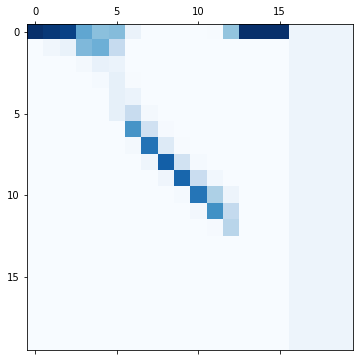

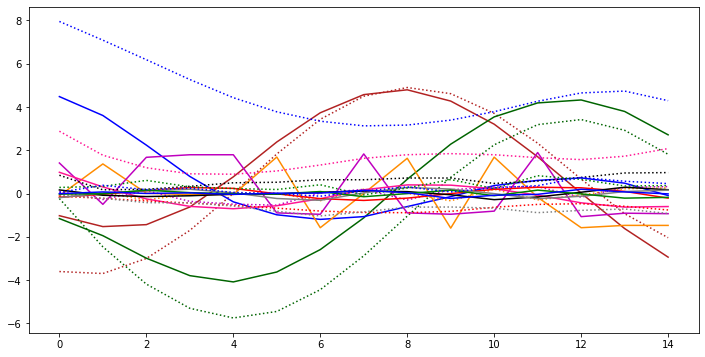

In [ ]:
# Sees what the attention matrix looks like only considering a subset of PC dimensions

pcs = 5
pc_dims = np.arange(30)

hs_idx = 5

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

# # Fits to temporal PCA (encoder only here)
# pca_avg = PCA(n_components=np.min([temporal_hs[:enc_len].shape[0], rnn_specs['hidden_size']]))
# _ = pca_avg.fit(temporal_hs[:enc_len])
# pca_path = pca_avg.transform(hs['all'][hs_idx]).T

# Fits to PCA over all encoder hidden states
pca_hs = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_hs.fit(np.vstack(hs['enc']))
pca_path = pca_hs.transform(hs['all'][hs_idx]).T

ipl = hs_data['in_index'][hs_idx] # Input phrase length
opl = hs_data['out_index'][hs_idx] # Output phrase length

attention_matrix = np.zeros((enc_len, dec_len))

for dec_idx in range(dec_len):
  # From all vaulues in pc_dims, calculates the attention matix
  for pc_val, idx in enumerate(pc_dims):
    if dec_idx > opl: # Pads other dimensions
      attention_matrix[:, dec_idx] = -10000 * np.ones((enc_len))
    else:  
      attention_matrix[:ipl+1, dec_idx] += pca_path[pc_val][:ipl+1] * pca_path[pc_val][enc_len+dec_idx]
  # Adds mask values
  attention_matrix[ipl+1:, dec_idx] = -10000 * np.ones((enc_len - ipl - 1))

attention_matrix = softmax(attention_matrix, axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig, ax2 = plt.subplots(1, 1, figsize=(12, 6))

ax1.matshow(attention_matrix, cmap=plt.cm.Blues)
for pc_val in pc_dims:
  ax2.plot(np.arange(ipl), pca_path[pc_val][:ipl], color=state_colors[pc_val])
  ax2.plot(np.arange(opl), pca_path[pc_val][enc_len:enc_len+opl], color=state_colors[pc_val], linestyle='dotted')

In [ ]:
np.vstack(hs['enc']).shape

(60000, 128)

In [ ]:
# Analyzing average encoder/decoder hidden states without he time-average
avg_word_vec_enc = np.asarray(list(map(lambda l: np.mean(np.asarray(l), axis=0), hs_inputs)))
avg_word_vec_dec = np.asarray(list(map(lambda l: np.mean(np.asarray(l), axis=0), hs_outputs)))

enc_vec_mags = []
for i in range(avg_word_vec_enc.shape[0]):
  enc_vec_mags.append(np.linalg.norm(avg_word_vec_enc[i]))
  print(f'Encoder vec {i} mag:', enc_vec_mags[i])
dec_vec_mags = []
for i in range(avg_word_vec_dec.shape[0]):
  dec_vec_mags.append(np.linalg.norm(avg_word_vec_dec[i]))
  print(f'Decoder vec {i} mag:', dec_vec_mags[i])

for i in range(avg_word_vec_enc.shape[0]):
  for j in range(i):
    print('Enc Angle ({}, {}):'.format(toy_params['in_words'][i], toy_params['in_words'][j]), 180/np.pi * np.arccos(np.dot(avg_word_vec_enc[i], avg_word_vec_enc[j])/(enc_vec_mags[i]*enc_vec_mags[j])))
for i in range(avg_word_vec_dec.shape[0]):
  for j in range(i):
    print('Dec Angle ({}, {}):'.format(toy_params['out_words'][i], toy_params['out_words'][j]), 180/np.pi * np.arccos(np.dot(avg_word_vec_dec[i], avg_word_vec_dec[j])/(dec_vec_mags[i]*dec_vec_mags[j])))

ro_subspace_analysis(avg_word_vec_enc)
ro_subspace_analysis(avg_word_vec_dec)


Encoder vec 0 mag: 2.480907242977628
Encoder vec 1 mag: 2.563709742418082
Encoder vec 2 mag: 3.1087776445854067
Encoder vec 3 mag: 2.4286292188779766
Encoder vec 4 mag: 1.6385918977157738
Encoder vec 5 mag: 2.8367859323494153
Decoder vec 0 mag: 0.5900644340770043
Decoder vec 1 mag: 0.5797797786816894
Decoder vec 2 mag: 0.5744389197076835
Decoder vec 3 mag: 1.3642710648103895
Decoder vec 4 mag: 0.874456118155978
Decoder vec 5 mag: 0.8538030736276189
Decoder vec 6 mag: 0.5616385893311335
Enc Angle (walk, run): 98.65153220416849
Enc Angle (exercise, run): 103.67359581231544
Enc Angle (exercise, walk): 108.19445166500758
Enc Angle (left, run): 88.0109383130951
Enc Angle (left, walk): 91.84856906315059
Enc Angle (left, exercise): 97.01232867766201
Enc Angle (<.>, run): 109.59557601914719
Enc Angle (<.>, walk): 102.56206001875826
Enc Angle (<.>, exercise): 105.09181200032906
Enc Angle (<.>, left): 133.311673722844
Enc Angle (<pad>, run): 84.8881621597011
Enc Angle (<pad>, walk): 77.545603892

NameError: ignored

Finding average hidden state at each time step...
Finding average hidden state at each time step...
Dot ratio for temp_temp:  0.8201880247014156
Dot ratio for temp_inp:  0.11589092328531565
Dot ratio for temp_del:  0.024356987489156774
Dot ratio for inp_temp:  0.031064023117648037
Dot ratio for inp_inp:  0.0015334027678956046
Dot ratio for inp_del:  0.00035547857665263195
Dot ratio for del_temp:  0.005470873616673198
Dot ratio for del_inp:  0.0009087192378930957
Dot ratio for del_del:  0.0002315672073494181


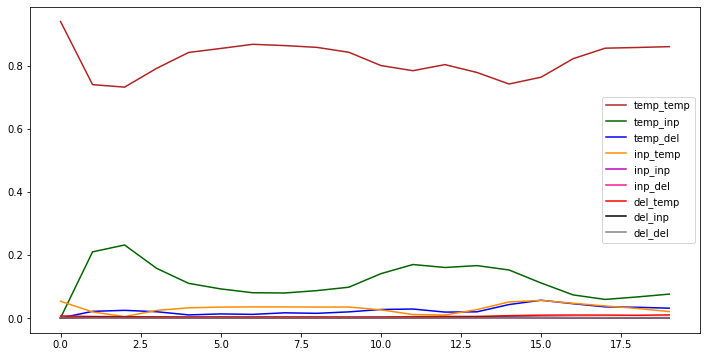

In [130]:
# Calculate alignments by hand via hidden states and then decomposes maxiumum dot product

from scipy.special import softmax
# order is enc_dec, so temp_del = enc_temp.dec_del
dot_keys = ['temp_temp', 'temp_inp', 'temp_del', 'inp_temp', 'inp_inp', 'inp_del', 'del_temp', 'del_inp', 'del_del']

att_head = 0 # This isn't used unless multiheaded

attn_align = analysis.get_attn_align(rnn_specs, final_params, head=att_head)
align_values = analysis.find_align_breakdown(hs, hs_data, attn_align, toy_params, rnn_specs)
dot_ratio_vals = analysis.calculate_dot_ratios(align_values, 5, hs_data)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
for dot_key, idx in zip(dot_keys, range(len(dot_keys))):
  ax1.plot(np.arange(dec_len), dot_ratio_vals[idx], label=dot_key, color=state_colors[idx])
  print(f'Dot ratio for {dot_key}: ', np.mean(dot_ratio_vals[idx]))

# plot_idxs = [1, 2, 3]
# for plot_idx in plot_idxs:
#   ax1.plot(np.arange(dec_len), dot_ratio_vals[plot_idx], label=str(list(dot_keys)[plot_idx]), color=state_colors[plot_idx])
# ax1.plot(np.arange(dec_len), dot_ratio_vals[1]+dot_ratio_vals[2]+dot_ratio_vals[3], label='temp_enc', color=state_colors[4])
ax1.legend()

Full dot: 1.0
Temporal dot: 1.0035775632550021
Word dot: -0.010569586188136993
Enc time . dec inp: 0.00048197750780037995
Enc inp . dec time: -0.004700505321126664
Enc lo . dec time: 0.011210666559783995


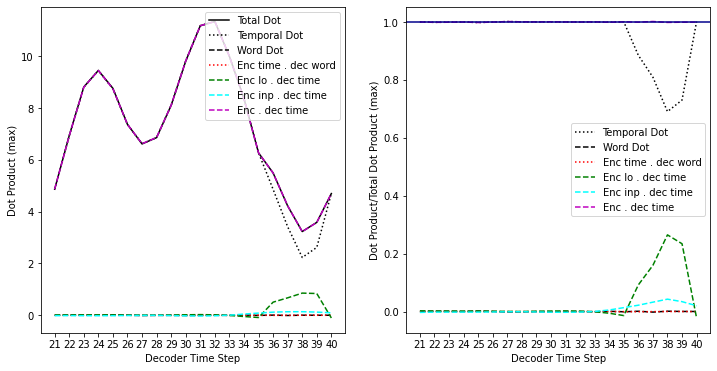

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plt_type = 'max' # 'diag'
plt_idx = 0 if plt_type == 'max' else 1

# For max alignment, gets average value
full_dots = np.zeros((dec_len))
time_dots = np.zeros((dec_len))
input_dots = np.zeros((dec_len))
enc_lo_dec_time = np.zeros((dec_len))
enc_time_dec_inp = np.zeros((dec_len))
enc_inp_dec_time = np.zeros((dec_len))

full_dot = []
time_dot = []
input_dot = []
enc_lo_dec_time_dot = []
enc_inp_dec_time_dot = []
enc_time_dec_inp_dot = []
for h_idx in range(len(enc_dec_dots)):
  seq_len = len(enc_dec_dots[h_idx])
  for seq_idx in range(seq_len):
    for align_idx in range(num_aligns):
      full_dot.append(enc_dec_dots[h_idx][seq_idx][align_idx])
      time_dot.append(enct_dect[h_idx][seq_idx][align_idx])
      input_dot.append(encw_decw[h_idx][seq_idx][align_idx])
      enc_lo_dec_time_dot.append(enclo_dect[h_idx][seq_idx][align_idx])
      enc_time_dec_inp_dot.append(enct_decw[h_idx][seq_idx][align_idx])
      enc_inp_dec_time_dot.append(enci_dect[h_idx][seq_idx][align_idx])

print('Full dot:', np.mean(full_dot)/np.mean(full_dot))
print('Temporal dot:', np.mean(time_dot)/np.mean(full_dot))
print('Word dot:', np.mean(input_dot)/np.mean(full_dot))
print('Enc time . dec inp:', np.mean(enc_time_dec_inp_dot)/np.mean(full_dot))
print('Enc inp . dec time:', np.mean(enc_inp_dec_time_dot)/np.mean(full_dot))
print('Enc lo . dec time:', np.mean(enc_lo_dec_time_dot)/np.mean(full_dot))

for seq_idx in range(dec_len):
  full_dots[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in enc_dec_dots if seq_idx < len(h_seq)]))
  time_dots[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in enct_dect if seq_idx < len(h_seq)]))
  input_dots[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in encw_decw if seq_idx < len(h_seq)]))
  enc_lo_dec_time[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in enclo_dect if seq_idx < len(h_seq)]))
  enc_time_dec_inp[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in enct_decw if seq_idx < len(h_seq)]))
  enc_inp_dec_time[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in enci_dect if seq_idx < len(h_seq)]))

dec_times = [i+1+enc_len for i in range(dec_len)]
ax1.plot(dec_times, full_dots, color='k', label='Total Dot')
ax1.plot(dec_times, time_dots, color='k', linestyle='dotted', label='Temporal Dot')
ax1.plot(dec_times, input_dots, color='k', linestyle='dashed', label='Word Dot')
ax1.plot(dec_times, enc_time_dec_inp, color='r', linestyle='dotted', label='Enc time . dec word')
ax1.plot(dec_times, enc_lo_dec_time, color='g', linestyle='dashed', label='Enc lo . dec time')
ax1.plot(dec_times, enc_inp_dec_time, color='cyan', linestyle='dashed', label='Enc inp . dec time')
ax1.plot(dec_times, time_dots + enc_lo_dec_time + enc_inp_dec_time, color='m', linestyle='dashed', label='Enc . dec time')

ax2.plot(dec_times, time_dots/full_dots, color='k', linestyle='dotted', label='Temporal Dot')
ax2.plot(dec_times, input_dots/full_dots, color='k', linestyle='dashed', label='Word Dot')
ax2.plot(dec_times, enc_time_dec_inp/full_dots, color='r', linestyle='dotted', label='Enc time . dec word')
ax2.plot(dec_times, enc_lo_dec_time/full_dots, color='g', linestyle='dashed', label='Enc lo . dec time')
ax2.plot(dec_times, enc_inp_dec_time/full_dots, color='cyan', linestyle='dashed', label='Enc inp . dec time')
ax2.plot(dec_times, (time_dots + enc_lo_dec_time + enc_inp_dec_time)/full_dots, color='m', linestyle='dashed', label='Enc . dec time')

ax1.set_xlabel('Decoder Time Step')
ax1.set_ylabel(f'Dot Product ({plt_type})')
ax1.set_xticks(dec_times)

ax2.set_xlabel('Decoder Time Step')
ax2.set_ylabel(f'Dot Product/Total Dot Product ({plt_type})')
ax2.set_xticks(dec_times)
ax2.axhline(1.0, color='darkblue')

ax1.legend()
ax2.legend()

In [ ]:
# For the top alignments, see how much of hidden states are well explained by certain components.

from scipy.special import softmax

print('Using true average hidden state as temporal part')
temporal_hs = analysis.find_avg_hs(hs, hs_data, toy_params)
ic_enc, ic_dec = analysis.calculate_input_componets(hs, hs_data, toy_params, rnn_specs)
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]

enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]

num_aligns = 5 # Number of top alignments to take
# Nested list of length n_trials, dec_seq_length for given trial, num_aligns
enc_temp = [[] for _ in range(len(hs['all']))]
enc_temp_inp = [[] for _ in range(len(hs['all']))]

for h, h_idx, inp, in_idx, out_idx in zip(hs['all'], range(len(hs['all'])), hs_data['inputs'], hs_data['in_index'], hs_data['out_index']):
  enc_seq = h[:enc_len]

  # Builds encoder hs phrase from input components
  enc_phrase_input_idxs = np.argmax(inp, axis=1)
  enc_ic_h = np.zeros((enc_len, rnn_specs['hidden_size']))
  for enc_idx in range(enc_len):
    enc_ic_h[enc_idx] = ic_enc[enc_phrase_input_idxs[enc_idx]]

  for seq_idx in range(out_idx+1): #+1 to include out_idx in attention
    raw_aligns = np.dot(enc_seq, h[enc_len + seq_idx])
    # Masks if beyond in_index length
    raw_aligns[in_idx+1:] = -10000 * np.ones((enc_len - in_idx-1))

    max_idxs = np.argpartition(raw_aligns, -num_aligns)[-num_aligns:] # Gets top indices
    max_idx_sort = raw_aligns[max_idxs].argsort()[::-1] # Sorts top indices by size
    max_idxs = max_idxs[max_idx_sort]

    lo_enc = enc_seq[max_idxs] - temporal_hs[max_idxs] - enc_ic_h[max_idxs] # (num_aligns, hidden size)
    inp_enc = enc_ic_h[max_idxs]
    word_dec = h[enc_len + seq_idx] - temporal_hs[enc_len + seq_idx]
    
    enc_t_diff = enc_seq[max_idxs] - temporal_hs[max_idxs]
    enc_temp[h_idx].append(np.linalg.norm(enc_t_diff, axis=0)/np.linalg.norm(enc_seq[max_idxs], axis=0))
    enc_ti_diff = enc_seq[max_idxs] - temporal_hs[max_idxs] - enc_ic_h[max_idxs]
    enc_temp_inp[h_idx].append(np.linalg.norm(enc_ti_diff, axis=0)/np.linalg.norm(enc_seq[max_idxs], axis=0))

print('Done!')

Using true average hidden state as temporal part
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Done!


Temporal diff: 0.1661870838002656
Temporal+Input diff: 0.06878103650893526


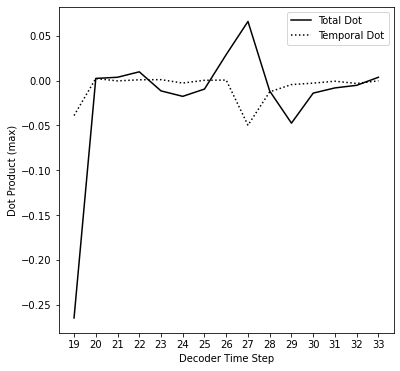

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

plt_type = 'max' # 'diag'
plt_idx = 0 if plt_type == 'max' else 1

# For max alignment, gets average value
enc_t_seq = np.zeros((dec_len))
enc_ti_seq = np.zeros((dec_len))

enc_t = []
enc_ti = []
for h_idx in range(len(enc_dec_dots)):
  seq_len = len(enc_dec_dots[h_idx])
  for seq_idx in range(seq_len):
    for align_idx in range(num_aligns):
      enc_t.append(enc_temp[h_idx][seq_idx][align_idx])
      enc_ti.append(enc_temp_inp[h_idx][seq_idx][align_idx])

print('Temporal diff:', np.mean(enc_t))
print('Temporal+Input diff:', np.mean(enc_ti))

for seq_idx in range(dec_len):
  enc_t_seq[seq_idx] = np.mean(np.array([h_seq[seq_idx] for h_seq in enc_t_diff if seq_idx < len(h_seq)]))
  enc_ti_seq[seq_idx] = np.mean(np.array([h_seq[seq_idx] for h_seq in enc_ti_diff if seq_idx < len(h_seq)]))

dec_times = [i+1+enc_len for i in range(dec_len)]
ax1.plot(dec_times, enc_t_seq, color='k', label='Total Dot')
ax1.plot(dec_times, enc_ti_seq, color='k', linestyle='dotted', label='Temporal Dot')

ax1.set_xlabel('Decoder Time Step')
ax1.set_ylabel(f'Dot Product ({plt_type})')
ax1.set_xticks(dec_times)

ax1.legend()

#### Modifier Word Analyses

Finding average hidden state at each time step...


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Offset = Enc_idx - Dec_idx')

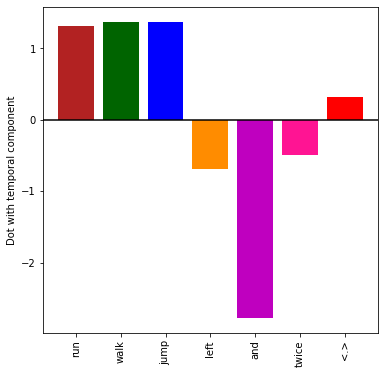

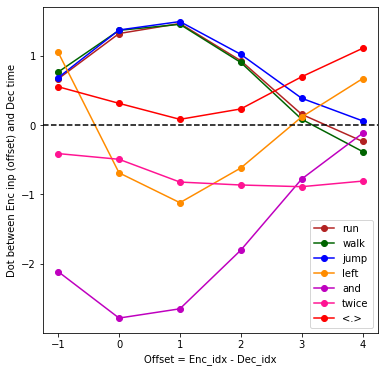

In [ ]:
def enc_word_dec_temp(hs, hs_data, toy_params, b_off=1, f_off=4):
  """
  Finds average angle and dot product of encoder word (inp + delta) with decoder temporal
  b_off: backward offset
  f_off: forward offset
  """
  # Using the test phrases, finds the average hidden state for each time step for each word
  hs_time_word_enc, hs_time_word_dec = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params)
  avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

  enc_len = hs_data['inputs'][0].shape[0]
  dec_len = hs_data['labels'][0].shape[0]

  enc_word_dots = np.zeros((len(toy_params['in_words_pp']), b_off+f_off+1))
  enc_word_angles = np.zeros((len(toy_params['in_words_pp']), b_off+f_off+1))

  for word_idx in range(len(toy_params['in_words_pp'])):
    word_dots = []
    word_angles = []
    for seq_idx in range(b_off, np.min((enc_len-f_off, dec_len-f_off))):
      dec_temp = avg_hs[enc_len+seq_idx-b_off:enc_len+seq_idx+f_off+1]
      dec_dot = []
      dec_angle = []
      if len(hs_time_word_enc[seq_idx][word_idx]) > 0: # If there is at least one example
        for samp_idx in range(len(hs_time_word_enc[seq_idx][word_idx])):
          enc_word = hs_time_word_enc[seq_idx][word_idx][samp_idx] - avg_hs[seq_idx]
          dec_dot.append(np.dot(dec_temp, enc_word))
          dec_angle.append(analysis.angle_degrees(dec_temp, enc_word))
        # Averages over all samples
        word_dots.append(np.mean(np.array(dec_dot), axis=0))
        word_angles.append(np.mean(np.array(dec_angle), axis=0))
    # Averages over sequence location
    enc_word_dots[word_idx] = np.mean(np.array(word_dots), axis=0)
    enc_word_angles[word_idx] = np.mean(np.array(word_angles), axis=0)

  return enc_word_dots, enc_word_angles

b_off = 1
f_off = 4

enc_word_dots, enc_word_angles = enc_word_dec_temp(hs, hs_data, toy_params, b_off=b_off, f_off=f_off)

fig1, ax3 = plt.subplots(1, 1, figsize=(6, 6))

ax3.bar([i for i in range(len(toy_params['in_words_pp'])-1)], enc_word_dots[:-1, b_off], width=0.8, color=state_colors[:len(toy_params['in_words_pp'])-1])
ax3.axhline(0.0, color='k')
ax3.set_ylabel('Dot with temporal component')
# ticks = np.array([-20, -10, 0, 10, 20])
# ax3.set_yticks(ticks)
ax3.set_xticks([i for i in range(len(toy_params['in_words_pp'])-1)])
ax3.set_xticklabels(toy_params['in_words_pp'][:-1], rotation=90)

fig, ax1 = plt.subplots(1, 1, figsize=(6,6))

offset_vals = [i-b_off for i in range(b_off+f_off+1)]
for word_idx in range(len(toy_params['in_words_pp'])-1): # -1 eliminates <pad>
  ax1.plot(offset_vals, enc_word_dots[word_idx], marker='o', color=state_colors[word_idx], label=toy_params['in_words_pp'][word_idx])

ax1.axhline(0.0, linestyle='dashed', color='k')
ax1.set_ylabel('Dot between Enc inp (offset) and Dec time')

ax1.legend()
ax1.set_xlabel('Offset = Enc_idx - Dec_idx')


In [ ]:
# Using the test phrases, finds the average hidden state for each time step for each word

hs_time_word_enc, hs_time_word_dec = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params)

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

avg_hs_word_enc = np.zeros((len(toy_params['in_words_pp']), enc_len, rnn_specs['hidden_size']))
avg_hs_word_dec = np.zeros((len(toy_params['out_words_pp'])+1, dec_len, rnn_specs['hidden_size'])) # +1 for <BoS>

for time_idx in range(enc_len): # Encoder
  for word_idx in range(len(hs_time_word_enc[time_idx])):
    if len(hs_time_word_enc[time_idx][word_idx]) > 0:
      avg_hs_word_enc[word_idx, time_idx, :] = np.mean(np.asarray(hs_time_word_enc[time_idx][word_idx]), axis=0)
for time_idx in range(dec_len): # Decoder
  for word_idx in range(len(hs_time_word_dec[time_idx])):
    if len(hs_time_word_dec[time_idx][word_idx]) > 0:
      avg_hs_word_dec[word_idx, time_idx, :] = np.mean(np.asarray(hs_time_word_dec[time_idx][word_idx]), axis=0)

print('Done')

Finding average hidden state at each time step...
Done


In [ ]:
for i in range(len(toy_params['in_words_pp'])):
  word_input = avg_hs_word_enc[i] - avg_hs[:enc_len]
  print('Word {} in mag:'.format(toy_params['in_words_pp'][i]), np.mean(np.linalg.norm(word_input, axis=1)))
  print('Word {} full mag:'.format(toy_params['in_words_pp'][i]), np.mean(np.linalg.norm(avg_hs_word_enc[i], axis=1)))
for i in range(len(toy_params['out_words_pp'])):
  word_input = avg_hs_word_dec[i] - avg_hs[enc_len:]
  print('Word {} in mag:'.format(toy_params['out_words_pp'][i]), np.mean(np.linalg.norm(word_input, axis=1)))
  print('Word {} full mag:'.format(toy_params['out_words_pp'][i]), np.mean(np.linalg.norm(avg_hs_word_dec[i], axis=1)))

for i in range(len(toy_params['in_words_pp'])):
  enc_word_input = avg_hs_word_enc[i] - avg_hs[:enc_len]
  dec_word_input = avg_hs_word_dec[i] - avg_hs[enc_len:]
  print('Word Dot {} and {}:'.format(toy_params['in_words_pp'][i], toy_params['out_words_pp'][i]), 
        np.mean([np.dot(ew, dw) for ew, dw in zip(enc_word_input, dec_word_input)]))

Word run in mag: 4.210326823340248
Word run full mag: 5.921070190145967
Word walk in mag: 4.21997496168575
Word walk full mag: 6.072807508657176
Word jump in mag: 4.0363925571617285
Word jump full mag: 6.392227521889953
Word left in mag: 4.121779331327723
Word left full mag: 6.242415305025892
Word and in mag: 3.485307575165261
Word and full mag: 5.798109312866551
Word twice in mag: 3.676875800621792
Word twice full mag: 5.759303021130434
Word <.> in mag: 2.8891321604437983
Word <.> full mag: 7.053072281654585
Word <pad> in mag: 4.805754736185588
Word <pad> full mag: 3.05177529470647
Word I_RUN in mag: 0.8090669365389119
Word I_RUN full mag: 4.621917999531918
Word I_WALK in mag: 0.8007830392074405
Word I_WALK full mag: 4.633314031257796
Word I_JUMP in mag: 0.7910623797751611
Word I_JUMP full mag: 4.629019444667566
Word I_TURN_LEFT in mag: 1.2435379854185475
Word I_TURN_LEFT full mag: 4.313386741801088
Word <.> in mag: 1.0005491406722518
Word <.> full mag: 4.569976806137221
Word <pad> in

IndexError: ignored

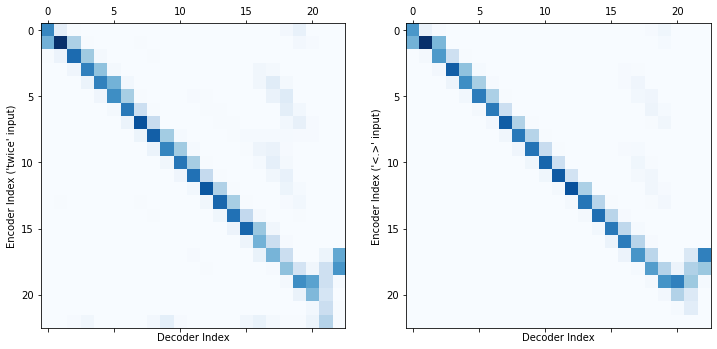

In [ ]:
# Encoder to compare
words = ['twice', '<.>'] #['<.>', 'left']

# Decoder to compare to
dec_seq_word = '<avg>'

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

if dec_seq_word == '<avg>': # Calculates and compares to average decoder sequence
  dec_seq = np.zeros((hs['all'][0].shape))
  for time_idx in range(hs['all'][0].shape[0]):
    time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
    dec_seq[time_idx] = np.mean(time_hs, axis=0)
else:
  dec_seq =  hs['special'][toy_params['out_words'].index(dec_seq_word)]
  
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for word, ax in zip(words, axs):
  # Attention matrix from mean input states
  # attn_matrix = np.zeros((enc_len, dec_len))
  # print('Word index:', toy_params['in_words'].index(word))
  # # Encoder sequence from chosen special word
  # enc_seq = hs['special'][toy_params['in_words'].index(word)][:enc_len, :] 
  # for seq_idx in range(dec_len):
  #   attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, dec_seq[enc_len + seq_idx, :]))

  attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
  for h_idx in range(len(hs['all'])):
    enc_seq = hs['special'][toy_params['in_words'].index(word)][:enc_len, :]
    for seq_idx in range(dec_len):
      attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx]))

  attn_matrix = np.mean(attn_matrix, axis=0)

  ax.matshow(attn_matrix, cmap=plt.cm.Blues)
  ax.set_ylabel(f'Encoder Index (\'{word}\' input)')
  ax.set_xlabel('Decoder Index')

ValueError: ignored

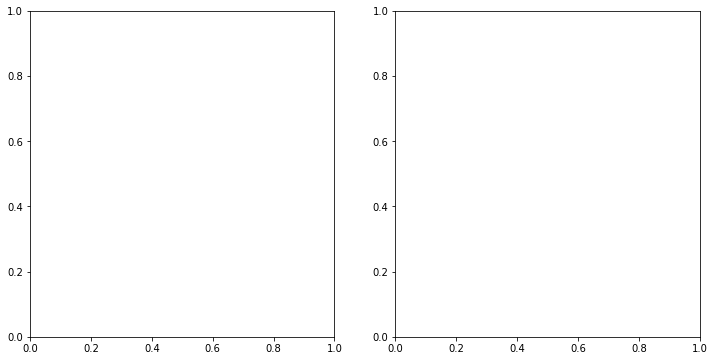

In [ ]:
# Encoder to compare
enc_seq_words = ['exercise', 'exercise'] 

# Decoder to compare to
dec_seq_words = ['I_EXER1', 'I_EXER2']

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# if enc_seq_word == '<avg>': # Calculates and compares to average decoder sequence
#   enc_seq = np.zeros((hs['all'][0].shape))
#   for time_idx in range(hs['all'][0].shape[0]):
#     time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
#     enc_seq[time_idx] = np.mean(time_hs, axis=0)
# else:
#   enc_seq =  hs['special'][toy_params['in_words'].index(enc_seq_word)]
  
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for enc_word, dec_word, ax in zip(enc_seq_words, dec_seq_words, axs):
  # Attention matrix from mean input states
  # attn_matrix = np.zeros((enc_len, dec_len))
  # print('Word index:', toy_params['in_words'].index(word))
  # # Encoder sequence from chosen special word
  # enc_seq = hs['special'][toy_params['in_words'].index(word)][:enc_len, :] 
  # for seq_idx in range(dec_len):
  #   attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, dec_seq[enc_len + seq_idx, :]))

  # attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
  # dec_seq = avg_hs_word_dec[toy_params['out_words'].index(word), :, :]
  # for h_idx in range(len(hs['all'])):
  #   enc_seq = hs['all'][h_idx][:enc_len]
  #   for seq_idx in range(enc_len):
  #     attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(word), seq_idx, :]))

  # attn_matrix = np.mean(attn_matrix, axis=0)

  attn_matrix = np.zeros((enc_len, dec_len))
  enc_seq = avg_hs_word_dec[toy_params['in_words'].index(enc_word), :, :]
  for seq_idx in range(enc_len):
    attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(dec_word), seq_idx, :]))

  # attn_matrix = 

  ax.matshow(attn_matrix, cmap=plt.cm.Blues)
  ax.set_ylabel(f'Encoder Index (\'{enc_word}\' input)')
  ax.set_xlabel(f'Decoder Index (\'{dec_word}\' input)')

[Text(0, 0, 'run'),
 Text(0, 0, 'walk'),
 Text(0, 0, 'exercise'),
 Text(0, 0, 'left'),
 Text(0, 0, '<.>'),
 Text(0, 0, '<pad>')]

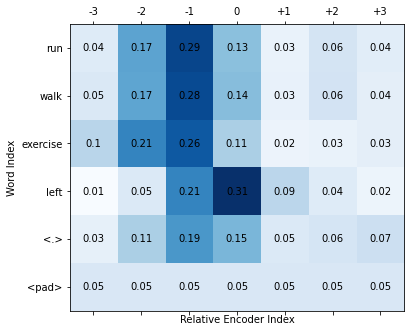

In [ ]:
look_dist = 3 # How many squares to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])

dec_seq = np.zeros((hs['all'][0].shape))
for time_idx in range(hs['all'][0].shape[0]):
  time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
  dec_seq[time_idx] = np.mean(time_hs, axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
relative_aligns = np.zeros((len(toy_params['in_words_pp']), 2*look_dist + 1))

for word_idx in range(len(toy_params['in_words_pp'])):
  # Finds the average attention matrix
  attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
  for h_idx in range(len(hs['all'])):
    enc_seq = hs['special'][word_idx][:enc_len, :]
    for seq_idx in range(dec_len):
      attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx]))

  attn_matrix = np.mean(attn_matrix, axis=0)

  relative_aligns_word = np.zeros((dec_len-2*look_dist, 2*look_dist + 1))
  for dec_idx in range(look_dist, min_len-look_dist): # Each decoder location for a given look_dist
    relative_aligns_word[dec_idx - look_dist] = attn_matrix[dec_idx - look_dist:dec_idx + look_dist + 1, dec_idx]

  relative_aligns[word_idx] = np.mean(relative_aligns_word , axis=0)

ax1.matshow(relative_aligns, cmap=plt.cm.Blues)
ax1.set_ylabel('Word Index')
ax1.set_xlabel('Relative Encoder Index')

for i in range(relative_aligns.shape[1]):
  for j in range(relative_aligns.shape[0]):
    c = relative_aligns[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(len(toy_params['in_words_pp']))])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels(toy_params['in_words_pp'], rotation=0)

Using minimum sequence length of: 18


[Text(0, 0, '-2'),
 Text(0, 0, '-1'),
 Text(0, 0, '0'),
 Text(0, 0, '+1'),
 Text(0, 0, '+2')]

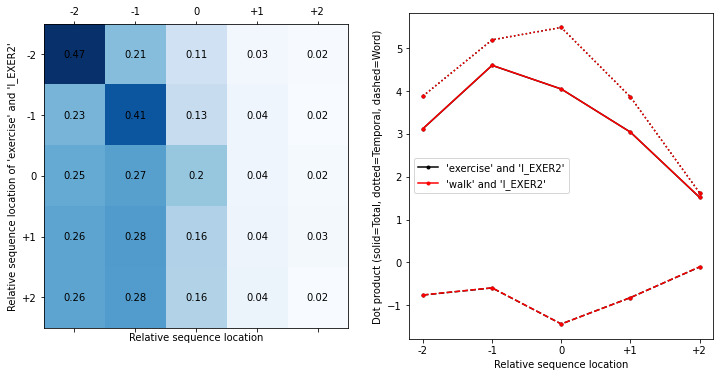

In [ ]:
# Sees if a word in the decoder latches onto particular other words as a function of distance.
# Uses the average states to compute said latching.

look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

latch_words = ['exercise', 'I_EXER2'] # Input-Output pair to test
other_in_words = ['walk', 'run', '<.>']

align_vals = np.zeros((len(other_in_words), 2*look_dist+1, 2*look_dist+1))

for word_idx in range(len(other_in_words)):
  for os_idx in range(2*look_dist+1):
    offset = os_idx - look_dist
    align_vals_offset = np.zeros((min_len-2*look_dist, 2*look_dist+1))

    for seq_idx in range(min_len-2*look_dist):
      enc_loc = look_dist + seq_idx + offset # Location of latch word in input
      dec_loc = look_dist + seq_idx # Location of latch word in output

      # print('Enc loc', enc_loc)
      # Fills encoder sequence with other word
      enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
      # Makes sequence index the latch word
      enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]


      soft_max_vals = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :]))

      align_vals_offset[seq_idx, :] = soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1]

    align_vals[word_idx, os_idx] = np.mean(align_vals_offset, axis=0)
# Averages over all other words:
align_vals = np.mean(align_vals, axis=0)

# Decomposes dot product of latch words into temporal and word components
latch_dot = np.zeros((2*look_dist+1, min_len-2*look_dist, 2))
non_latch_dot = np.zeros((2*look_dist+1, min_len-2*look_dist, 2))
for os_idx in range(2*look_dist+1):
  offset = os_idx - look_dist
  for seq_idx in range(min_len-2*look_dist):
    enc_loc = seq_idx + offset # Location of latch word in input
    dec_loc = seq_idx # Location of latch word in output
    enc_hs_word = avg_hs_word_dec[toy_params['in_words'].index(latch_words[0]), enc_loc] - avg_hs[enc_loc]
    dec_hs_word = avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc] - avg_hs[dec_loc + enc_len]

    enc_hs_nl_word = avg_hs_word_dec[toy_params['in_words'].index(other_in_words[0]), enc_loc] - avg_hs[enc_loc]

    latch_dot[os_idx, seq_idx, 0] = np.dot(avg_hs[enc_loc], avg_hs[dec_loc + enc_len])
    latch_dot[os_idx, seq_idx, 1] = np.dot(enc_hs_word, dec_hs_word)
    non_latch_dot[os_idx, seq_idx, 0] = np.dot(avg_hs[enc_loc], avg_hs[dec_loc + enc_len])
    non_latch_dot[os_idx, seq_idx, 1] = np.dot(enc_hs_nl_word, dec_hs_word)
# Averages over sequence location
latch_dot = np.mean(latch_dot, axis=1)
non_latch_dot = np.mean(non_latch_dot, axis=1) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.matshow(align_vals, cmap=plt.cm.Blues)
ax1.set_ylabel(f'Relative sequence location of \'{latch_words[0]}\' and \'{latch_words[1]}\'')
ax1.set_xlabel('Relative sequence location')

ax2.plot([j - look_dist for j in range(2*look_dist + 1)], latch_dot[:, 0] + latch_dot[:, 1], color='k', 
         marker='.', linestyle='solid', label=f'\'{latch_words[0]}\' and \'{latch_words[1]}\'')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], latch_dot[:, 0], color='k', marker='.',
         linestyle='dotted')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], latch_dot[:, 1], color='k', marker='.',
         linestyle='dashed')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], non_latch_dot[:, 0] + non_latch_dot[:, 1], color='r', 
         marker='.', linestyle='solid', label=f'\'{other_in_words[0]}\' and \'{latch_words[1]}\'')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], non_latch_dot[:, 0], color='r', marker='.',
         linestyle='dotted')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], non_latch_dot[:, 1], color='r', marker='.',
         linestyle='dashed')
ax2.set_ylabel(f'Dot product (solid=Total, dotted=Temporal, dashed=Word)')
ax2.set_xlabel('Relative sequence location')
ax2.legend()

for i in range(align_vals.shape[1]):
  for j in range(align_vals.shape[0]):
    c = align_vals[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax2.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

Finding average hidden state at each time step...


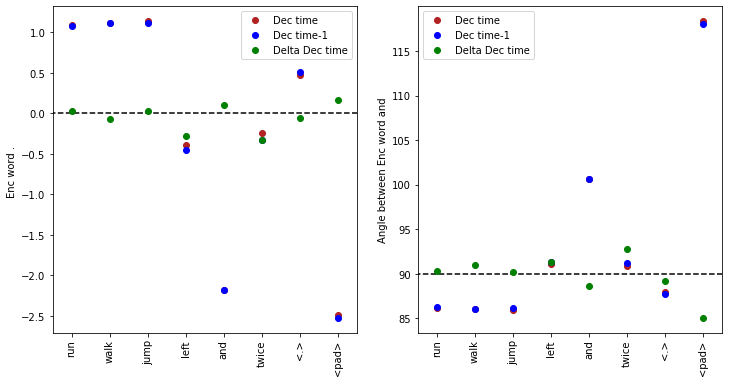

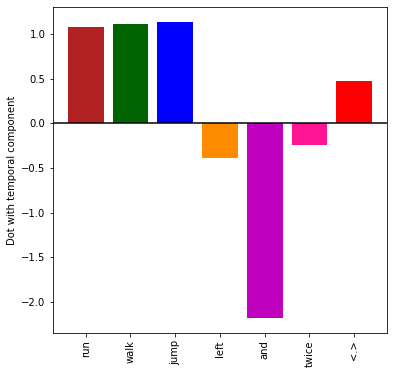

In [ ]:
# Checks the dot product of the encoder word subspace with the decoder time subspace. 
# This has shown up in multiple modifier words as a way of lowering the overall dot product.

temporal_hs = analysis.find_avg_hs(hs, hs_data, toy_params)
# temporal_hs = hs['special'][-1]
delta_temporal = [temporal_hs[i+1] - temporal_hs[i] for i in range(temporal_hs.shape[0]-1)]

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# First index is dot with temporal hs at time step, second is temporal hs at next time step, third difference
avg_word_dots = np.zeros((len(toy_params['in_words_pp']), 3))
avg_word_angles = np.zeros((len(toy_params['in_words_pp']), 3))

for word_idx in range(len(toy_params['in_words_pp'])):
  word_dots = []
  word_next_dots = []
  delta_word_dots = []
  word_angles = []
  word_next_angles = []
  delta_word_angles = []
  for seq_idx in range(np.min((enc_len, dec_len))):
    if not np.all(avg_hs_word_enc[word_idx][seq_idx] == np.zeros(rnn_specs['hidden_size'])): # Makes sure average is not zeros
      word_enc = avg_hs_word_enc[word_idx][seq_idx] - temporal_hs[seq_idx]
      word_dots.append(np.dot(temporal_hs[enc_len+seq_idx], word_enc))
      word_angles.append(analysis.angle_degrees(temporal_hs[enc_len+seq_idx], word_enc))
      if seq_idx < np.min((enc_len, dec_len)) - 1:
        delta_word_dots.append(np.dot(delta_temporal[enc_len+seq_idx], word_enc))
        delta_word_angles.append(analysis.angle_degrees(delta_temporal[enc_len+seq_idx], word_enc))
        word_next_enc = avg_hs_word_enc[word_idx][seq_idx] - temporal_hs[seq_idx]
        word_next_dots.append(np.dot(temporal_hs[enc_len+seq_idx], word_next_enc))
        word_next_angles.append(analysis.angle_degrees(temporal_hs[enc_len+seq_idx], word_next_enc))

  avg_word_dots[word_idx, 0] = np.mean(np.asarray(word_dots), axis=0)
  avg_word_angles[word_idx, 0] = np.mean(np.asarray(word_angles), axis=0)
  avg_word_dots[word_idx, 1] = np.mean(np.asarray(word_next_dots), axis=0)
  avg_word_angles[word_idx, 1] = np.mean(np.asarray(word_next_angles), axis=0)
  avg_word_dots[word_idx, 2] = np.mean(np.asarray(delta_word_dots), axis=0)
  avg_word_angles[word_idx, 2] = np.mean(np.asarray(delta_word_angles), axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig2, ax3 = plt.subplots(1, 1, figsize=(6, 6))

ax1.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_dots[:, 0], marker='o', color='firebrick', linewidth=0, label='Dec time')
ax1.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_dots[:, 1], marker='o', color='blue', linewidth=0, label='Dec time-1')
ax1.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_dots[:, 2], marker='o', color='green', linewidth=0, label='Delta Dec time')
ax1.set_ylabel('Enc word . ')
ax1.hlines(0.0, -1, len(toy_params['in_words_pp'])+1, linestyles='dashed', color='k')
ax2.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_angles[:, 0], marker='o', color='firebrick', linewidth=0, label='Dec time')
ax2.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_angles[:, 1], marker='o', color='blue', linewidth=0, label='Dec time-1')
ax2.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_angles[:, 2], marker='o', color='green', linewidth=0, label='Delta Dec time')
ax2.set_ylabel('Angle between Enc word and')
ax2.hlines(90.0, -1, len(toy_params['in_words_pp'])+1, linestyles='dashed', color='k')

# ax3.bar([i for i in range(len(toy_params['in_words_pp'])-1)], avg_word_angles[:-1, 0]-90, width=0.8, color=state_colors[:len(toy_params['in_words_pp'])-1])
# ax3.axhline(0.0, color='k')
# ax3.set_ylabel('Angle relative to temporal component')
# ticks = np.array([-10, 0, 10, 20])
# ax3.set_yticks(ticks)
# ax3.set_yticklabels(ticks+90)
# ax3.set_xticks([i for i in range(len(toy_params['in_words_pp'])-1)])
# ax3.set_xticklabels(toy_params['in_words_pp'][:-1], rotation=90)

ax3.bar([i for i in range(len(toy_params['in_words_pp'])-1)], avg_word_dots[:-1, 0], width=0.8, color=state_colors[:len(toy_params['in_words_pp'])-1])
ax3.axhline(0.0, color='k')
ax3.set_ylabel('Dot with temporal component')
# ticks = np.array([-20, -10, 0, 10, 20])
# ax3.set_yticks(ticks)
ax3.set_xticks([i for i in range(len(toy_params['in_words_pp'])-1)])
ax3.set_xticklabels(toy_params['in_words_pp'][:-1], rotation=90)

for ax in [ax1, ax2,]:
  ax.set_xlim([-0.5, len(toy_params['in_words_pp'])-0.5])
  ax.set_xticks([i for i in range(len(toy_params['in_words_pp']))])
  ax.set_xticklabels(toy_params['in_words_pp'], rotation=90)
  ax.legend()

Finding average hidden state at each time step...


/content/drive/My Drive/ml_research/fixedpoints_nlp/seq2seq_files/analysis.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return 180/np.pi * np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))


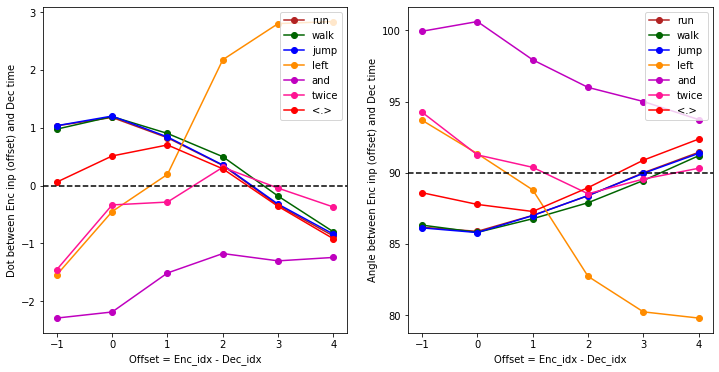

In [ ]:
# Checks the dot product of the encoder word subspace with the decoder time subspace. 
# This has shown up in multiple modifier words as a way of lowering the overall dot product.

temporal_hs = analysis.find_avg_hs(hs, hs_data, toy_params)
b_off = 1 # backward offset
f_off = 4 # forward offset

avg_word_dots = np.zeros((len(toy_params['in_words_pp']), b_off+f_off+1))
avg_word_angles = np.zeros((len(toy_params['in_words_pp']), b_off+f_off+1))
for word_idx in range(len(toy_params['in_words_pp'])):
  word_dots = []
  word_angles = []
  for seq_idx in range(b_off, np.min((enc_len-f_off, dec_len))):
    if not np.all(avg_hs_word_enc[word_idx][seq_idx] == np.zeros(rnn_specs['hidden_size'])): # Makes sure average is not zeros
      word_enc = avg_hs_word_enc[word_idx][seq_idx-b_off:seq_idx+f_off+1] - temporal_hs[seq_idx-b_off:seq_idx+f_off+1]
      word_dots.append(np.dot(word_enc, temporal_hs[enc_len+seq_idx]))
      angles = []
      for offset_idx in range(0, b_off+f_off+1):
        angles.append(analysis.angle_degrees(temporal_hs[enc_len+seq_idx], word_enc[offset_idx]))
      word_angles.append(angles)

  avg_word_dots[word_idx] = np.mean(np.asarray(word_dots), axis=0)
  avg_word_angles[word_idx] = np.mean(np.asarray(word_angles), axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

offset_vals = [i-b_off for i in range(b_off+f_off+1)]
for word_idx in range(len(toy_params['in_words_pp'])-1): # -1 eliminates <pad>
  ax1.plot(offset_vals, avg_word_dots[word_idx], marker='o', color=state_colors[word_idx], label=toy_params['in_words_pp'][word_idx])
  ax2.plot(offset_vals, avg_word_angles[word_idx], marker='o', color=state_colors[word_idx], label=toy_params['in_words_pp'][word_idx])

ax1.axhline(0.0, linestyle='dashed', color='k')
ax1.set_ylabel('Dot between Enc inp (offset) and Dec time')
ax2.set_ylabel('Angle between Enc inp (offset) and Dec time')
ax2.axhline(90.0, linestyle='dashed', color='k')

for ax in [ax1, ax2]:
  ax.legend()
  ax.set_xlabel('Offset = Enc_idx - Dec_idx')

#### 'Twice' Analysis

Using minimum sequence length of: 23


[Text(0, 0, '-2'),
 Text(0, 0, '-1'),
 Text(0, 0, '0'),
 Text(0, 0, '+1'),
 Text(0, 0, '+2')]

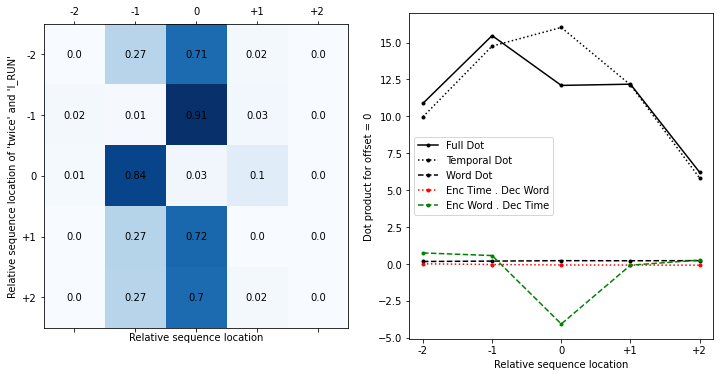

In [ ]:
look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

latch_words = ['run', 'I_RUN'] # Input-Output pair to test
other_in_words = ['walk', 'jump', '<.>']

align_vals = np.zeros((len(other_in_words), 2*look_dist+1, 2*look_dist+1))

for word_idx in range(len(other_in_words)):
  for os_idx in range(2*look_dist+1):
    offset = os_idx - look_dist
    align_vals_offset = np.zeros((min_len-2*look_dist, 2*look_dist+1))
    base = avg_hs_word_enc[toy_params['in_words'].index(other_in_words[0])]

    for seq_idx in range(min_len-2*look_dist):
      enc_loc = look_dist + seq_idx + offset # Location of latch word in input
      dec_loc = look_dist + seq_idx # Location of latch word in output

      # print('Enc loc', enc_loc)
      # Fills encoder sequence with other word
      enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
      # Makes sequence index the latch word
      enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

      # print((base == enc_seq)[:, :2])

      soft_max_vals = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :]))
      # print(soft_max_vals)
      # print(soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1])
      # print(dfsdfsd)

      align_vals_offset[seq_idx, :] = soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1]

    align_vals[word_idx, os_idx] = np.mean(align_vals_offset, axis=0)
# Averages over all other words:
align_vals = np.mean(align_vals, axis=0)

dot_vals = np.zeros((len(other_in_words), 2*look_dist+1, 5))

for word_idx in range(len(other_in_words)):
  dot_vals_seq = np.zeros((min_len-2*look_dist, 2*look_dist+1, 5))
  for seq_idx in range(min_len-2*look_dist):
    enc_loc = look_dist + seq_idx # Location of latch word in input
    dec_loc = look_dist + seq_idx # Location of latch word in output

    enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
    # Makes sequence index the latch word
    enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

    # print((base == enc_seq)[:, :2])

    dot_vals_seq[seq_idx, :, 0] = np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 1] = np.dot(avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 2] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 3] = np.dot(avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 4] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]

  dot_vals[word_idx] = np.mean(dot_vals_seq, axis=0)
# Averages over all other words:
dot_vals = np.mean(dot_vals, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.matshow(align_vals, cmap=plt.cm.Blues)
ax1.set_ylabel(f'Relative sequence location of \'{latch_words[0]}\' and \'{latch_words[1]}\'')
ax1.set_xlabel('Relative sequence location')

ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,0], color='k', 
         marker='.', linestyle='solid', label='Full Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,1], color='k', 
         marker='.', linestyle='dotted', label='Temporal Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,2], color='k', 
         marker='.', linestyle='dashed', label='Word Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,3], color='r', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Word')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,4], color='g', 
         marker='.', linestyle='dashed', label='Enc Word . Dec Time')
ax2.set_ylabel(f'Dot product for offset = 0')
ax2.set_xlabel('Relative sequence location')
ax2.legend()

for i in range(align_vals.shape[1]):
  for j in range(align_vals.shape[0]):
    c = align_vals[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax2.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

In [ ]:
# Calculates average hidden state and subtracts it out from hidden states at all time steps to isolate word subspace
# Average hidden state does NOT include repeated <pad>'s for encoder or decoder
context_word = 'twice'
other_words = ['run', 'walk', 'left']

cw_idx = toy_params['in_words'].index(context_word)
ow_idxs = [toy_params['in_words'].index(word) for word in other_words]

avg_hs = np.zeros((hs['all'][0].shape))
pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs['all'][0].shape[0]):
  if time_idx < enc_len: # Encoder
    time_hs = []
    for h, inp in zip(hs['all'], hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  else: # Decoder
    time_hs = []
    for h, out in zip(hs['all'], hs_data['labels']):
      if time_idx - enc_len> 0:
        if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  if time_hs.shape[0] > 0:
    avg_hs[time_idx] = np.mean(time_hs, axis=0)
  else:
    print('Zero length')

# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - avg_hs for h in hs['all']]

hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_inputs_context = [[] for _ in range(len(other_words))]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 

for time_idx in range(enc_len): # Encoder
  for h_mpe, inp in zip(hs_mod_pos_enc, hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    else: # Automatically adds if first index
      hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    if np.argmax(inp[time_idx]) == cw_idx and time_idx > 0:
      last_inp = inp[time_idx-1]
      last_inp_idx = np.argmax(last_inp)
      hs_inputs_context[ow_idxs.index(last_inp_idx)].append(h_mpe[time_idx])

print('Done')

Done


Text(0, 0.5, 'PC1 (mod pos_enc)')

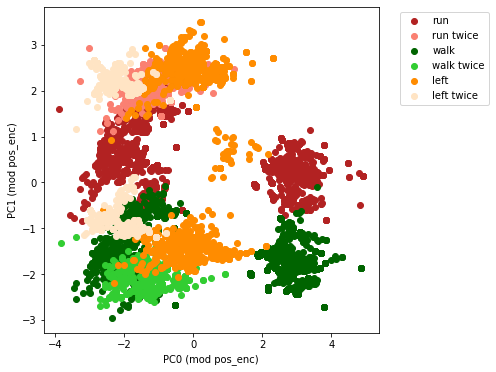

In [ ]:
# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])

_ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
for inp_idx in ow_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_word[inp_idx])).T
  ax1.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context[ow_idxs.index(inp_idx)])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors_light[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word)

# Plots readout direction
# readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
# ro_styles = ['solid', 'dotted', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

#### Dot Decomposition

Finding average hidden state at each time step...
Searching for: 
 ['<any>', '<any>', '<any>', 'left', '<any>'] 
 ['<any>', '<any>', 'I_TURN_LEFT', '<any>', '<any>']
Averaging over 32 latch locations
Dot val shape: (5, 32, 5)
Dot val mean shape: [[-0.28034155  6.20289621  9.09460132 11.92394793  4.62626104]
 [ 0.46673507  3.69953105  7.61280157  7.99122739  5.87017447]
 [-0.1447255  -2.83040239 -0.49254251  1.64179672  1.46577949]
 [-0.55655682  0.39207473  0.37488054  0.4766821   0.35590047]
 [-0.04579404  4.94169322  1.59946264  1.81424272 -3.06559332]]


[Text(0, 0, '-2'),
 Text(0, 0, '-1'),
 Text(0, 0, '0'),
 Text(0, 0, '+1'),
 Text(0, 0, '+2')]

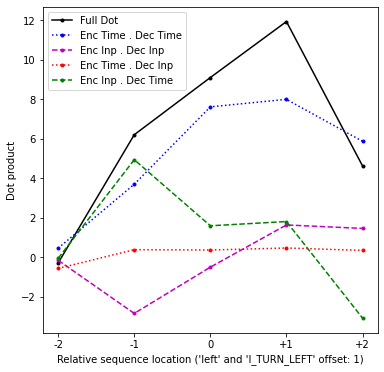

In [ ]:
# Same as the decomposition above, but searches the test phrases for the desired latch alignment.

from scipy.special import softmax

index_filter = True
idx_filter_val = 5

avg_hs = find_avg_hs(hs, hs_data, toy_params)

look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# offset is encoder location - decoder location
latch_words, offset = ['left', 'I_TURN_LEFT'], 1 # Input-Output pair to test
# latch_words, offset = ['left', 'I_WALK'], 1 # Input-Output pair to test
# latch_words, offset = ['I0', 'O0'], 0 # Input-Output pair to test
# latch_words, offset= ['and', 'I_RUN'], 0 # Input-Output pair to test
# latch_words, offset= ['twice', 'I_RUN'], 0 # Input-Output pair to test
# latch_words = ['exercise', 'I_EXER2'], 1 # Input-Output pair to test
# latch_words, offset = ['<.>', '<.>'], 0 # Input-Output pair to test
# latch_words, offset = ['run', 'I_RUN'], 1 # Input-Output pair to test

latch_idx = [toy_params['in_words'].index(latch_words[0]), toy_params['out_words'].index(latch_words[1])]

dot_vals = [[] for _ in range(5)] # total, and 4 different parts

enc_template, dec_template = ['<any>' for _ in range(2*look_dist+1)], ['<any>' for _ in range(2*look_dist+1)]
enc_template[look_dist+offset] = latch_words[0]
dec_template[look_dist] = latch_words[1]
print('Searching for: \n', enc_template, '\n', dec_template)

for h, inp, out, in_idx, out_idx in zip(hs['all'], hs_data['inputs'], hs_data['labels'], hs_data['in_index'], hs_data['out_index']):
  min_len = np.min([in_idx, out_idx])

  enc_phrase = h[:min_len+1]
  dec_phrase = h[enc_len:enc_len+min_len+1]
  in_latch_locs = np.argmax(inp[:min_len+1], axis=1) == latch_idx[0]
  out_latch_locs = np.argmax(out[:min_len+1], axis=1) == latch_idx[1]

  # Finds locations in phrase where latches have the given offset
  if offset == 0: # No shift to input phrase
    locs = np.logical_and(in_latch_locs, out_latch_locs)
  elif offset > 0: # Shifts input phrase upwards
    locs = np.logical_and(in_latch_locs[offset:], out_latch_locs[:-offset])
  else: # Shifts input phrase backwards
    locs = np.logical_and(in_latch_locs[:offset], out_latch_locs[-offset:])

    # Finds all valid locations, eliminating idxs that are within look_dist of start or end of phrase
  if offset >= 0:
    latch_locs = [i for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 
  else: # Need to add offset since started at idx=offset when comparing
    latch_locs = [i - offset for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 

  # Filters out additional indexes above idx_filter_val (useful for looking only at earlier part of phrase)
  if index_filter:
    latch_locs = [i for i in latch_locs if i <= idx_filter_val] 

  # Calculates aligns and adds appropriate aligns to dot_vals
  enc_avg = avg_hs[:min_len+1]
  dec_avg = avg_hs[enc_len:enc_len+min_len+1]

  aligns = np.zeros((dec_phrase.shape[0], enc_phrase.shape[0], 5))
  aligns[:, :, 0] = np.dot(dec_phrase, enc_phrase.T)
  aligns[:, :, 1] = np.dot(dec_avg, enc_avg.T) # time dot
  aligns[:, :, 2] = np.dot(dec_phrase - dec_avg, enc_phrase.T - enc_avg.T) # input dot
  aligns[:, :, 3] = np.dot(dec_phrase - dec_avg, enc_avg.T) # inp . avg
  aligns[:, :, 4] = np.dot(dec_avg, enc_phrase.T - enc_avg.T) # avg . inp

  for latch_loc in latch_locs:
    for dot_idx in range(5):
      dot_vals[dot_idx].append(aligns[latch_loc, latch_loc-look_dist:latch_loc+look_dist+1, dot_idx])

if len(dot_vals[0]) == 0: raise ValueError('No Latch Locations Found!')
print(f'Averaging over {len(dot_vals[0])} latch locations')
print('Dot val shape:', np.array(dot_vals).shape)
print('Dot val mean shape:', np.mean(np.asarray(dot_vals), axis=1))
dot_vals = np.mean(np.array(dot_vals), axis=1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[0,:], color='k', 
         marker='.', linestyle='solid', label='Full Dot')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[1,:], color='b', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Time')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[2,:], color='m', 
         marker='.', linestyle='dashed', label='Enc Inp . Dec Inp')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[3,:], color='r', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Inp')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[4,:], color='g', 
         marker='.', linestyle='dashed', label='Enc Inp . Dec Time')
ax1.set_ylabel('Dot product')
ax1.set_xlabel(f'Relative sequence location (\'{latch_words[0]}\' and \'{latch_words[1]}\' offset: {offset})')
ax1.legend()

ax1.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

Finding average hidden state at each time step...
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True


Text(0.5, 0, 'Decoder Index')

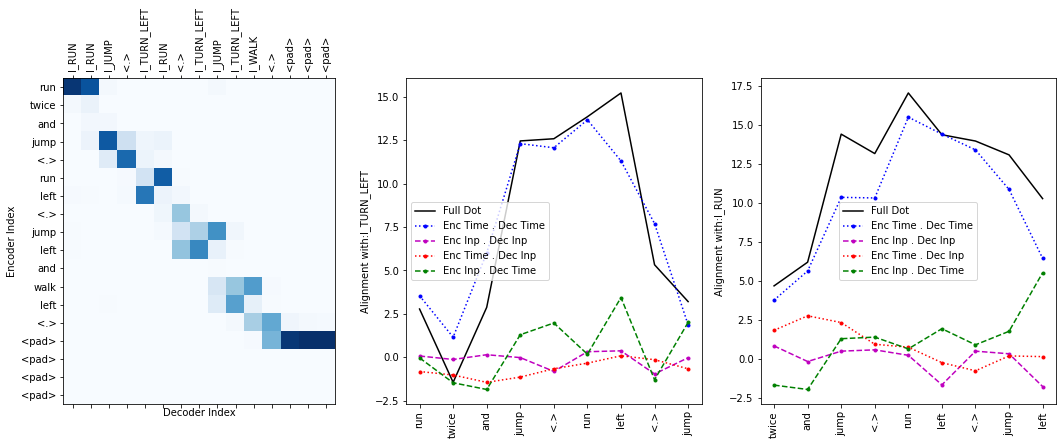

In [ ]:
# Plots attention matrix of example phrase and shows dot product decomposition for certain words
phrase_idx = 10
dec_idxs = [4, 5]
look_dist = 4

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

# Calculate attention matrix via apply function
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]
enc_labels = tensorToPhrase(hs_data['inputs'][phrase_idx], toy_params['in_words'])
dec_labels = tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['out_words'])

avg_hs = find_avg_hs(hs, hs_data, toy_params)

_, new_apply_fun, _, _, _ = build_rnn(rnn_specs)
_, attn_matrix_dir = new_apply_fun(final_params, hs_data['inputs'], hs_data['in_index'], return_att_matrix=True)

enc_seq = hs['all'][phrase_idx][:enc_len]
for dec_idx, ax in zip(dec_idxs, (ax2, ax3)):
  enc_t = avg_hs[:enc_len]
  dec_t = avg_hs[enc_len:]
  enc_w = enc_seq - enc_t
  dec_w = hs['all'][phrase_idx][enc_len:] - dec_t
  full_dot = np.dot(enc_seq, hs['all'][phrase_idx][enc_len+dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  temporal_dot = np.dot(enc_t, dec_t[dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  word_dot = np.dot(enc_w, dec_w[dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  enc_t_dec_w = np.dot(enc_t, dec_w[dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  enc_w_dec_t = np.dot(enc_w, dec_t[dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], full_dot, color='k', label='Full Dot')
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], temporal_dot, color='b', marker='.', linestyle='dotted', label='Enc Time . Dec Time')
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], word_dot, color='m', marker='.', linestyle='dashed', label='Enc Inp . Dec Inp')
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], enc_t_dec_w, color='r', marker='.', linestyle='dotted', label='Enc Time . Dec Inp')
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], enc_w_dec_t, color='g', marker='.', linestyle='dashed', label='Enc Inp . Dec Time')
  # Sanity check
  # ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], temporal_dot+word_dot+enc_t_dec_w+enc_w_dec_t, color='k', marker='o', 
  #  linestyle='solid', label='Sum')
  

  plot_range = [i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)]
  ax.set_xticks(plot_range)
  ax.set_xticklabels(enc_labels[dec_idx-look_dist:dec_idx+look_dist+1], rotation=90)
  ax.set_ylabel('Alignment with:' + dec_labels[dec_idx])

  ax.legend()

ax1.matshow(attn_matrix_dir[phrase_idx], cmap=plt.cm.Blues)

ax1.set_xticks([j for j in range(dec_len)])
ax1.set_yticks([j for j in range(enc_len)])
ax1.set_yticklabels(enc_labels, rotation=0)
ax1.set_xticklabels(dec_labels, rotation=90)

ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')


In [ ]:

# Calculates average hidden state and subtracts it out from hidden states at all time steps to isolate word subspace
# Average hidden state does NOT include repeated <pad>'s for encoder or decoder
context_word = '<.>'
other_words = ['run', 'walk', 'exercise']

cw_idx = toy_params['in_words'].index(context_word)
ow_idxs = [toy_params['in_words'].index(word) for word in other_words]

avg_hs = np.zeros((hs['all'][0].shape))
pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs['all'][0].shape[0]):
  if time_idx < enc_len: # Encoder
    time_hs = []
    for h, inp in zip(hs['all'], hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  else: # Decoder
    time_hs = []
    for h, out in zip(hs['all'], hs_data['labels']):
      if time_idx - enc_len> 0:
        if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  if time_hs.shape[0] > 0:
    avg_hs[time_idx] = np.mean(time_hs, axis=0)
  else:
    print('Zero length')

# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - avg_hs for h in hs['all']]

hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_inputs_context = [[] for _ in range(len(other_words))]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 

for time_idx in range(enc_len): # Encoder
  for h_mpe, inp in zip(hs_mod_pos_enc, hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    else: # Automatically adds if first index
      hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    if np.argmax(inp[time_idx]) == cw_idx and time_idx > 0:
      last_inp = inp[time_idx-1]
      last_inp_idx = np.argmax(last_inp)
      if last_inp_idx in ow_idxs:
        hs_inputs_context[ow_idxs.index(last_inp_idx)].append(h_mpe[time_idx])

print('Done')

Done


Text(0, 0.5, 'PC1 (mod pos_enc)')

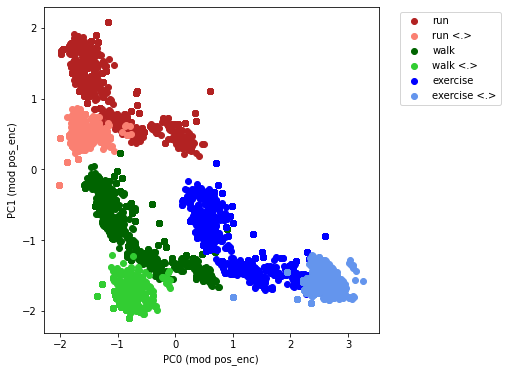

In [ ]:
# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])

_ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
for inp_idx in ow_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_word[inp_idx])).T
  ax1.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context[inp_idx])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors_light[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word)

# Plots readout direction
# readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
# ro_styles = ['solid', 'dotted', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

In [ ]:
# This does the same thing as an above cell, but simply saves the context hidden states as something else. Used for plotting all distinct phrases below
context_word2 = 'left'
other_words = ['run', 'walk', 'exercise']

cw_idx = toy_params['in_words'].index(context_word2)
ow_idxs2 = [toy_params['in_words'].index(word) for word in other_words]

avg_hs = np.zeros((hs['all'][0].shape))
pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs['all'][0].shape[0]):
  if time_idx < enc_len: # Encoder
    time_hs = []
    for h, inp in zip(hs['all'], hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  else: # Decoder
    time_hs = []
    for h, out in zip(hs['all'], hs_data['labels']):
      if time_idx - enc_len> 0:
        if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  if time_hs.shape[0] > 0:
    avg_hs[time_idx] = np.mean(time_hs, axis=0)
  else:
    print('Zero length')

# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - avg_hs for h in hs['all']]

hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_inputs_context2 = [[] for _ in range(len(other_words))]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 

for time_idx in range(enc_len): # Encoder
  for h_mpe, inp in zip(hs_mod_pos_enc, hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    else: # Automatically adds if first index
      hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    if np.argmax(inp[time_idx]) == cw_idx and time_idx > 0:
      last_inp = inp[time_idx-1]
      last_inp_idx = np.argmax(last_inp)
      if last_inp_idx in ow_idxs2:
        hs_inputs_context2[ow_idxs2.index(last_inp_idx)].append(h_mpe[time_idx])

print('Done')

Done


Text(0, 0.5, 'PC1 (mod pos_enc)')

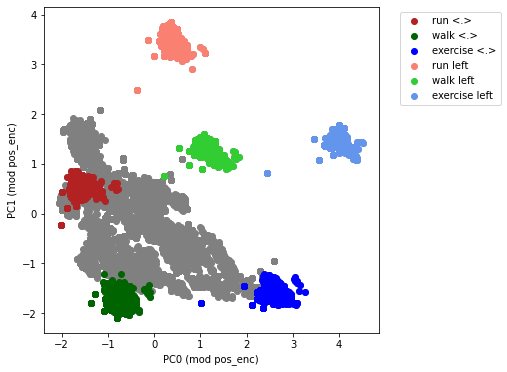

In [ ]:
# Used to plot multiple sets of context words
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])

_ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

ax1.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')

pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
for inp_idx in ow_idxs:
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context[inp_idx])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word)
  
for inp_idx in ow_idxs2:
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context2[inp_idx])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors_light[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word2)

# Plots readout direction
# readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
# ro_styles = ['solid', 'dotted', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

#### Misc Stuff

In [ ]:
from scipy.special import softmax

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

look_dist = 3 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

dot_vals = np.zeros((min_len-2*look_dist, 2*look_dist+1))

offset = 0 # Negative means encoder location is before decoder locat

for seq_idx in range(min_len-2*look_dist):
  enc_loc = look_dist + seq_idx + offset # Location of latch word in input
  dec_loc = look_dist + seq_idx # Location of latch word in output

  dot_vals[seq_idx, :] = np.dot(avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]

avg_offset = analysis.find_scan_offset(hs_data, toy_params)
print('Average offset', avg_offset)

avg_hs_mags = np.array([np.linalg.norm(hs_time) for hs_time in avg_hs])
avg_hs_angles = np.array([analysis.angle_degrees(avg_hs[i], avg_hs[i+1]) for i in range(avg_hs.shape[0]-1)])
avg_hs_rel_angles = np.array([analysis.angle_degrees(avg_hs[i], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles1 = np.array([analysis.angle_degrees(avg_hs[i+1], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles2 = np.array([analysis.angle_degrees(avg_hs[i+2], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles3 = np.array([analysis.angle_degrees(avg_hs[i+3], avg_hs[enc_len+i]) for i in range(dec_len)])

# for ld_idx in range(2*look+1):


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

for seq_idx in range(min_len-2*look_dist):
  ax1.plot([i - look_dist for i in range(2*look_dist+1)], dot_vals[seq_idx], label=str(seq_idx+look_dist))
ax1.set_ylabel('Temporal Dot')
ax1.set_xlabel('Relative sequence location')
ax1.legend()

max_dot_idx = np.argmax(dot_vals, axis=1)

ax2.plot([i+look_dist for i in range(min_len-2*look_dist)], max_dot_idx, color='firebrick', marker='.')
ax2.plot([i+look_dist for i in range(min_len-2*look_dist)], avg_offset[look_dist:min_len-look_dist]+look_dist, color='b', marker='.')

ax2.set_ylabel('Maximum Temporal Dot Relative Index')
ax2.set_xlabel('Sequence Index')

ax1.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_yticks([j for j in range(2*look_dist + 1)])
ax2.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax3.plot([time_step+1 for time_step in range(enc_len)], avg_hs_mags[:enc_len], color='purple', marker='.', label='Encoder')
ax3.plot([time_step+1 for time_step in range(dec_len)], avg_hs_mags[enc_len:], color='orange', marker='.', label='Decoder')
ax3.set_xlabel('Encoder/Decoder Time Step')
ax3.set_ylabel('Magnitude')
ax3.legend()

ax4.plot([time_step+1 for time_step in range(enc_len-1)], avg_hs_angles[:enc_len-1], color='purple', marker='.', label='Encoder')
ax4.plot([time_step+1 for time_step in range(dec_len-1)], avg_hs_angles[enc_len:], color='orange', marker='.', label='Decoder')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles, color='red', marker='.', label='Relative, offset=0')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles1, color='green', marker='.', label='Relative, offset=1')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles2, color='blue', marker='.', label='Relative, offset=2')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles3, color='brown', marker='.', label='Relative, offset=3')
ax3.set_xlabel('Encoder/Decoder Time Step')
ax4.set_ylabel('Angle')
ax4.legend()

Finding average hidden state at each time step...
Using minimum sequence length of: 20


ValueError: ignored

In [ ]:
displacements = np.zeros((len(hs_data['inputs']), hs_data['inputs'][0].shape[0]))
length_count = np.zeros((enc_len))
and_idx = toy_params['in_words'].index('and')
left_idx = toy_params['in_words'].index('left')

for idx, h_inp, in_idx in zip(range(len(hs_data['inputs'])), hs_data['inputs'], hs_data['in_index']):
  length_count[:in_idx] += np.ones((in_idx)) # Tracks length of phrases

  and_locs = np.argmax(h_inp, axis=1) == and_idx
  left_locs = np.argmax(h_inp, axis=1) == left_idx

  and_locs = np.asarray(and_locs, dtype=np.int32)
  left_locs = np.asarray(left_locs, dtype=np.int32) # Converts into integers
  left_locs = left_locs -1 * np.roll(left_locs, shift=-1) # Accounts for lefts and word after left

  displacements[idx, :in_idx] = [np.sum(and_locs[:i+1] + left_locs[:i]) for i in range(in_idx)]

Finding average hidden state at each time step...
Average offset [0.332      0.307      1.017      1.13       0.994      1.158
 1.34       1.657      2.         2.007      2.09       2.30933063
 2.53895275 2.94830133 3.10566038 2.99173554 3.0070922         nan]
Max dot index: [ 0  0  3  3  5  5  6  8  8 11 17 17 17  2  2]


/content/drive/My Drive/ml_research/fixedpoints_nlp/seq2seq_files/analysis.py:322: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 0, 'Sequence Index')

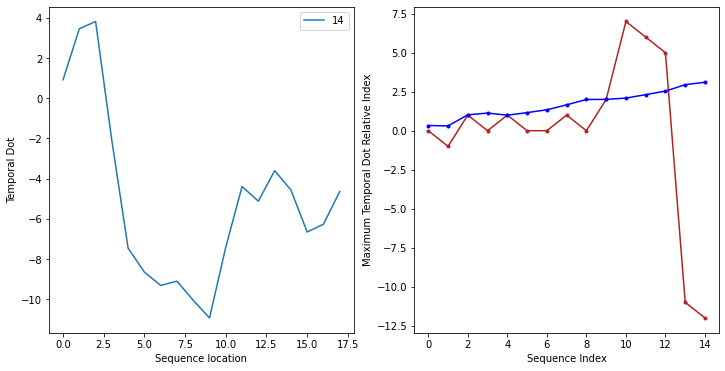

In [ ]:
# Same as above, but no finite look distance, just looks at entire encoder sequence

from scipy.special import softmax

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])

dot_vals = np.zeros((dec_len, enc_len))

for seq_idx in range(dec_len):
  dot_vals[seq_idx, :] = np.dot(avg_hs[:enc_len], avg_hs[enc_len + seq_idx])

avg_offset = analysis.find_scan_offset(hs_data, toy_params)

print('Average offset', avg_offset)

avg_hs_mags = np.array([np.linalg.norm(hs_time) for hs_time in avg_hs])
avg_hs_angles = np.array([analysis.angle_degrees(avg_hs[i], avg_hs[i+1]) for i in range(avg_hs.shape[0]-1)])
avg_hs_rel_angles = np.array([analysis.angle_degrees(avg_hs[i], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles1 = np.array([analysis.angle_degrees(avg_hs[i+1], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles2 = np.array([analysis.angle_degrees(avg_hs[i+2], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles3 = np.array([analysis.angle_degrees(avg_hs[i+3], avg_hs[enc_len+i]) for i in range(dec_len)])

# for ld_idx in range(2*look+1):


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# for seq_idx in range(dec_len):
#   ax1.plot([i for i in range(enc_len)], dot_vals[seq_idx], label=str(seq_idx))
ax1.plot([i for i in range(enc_len)], dot_vals[14], label=str(14))
ax1.set_ylabel('Temporal Dot')
ax1.set_xlabel('Sequence location')
ax1.legend()

max_dot_idx = np.argmax(dot_vals, axis=1)
print('Max dot index:', max_dot_idx)

ax2.plot([i for i in range(dec_len)], [max_dot_idx[i] - i for i in range(max_dot_idx.shape[0])], color='firebrick', marker='.')
ax2.plot([i for i in range(dec_len)], avg_offset[:dec_len], color='b', marker='.')

ax2.set_ylabel('Maximum Temporal Dot Relative Index')
ax2.set_xlabel('Sequence Index')

Finding average hidden state at each time step...


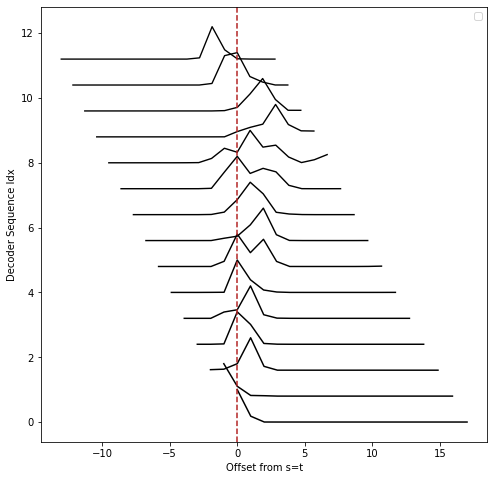

In [ ]:
avg_hs = find_avg_hs(hs, hs_data, toy_params)

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])

dot_vals = np.zeros((dec_len, enc_len))

for seq_idx in range(dec_len):
  raw_dots = softmax(np.dot(avg_hs[:enc_len], avg_hs[enc_len+seq_idx]))
  # Normalizes dot product between 0 and 1
  dot_vals[seq_idx, :] = (raw_dots - np.min(raw_dots))/(np.max(raw_dots)-np.min(raw_dots))

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# for seq_idx in range(dec_len):
#   ax1.plot([i-seq_idx for i in range(enc_len)], dot_vals[seq_idx], label=str(seq_idx+look_dist))

# Generate line plots
lines = []
for seq_idx in range(dec_len):
  # Small reduction of the X extents to get a cheap perspective effect
  xscale = 1 - seq_idx / 200.
  # Same for linewidth (thicker strokes on bottom)
  lw = 1.5 - seq_idx / 100.0
  line, = ax1.plot([xscale *(i-seq_idx) for i in range(enc_len)], 0.8*seq_idx + dot_vals[seq_idx], color='k', lw=lw)
  lines.append(line)

ax1.axvline(0.0, color='firebrick', linestyle='dashed')
ax1.set_ylabel('Decoder Sequence Idx')
ax1.set_xlabel('Offset from s=t')
ax1.legend()


In [ ]:
# Create new Figure with black background
fig = plt.figure(figsize=(8, 8), facecolor='black')

# Add a subplot with no frame
ax = plt.subplot(111, frameon=False)

# Generate random data
data = np.random.uniform(0, 1, (64, 75))
X = np.linspace(-1, 1, data.shape[-1])
G = 1.5 * np.exp(-4 * X ** 2)

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 200.
    # Same for linewidth (thicker strokes on bottom)
    lw = 1.5 - i / 100.0
    line, = ax.plot(xscale * X, i + G * data[i], color="w", lw=lw)
    lines.append(line)

# Set y limit (or first line is cropped because of thickness)
ax.set_ylim(-1, 70)

Finding average hidden state at each time step...
Mean difference: 0.12108518748612396
Mean angle: 6.9072203871220035


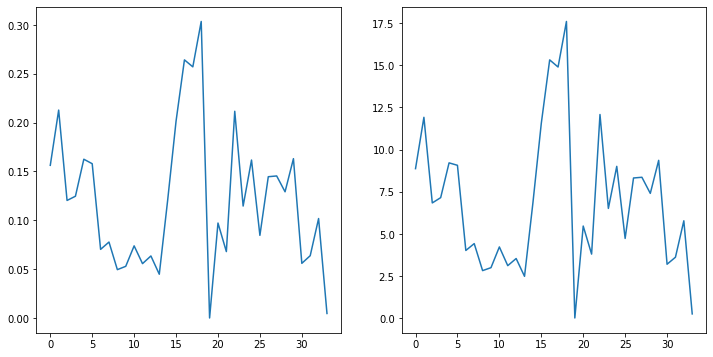

In [ ]:
# Checks to see how close the null input is to the average hidden state.

avg_hs = find_avg_hs(hs, hs_data, toy_params)

null_input = hs['special'][-1]

diffs = avg_hs - null_input
diff_ratio = np.linalg.norm(diffs, axis=1)/np.linalg.norm(avg_hs, axis=1)
angles = np.array([angle_degrees(null, avg) for null, avg in zip(null_input, avg_hs)])
print('Mean difference:', np.mean(diff_ratio))
print('Mean angle:', np.mean(angles))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(diff_ratio)
ax2.plot(angles, )

Minimum angle: 66.83707147516884
Maximum angle: 115.14109578759171


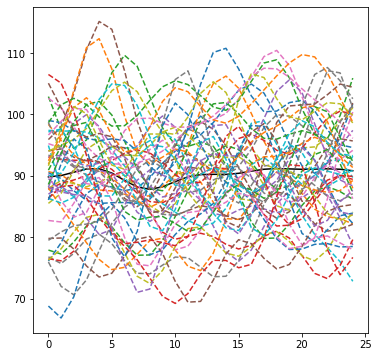

In [ ]:
seq_length_test = 25
word_dims = 50
test_seq = np.zeros((1, seq_length_test, word_dims))

pos_enc_params = {'pos_enc': True, 'time_scale': 100.0, 'amplitude': 1.0}

random_pos_enc_rot = rvs(word_dims)
# random_pos_enc_rot = np.identity(word_dims)  

pos_enc = positional_encoding(test_seq, scale=pos_enc_params['time_scale'], amp=pos_enc_params['amplitude'], 
                              rot=random_pos_enc_rot)

pe_vec = pos_enc[0]

dots = np.zeros((word_dims, seq_length_test)) 
for dim_idx in range(word_dims):
  one_hot_vec = np.zeros((word_dims))
  one_hot_vec[dim_idx] = 1.0
  for seq_idx in range(seq_length_test):
    dots[dim_idx, seq_idx] = 180/np.pi * np.arccos(np.dot(pe_vec[seq_idx], one_hot_vec)/(np.linalg.norm(pe_vec[seq_idx])*np.linalg.norm(one_hot_vec)))

avg_dots = np.mean(dots, axis=0)

print('Minimum angle:', np.min(dots))
print('Maximum angle:', np.max(dots))

fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
ax1.plot([i for i in range(seq_length_test)], avg_dots, color='k', linestyle='solid')
for dim_idx in range(word_dims):
  ax1.plot([i for i in range(seq_length_test)], dots[dim_idx],  linestyle='dashed')

In [ ]:
# Decoposes a word's dot product into the different components, uses the average hidden states for a 
# given word to do the calculation.

from scipy.special import softmax

look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

latch_words = ['exercise', 'I_EXER2'] # Input-Output pair to test
other_in_words = ['<.>',]

align_vals = np.zeros((len(other_in_words), 2*look_dist+1, 2*look_dist+1))

for word_idx in range(len(other_in_words)):
  for os_idx in range(2*look_dist+1):
    offset = os_idx - look_dist
    align_vals_offset = np.zeros((min_len-2*look_dist, 2*look_dist+1))
    base = avg_hs_word_enc[toy_params['in_words'].index(other_in_words[0])]

    for seq_idx in range(min_len-2*look_dist):
      enc_loc = look_dist + seq_idx + offset # Location of latch word in input
      dec_loc = look_dist + seq_idx # Location of latch word in output

      # print('Enc loc', enc_loc)
      # Fills encoder sequence with other word
      enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
      # Makes sequence index the latch word
      enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

      # print((base == enc_seq)[:, :2])

      soft_max_vals = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :]))
      # print(soft_max_vals)
      # print(soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1])
      # print(dfsdfsd)

      align_vals_offset[seq_idx, :] = soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1]

    align_vals[word_idx, os_idx] = np.mean(align_vals_offset, axis=0)
# Averages over all other words:
align_vals = np.mean(align_vals, axis=0)

dot_vals = np.zeros((len(other_in_words), 2*look_dist+1, 5))

offset = -1 # Negative means encoder location is before decoder locat

for word_idx in range(len(other_in_words)):
  dot_vals_seq = np.zeros((min_len-2*look_dist, 2*look_dist+1, 5))
  for seq_idx in range(min_len-2*look_dist):
    enc_loc = look_dist + seq_idx + offset # Location of latch word in input
    dec_loc = look_dist + seq_idx # Location of latch word in output

    enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
    # Makes sequence index the latch word
    enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

    # print((base == enc_seq)[:, :2])

    dot_vals_seq[seq_idx, :, 0] = np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 1] = np.dot(avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 2] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 3] = np.dot(avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 4] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]

  dot_vals[word_idx] = np.mean(dot_vals_seq, axis=0)
# Averages over all other words:
dot_vals = np.mean(dot_vals, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.matshow(align_vals, cmap=plt.cm.Blues)
ax1.set_ylabel(f'Relative sequence location of \'{latch_words[0]}\' and \'{latch_words[1]}\' (enc-dec)')
ax1.set_xlabel('Relative sequence location')

ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,0], color='k', 
         marker='.', linestyle='solid', label='Full Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,1], color='k', 
         marker='.', linestyle='dotted', label='Temporal Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,2], color='k', 
         marker='.', linestyle='dashed', label='Word Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,3], color='r', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Word')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,4], color='g', 
         marker='.', linestyle='dashed', label='Enc Word . Dec Time')
ax2.set_ylabel('Dot product for offset = ' + str(offset))
ax2.set_xlabel('Relative sequence location')
ax2.legend()

for i in range(align_vals.shape[1]):
  for j in range(align_vals.shape[0]):
    c = align_vals[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax2.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

Using minimum sequence length of: 17


NameError: ignored

In [ ]:
latch_words = ['left', 'I_TURN_LEFT'] # Input-Output pair to test
# latch_words = ['walk', 'I_WALK'] # Input-Output pair to test
latch_idx = [toy_params['in_words'].index(latch_words[0]), toy_params['out_words'].index(latch_words[1])]

dot_vals = []

offset = 1

for h_idx in range(10,20):

  in_idx = hs_data['in_index'][h_idx]
  out_idx = hs_data['out_index'][h_idx]
  min_len = np.min([in_idx, out_idx])

  enc_phrase = hs['all'][h_idx][:min_len+1]
  dec_phrase = hs['all'][h_idx][enc_len:enc_len+min_len+1]
  in_latch_locs = np.argmax(hs_data['inputs'][h_idx][:min_len+1], axis=1) == latch_idx[0]
  out_latch_locs = np.argmax(hs_data['labels'][h_idx][:min_len+1], axis=1) == latch_idx[1]

  print('Inputs:', in_latch_locs)
  print('Outputs:', out_latch_locs)

  # Finds locations in phrase where latches have the given offset
  if offset == 0: # No shift to input phrase
    locs = np.logical_and(in_latch_locs, out_latch_locs)
  elif offset > 0: # Shifts input phrase upwards
    locs = np.logical_and(in_latch_locs[offset:], out_latch_locs[:-offset]) 
  else: # Shifts input phrase backwards
    locs = np.logical_and(in_latch_locs[:offset], out_latch_locs[-offset:])

  # Finds all valid locations, eliminating idxs that are within look_dist of start or end of phrase
  if offset >= 0:
    latch_locs = [i for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 
  else: # Need to add offset since started at idx=offset when comparing
    latch_locs = [i - offset for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 

  print('Latch locations:', latch_locs)

  # Calculates aligns
  aligns = np.dot(dec_phrase, enc_phrase.T)

  for latch_loc in latch_locs:
    dot_vals.append(aligns[latch_loc, latch_loc-look_dist:latch_loc+look_dist+1])

print(np.asarray(dot_vals).shape)
print(np.mean(np.asarray(dot_vals), axis=0))

Inputs: [False False False False False False  True False False False False False
 False False  True]
Outputs: [False False False False  True False False False False False False  True
 False False False]
Latch locations: []
Inputs: [False False False  True False False False False False False False]
Outputs: [False  True False False False False False False False False False]
Latch locations: []
Inputs: [False  True False False  True False False False False False False]
Outputs: [ True False  True False False False False False False False False]
Latch locations: []
Inputs: [False False False False False False False False False False False False
  True False False]
Outputs: [False False False False False False False False False  True False  True
 False False False]
Latch locations: [11]
Inputs: [False False False False False False  True False False False False False
  True False]
Outputs: [False False False False  True False False False False  True False False
 False False]
Latch locations

### Multihead Analysis

In [113]:
# Calculate attention matrix via apply function
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]

all_logits, context_vecs, context_totals = apply_fun(final_params, hs_data['inputs'], hs_data['in_index'], 
                                                     returns={'context_vector', 'context_total'})

All heads: phrase_acc 0.9320 word_acc: 0.9904
Head 0: phrase_acc 0.0000 word_acc: 0.4005
Head 1: phrase_acc 0.0000 word_acc: 0.4149
Head 2: phrase_acc 0.0000 word_acc: 0.3173
Head 3: phrase_acc 0.0000 word_acc: 0.3199
Head 4: phrase_acc 0.0000 word_acc: 0.3006
Head 5: phrase_acc 0.0000 word_acc: 0.3408
Head 6: phrase_acc 0.0000 word_acc: 0.3668
Head 7: phrase_acc 0.0000 word_acc: 0.3622
Head 8: phrase_acc 0.0000 word_acc: 0.3551
Head 9: phrase_acc 0.0000 word_acc: 0.3412
Head 10: phrase_acc 0.0000 word_acc: 0.4867
Head 11: phrase_acc 0.0000 word_acc: 0.3891
Head 12: phrase_acc 0.0000 word_acc: 0.3366
Head 13: phrase_acc 0.0000 word_acc: 0.4319
Head 14: phrase_acc 0.0000 word_acc: 0.3792
Head 15: phrase_acc 0.0000 word_acc: 0.3062


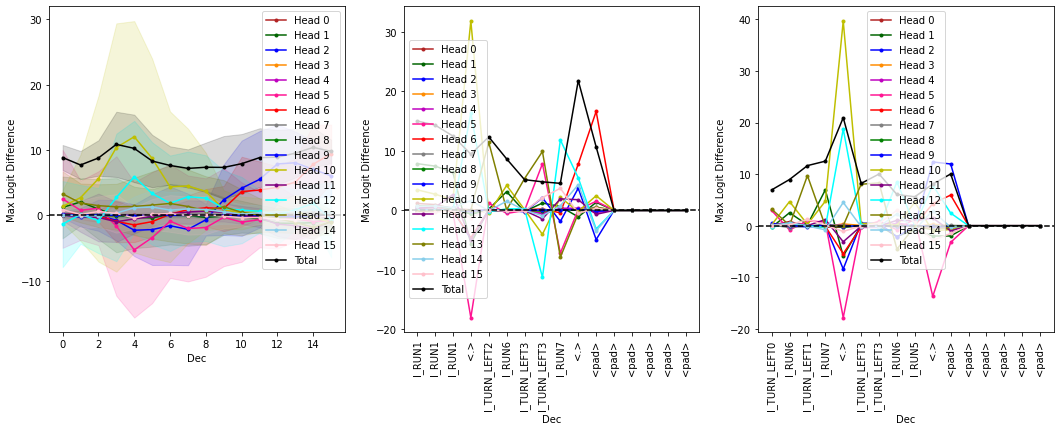

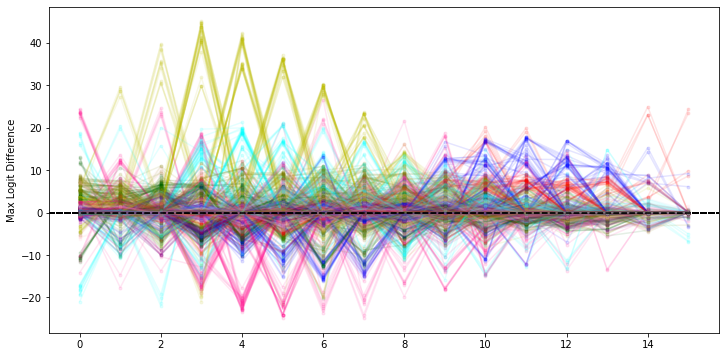

In [114]:
phrase_idxs = [1, 3]

v_size = rnn_specs['v_size']
# Mask for zeroing out beyond end index (and for computing averages) (trials, dec_len)
masks = (hs_data['out_index'][:, np.newaxis] >= np.arange(dec_len))
# Ratios of head contribution to context vector and full context vector
head_ratios = np.zeros((len(all_logits), rnn_specs['attn_heads'], dec_len))
# Difference between maximum logit and second largest logit
head_ro_diffs = np.zeros((len(all_logits), rnn_specs['attn_heads'] + 1, dec_len))
head_xe = np.zeros((len(all_logits), rnn_specs['attn_heads'] + 1, dec_len))
ro_contrib = np.zeros((rnn_specs['attn_heads'], all_logits.shape[0], dec_len, all_logits.shape[2]))
for dec_idx in range(dec_len):
    # Contributions to readout from each head
    for head_idx in range(rnn_specs['attn_heads']):
        context_head = np.zeros((len(all_logits), rnn_specs['attn_heads']*v_size))
        # Fills in portion of head
        context_head[:, head_idx*v_size:(head_idx+1)*v_size] = np.array(context_totals)[:, dec_idx, head_idx*v_size:(head_idx+1)*v_size]
        # Calculates contribution to context_vector from given head, also applying mask
        head_contrib = np.einsum('j, jk -> jk', masks[:, dec_idx], attn_apply[-1](context_head))
        head_ratios[:, head_idx, dec_idx] = (np.linalg.norm(head_contrib, axis=1) 
            / np.linalg.norm(np.array(context_vecs)[:, dec_idx, :], axis=1))
        
        ro_contrib[head_idx, :, dec_idx, :] = np.copy(ro_apply(head_contrib))

    total_ro = np.copy(np.sum(ro_contrib[:, :, dec_idx, :], axis=0))[:, :len(toy_params['out_words_pp'])] # Sum over heads
    # print('By hand:', total_ro[0,:3], ', Direct:', all_logits[0, dec_idx, :3])
    sort_idxs = total_ro.argsort(axis=1)[:, -2:] # Gets maximum two indices of total readout (ignores pad idxs)
    head_ro_diffs[:, -1, dec_idx] = np.array([total_ro[idx, sort_idxs[idx, 1]] - total_ro[idx, sort_idxs[idx, 0]] 
                                             for idx in range(total_ro.shape[0])])
    for head_idx in range(rnn_specs['attn_heads']):
        head_ro_diffs[:, head_idx, dec_idx] = np.array(
            [ro_contrib[head_idx, idx, dec_idx, sort_idxs[idx, 1]] - ro_contrib[head_idx, idx, dec_idx, sort_idxs[idx, 0]] 
             for idx in range(total_ro.shape[0])])

# Calculates cross entropy and prints accuracies
phrase_acc, word_acc = analysis.logit_accuracy(np.sum(ro_contrib, axis=0), hs_data['labels'], hs_data['out_index'])
print(f'All heads: phrase_acc {phrase_acc:0.4f} word_acc: {word_acc:0.4f}')
head_xe[:, -1, :] = analysis.cross_entropy(np.sum(ro_contrib, axis=0), hs_data['labels'], hs_data['out_index'])
for head_idx in range(rnn_specs['attn_heads']):
    phrase_acc, word_acc = analysis.logit_accuracy(ro_contrib[head_idx], hs_data['labels'], hs_data['out_index'])
    print(f'Head {head_idx}: phrase_acc {phrase_acc:0.4f} word_acc: {word_acc:0.4f}')
    head_xe[:, head_idx, :] =  analysis.cross_entropy(ro_contrib[head_idx], hs_data['labels'], hs_data['out_index'])

fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(18,6))
for head_idx in range(rnn_specs['attn_heads']):
    # ax1.plot(np.arange(dec_len), np.mean(head_ratios[:, head_idx, :], axis=0), 
    #          label=f'Head {head_idx}', color=state_colors[head_idx])
    mean_ro_diff = np.average(head_ro_diffs[:, head_idx, :], axis=0, weights=masks)
    std_ro_diff = analysis.mask_std(head_ro_diffs[:, head_idx, :], axis=0, weights=masks)

    ax2.plot(np.arange(dec_len), mean_ro_diff, label=f'Head {head_idx}', color=state_colors[head_idx], marker='.')
    ax2.fill_between(np.arange(dec_len), mean_ro_diff+std_ro_diff, mean_ro_diff-std_ro_diff,
                     alpha=0.15, color=state_colors[head_idx])
mean_ro_diff = np.average(head_ro_diffs[:, -1, :], axis=0, weights=masks)
std_ro_diff = analysis.mask_std(head_ro_diffs[:, -1, :], axis=0, weights=masks)
ax2.plot(np.arange(dec_len), mean_ro_diff, label='Total', color='k', marker='.')
ax2.fill_between(np.arange(dec_len), mean_ro_diff+std_ro_diff, mean_ro_diff-std_ro_diff,
                 alpha=0.15, color='k')
ax2.axhline(0.0, color='k', linestyle='dashed')
# ax1.legend()
ax2.legend()

# ax1.set_ylabel('Magnitude Ratio')
ax2.set_ylabel('Max Logit Difference')

# fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,6))

for phrase_idx, ax in zip(phrase_idxs, (ax3, ax4)):
    for head_idx in range(rnn_specs['attn_heads']):
        ax.plot(np.arange(dec_len), head_ro_diffs[phrase_idx, head_idx, :], marker='.', 
                label=f'Head {head_idx}', color=state_colors[head_idx])
    ax.plot(np.arange(dec_len), head_ro_diffs[phrase_idx, -1, :],
                label=f'Total', color='k' , marker='.')
    ax.axhline(0.0, color='k', linestyle='dashed')
    ax.set_ylabel('Max Logit Difference')

    x_labels = toy.tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['out_words'])
    # x_labels = toy.tensorToPhrase(hs_data['inputs'][phrase_idx], toy_params['in_words'])
        
    ax.set_xticks(np.arange(dec_len))
    ax.set_xticklabels(x_labels, rotation=90)

fig3, ax5 = plt.subplots(1, 1, figsize=(12,6))

for phrase_idx in range(100):
    for head_idx in range(rnn_specs['attn_heads']):
        ax5.plot(np.arange(dec_len), head_ro_diffs[phrase_idx, head_idx, :], marker='.',
                label=f'Head {head_idx}', color=state_colors[head_idx], alpha=0.1)
    ax5.axhline(0.0, color='k', linestyle='dashed')
ax5.set_ylabel('Max Logit Difference')

for ax in (ax2, ax3, ax4):
    ax.set_xlabel('Dec')
    ax.legend()

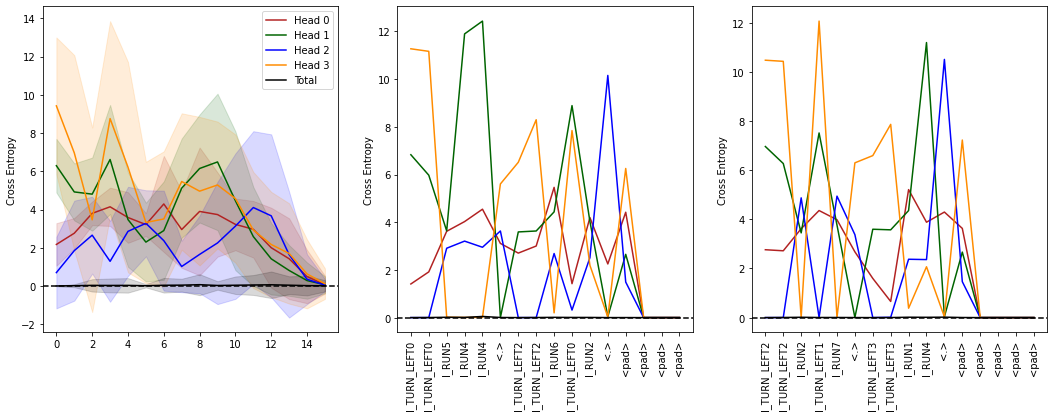

In [63]:
# Plots cross entropy results

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
for head_idx in range(rnn_specs['attn_heads']):
    mean_ro_diff = np.mean(head_xe[:, head_idx, :], axis=0)
    std_ro_diff = np.std(head_xe[:, head_idx, :], axis=0)

    ax1.plot(np.arange(dec_len), mean_ro_diff, label=f'Head {head_idx}', color=state_colors[head_idx])
    ax1.fill_between(np.arange(dec_len), mean_ro_diff+std_ro_diff, mean_ro_diff-std_ro_diff,
                     alpha=0.15, color=state_colors[head_idx])
mean_ro_diff = np.mean(head_xe[:, -1, :], axis=0)
std_ro_diff = np.std(head_xe[:, -1, :], axis=0)
ax1.plot(np.arange(dec_len), mean_ro_diff, label='Total', color='k')
ax1.fill_between(np.arange(dec_len), mean_ro_diff+std_ro_diff, mean_ro_diff-std_ro_diff,
                 alpha=0.15, color='k')
ax1.axhline(0.0, color='k', linestyle='dashed')
ax1.legend()

ax1.set_ylabel('Cross Entropy')

phrase_idxs = [1, 3]

for phrase_idx, ax in zip(phrase_idxs, (ax2, ax3)):
    for head_idx in range(rnn_specs['attn_heads']):
        ax.plot(np.arange(dec_len), head_xe[phrase_idx, head_idx, :], 
                label=f'Head {head_idx}', color=state_colors[head_idx])
    ax.plot(np.arange(dec_len), head_xe[phrase_idx, -1, :],
                label=f'Total', color='k')
    ax.axhline(0.0, color='k', linestyle='dashed')
    ax.set_ylabel('Cross Entropy')

    x_labels = toy.tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['out_words'])
    # x_labels = toy.tensorToPhrase(hs_data['inputs'][phrase_idx], toy_params['in_words'])
        
    ax.set_xticks(np.arange(dec_len))
    ax.set_xticklabels(x_labels, rotation=90)

Logits Max: 41.69841384887695
Logits Min: -32.30404178912823
Std Max: 33.7484092409991
Std Min: 0.0
Logits Max: 11.610074155671256
Logits Min: -11.241273237548711
Std Max: 10.698463415674762
Std Min: 0.0
Logits Max: 36.44362784937808
Logits Min: -18.946177353461582
Std Max: 30.568870737474118
Std Min: 0.0
Logits Max: 17.234134849749115
Logits Min: -18.620440339219982
Std Max: 13.05195091395239
Std Min: 0.0


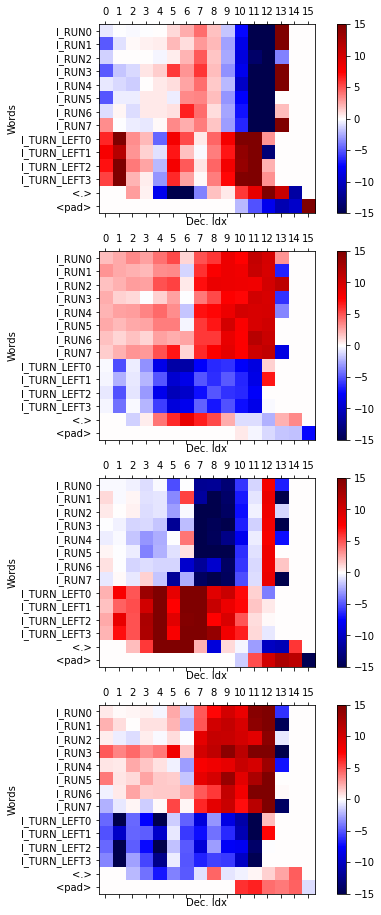

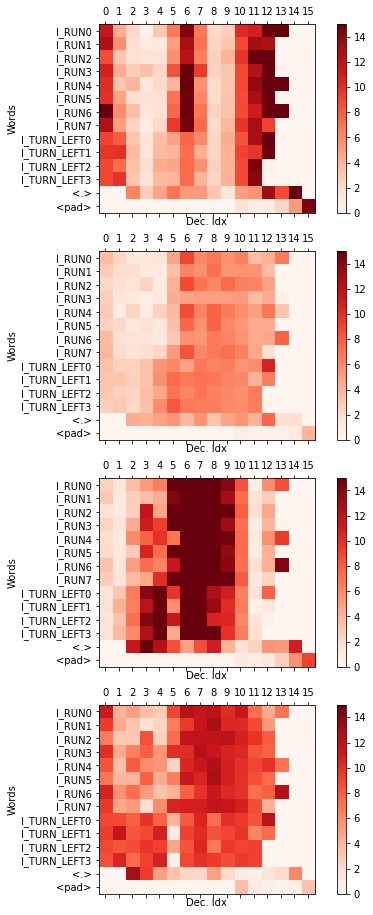

In [32]:
# For each head, averages over all trials to see if there are trends in logit difference as a function of output word and decoder time step

# Label by decoder ouput (assumes its ouputting targets)
words = toy_params['out_words_pp']
lablels = [np.argmax(inp, axis=1) for inp in hs_data['labels']]
# # Label by decoder input
# words = toy_params['out_words_pp'] + ['<BoS>',]
# lablels = hs_data['dec_inputs']
# # Label by input
# words = toy_params['in_words_pp']
# lablels = [np.argmax(inp, axis=1) for inp in hs_data['inputs']]

head_logits = np.zeros((rnn_specs['attn_heads'], dec_len, len(words)))
head_logits_std = np.zeros((rnn_specs['attn_heads'], dec_len, len(words)))

for dec_idx in range(dec_len):
    for head_idx in range(rnn_specs['attn_heads']):
        for word_idx in range(len(words)):
            word_ro_diffs = np.array(
                [head_ro_diffs[idx, head_idx, dec_idx] for idx, lbl, out_idx in 
                 zip(range(len(all_logits)), lablels, hs_data['out_index']) 
                 if lbl[dec_idx] == word_idx and dec_idx <= out_idx])
            if word_ro_diffs.shape[0] > 0:
                head_logits[head_idx, dec_idx, word_idx] = np.mean(word_ro_diffs, axis=0)
                head_logits_std[head_idx, dec_idx, word_idx] = np.std(word_ro_diffs, axis=0)
                # head_logits_std[head_idx, dec_idx, word_idx] = (
                #     np.std(word_ro_diffs, axis=0) / np.abs(np.mean(word_ro_diffs, axis=0)))

fig, mean_axs = plt.subplots(rnn_specs['attn_heads'], 1, figsize=(8,4*rnn_specs['attn_heads']))
fig2, std_axs = plt.subplots(rnn_specs['attn_heads'], 1, figsize=(8,4*rnn_specs['attn_heads']))

if rnn_specs['attn_heads'] == 1:
    mean_axs, std_axs = (mean_axs,), (std_axs,)

for head_idx, ax, ax_std in zip(range(rnn_specs['attn_heads']), mean_axs, std_axs):
   
    print('Logits Max:', np.max(head_logits[head_idx]))
    print('Logits Min:', np.min(head_logits[head_idx]))

    cm = ax.matshow(head_logits[head_idx].T, cmap=plt.cm.seismic, vmin=-15, vmax=15)
    fig.colorbar(cm, ax=ax)

    print('Std Max:', np.max(head_logits_std[head_idx]))
    print('Std Min:', np.min(head_logits_std[head_idx]))

    cm = ax_std.matshow(head_logits_std[head_idx].T, cmap=plt.cm.Reds, vmin=0, vmax=15)
    fig2.colorbar(cm, ax=ax_std)

    for axp in (ax, ax_std):
        axp.set_ylabel('Words')
        axp.set_xlabel('Dec. Idx')

        axp.set_xticks(np.arange(dec_len))
        axp.set_yticks(np.arange(len(words)))
        axp.set_xticklabels(np.arange(dec_len), rotation=0)
        axp.set_yticklabels(words, rotation=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


nan
nan
nan
nan


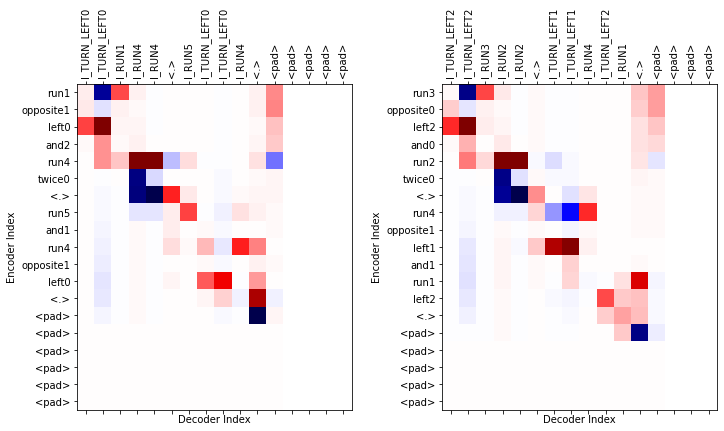

In [50]:
phrase_idxs = [0, 1]

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

for phrase_idx, ax in zip(phrase_idxs, (ax1, ax2)):
    comp_att_matrix = np.zeros((enc_len, dec_len))
    for head_idx in range(rnn_specs['attn_heads']):
        row_weights = head_ro_diffs[phrase_idx, head_idx, :] / head_ro_diffs[phrase_idx, -1, :]
        comp_att_matrix += attn_matrix_dir[phrase_idx, :, :, head_idx] * row_weights

    print(np.max(comp_att_matrix))
    print(np.min(comp_att_matrix))

    ax.matshow(comp_att_matrix, cmap=plt.cm.seismic, vmin=-2, vmax=2)

    enc_labels = toy.tensorToPhrase(hs_data['inputs'][phrase_idx], toy_params['in_words'])
    dec_labels = toy.tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['out_words'])

    ax.set_ylabel('Encoder Index')
    ax.set_xlabel('Decoder Index')

    ax.set_xticks(np.arange(dec_len))
    ax.set_yticks(np.arange(enc_len))
    ax.set_yticklabels(enc_labels, rotation=0)
    ax.set_xticklabels(dec_labels, rotation=90)

Finding average hidden state at each time step...
Finding average hidden state at each time step...
Head: 0, Max dot: 3.6875858264849355, Min dot: -3.023988291204595
Head: 1, Max dot: 6.138249102379903, Min dot: -3.948543612762584
Head: 2, Max dot: 14.159992717105018, Min dot: -7.368621955033824
Head: 3, Max dot: 10.273378432608494, Min dot: -5.442871757614309
Head: 4, Max dot: 8.960746780076455, Min dot: -2.600158256205696
Head: 5, Max dot: 8.018148346972339, Min dot: -13.355873874966493
Head: 6, Max dot: 15.602205436645427, Min dot: -22.195701821044608
Head: 7, Max dot: 12.01067784398139, Min dot: -4.57103328555829


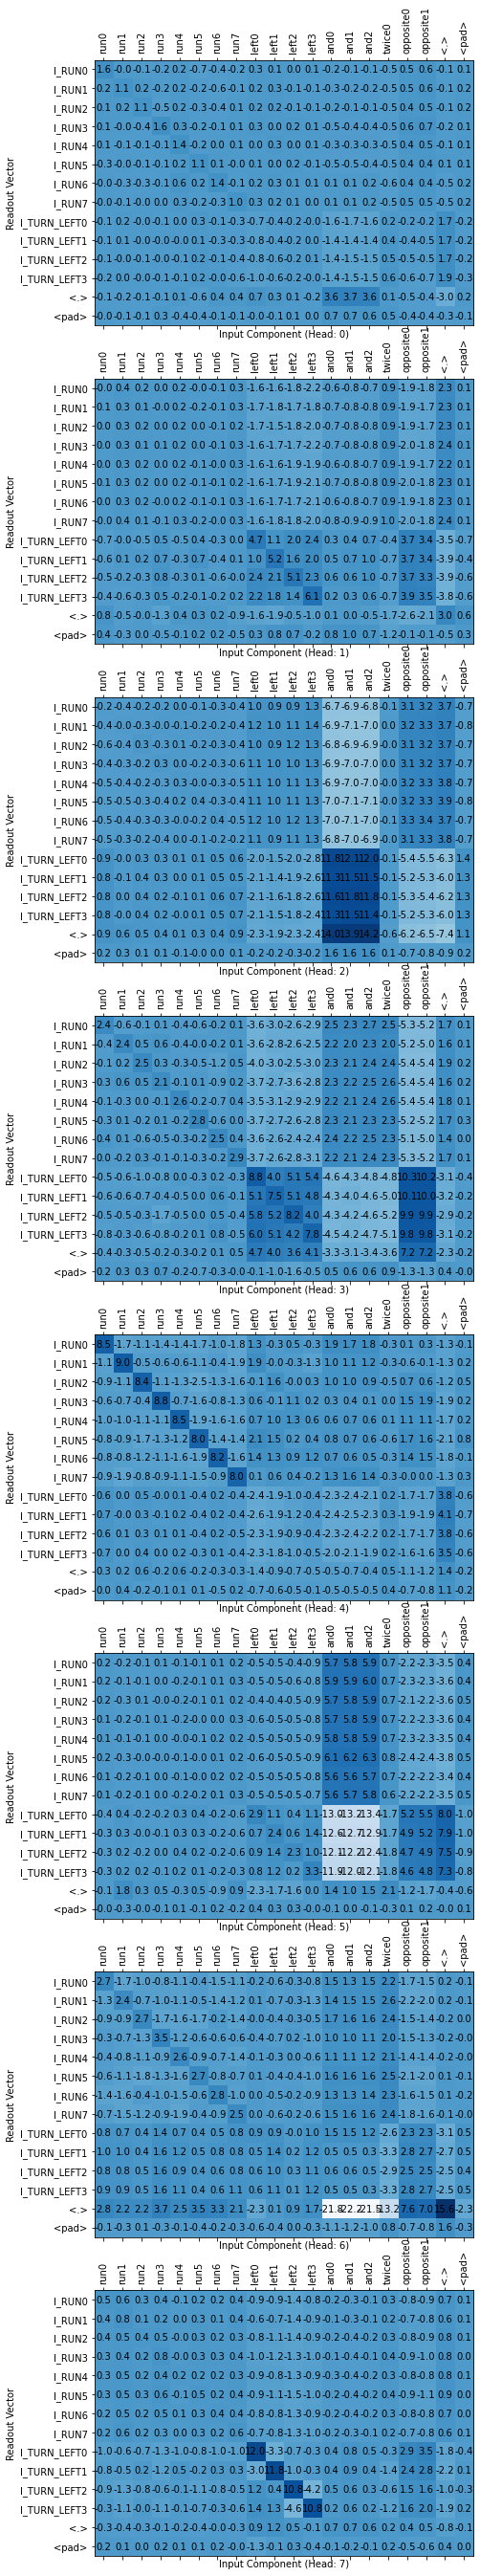

In [21]:
# Plots alignments between readout vectors and input components for each head
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

ic_enc, ic_dec = analysis.calculate_input_components(hs, hs_data, toy_params, rnn_specs)

fig, axs = plt.subplots(rnn_specs['attn_heads'], 1, figsize=(8,6*rnn_specs['attn_heads']))

readout_avg_dots = np.zeros((rnn_specs['attn_heads'], readout.shape[0], len(toy_params['in_words_pp'])))

for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):

    # Projections for various types of learnable attention
    _, _, att_params, _ = final_params
    _, _, v_mat = att_params[0][head_idx]
    co_mat = att_params[1][head_idx*rnn_specs['v_size']:(head_idx+1)*rnn_specs['v_size'], :]
    word_proj = np.matmul(v_mat, co_mat) # Both values and context_out projection for given head

    ic_enc_proj = np.matmul(ic_enc, word_proj) 

    for ro_idx in range(readout.shape[0]):
        for word_idx in range(len(toy_params['in_words_pp'])):
            readout_avg_dots[head_idx, ro_idx, word_idx] = np.dot(readout[ro_idx], ic_enc_proj[word_idx])

    print(f'Head: {head_idx}, Max dot: {np.max(readout_avg_dots[head_idx])}, Min dot: {np.min(readout_avg_dots[head_idx])}')

for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):

    ax.matshow(readout_avg_dots[head_idx], cmap=plt.cm.Blues, vmin=np.min(readout_avg_dots), vmax=np.max(readout_avg_dots))

    for i in range(readout_avg_dots[head_idx].shape[1]):
        for j in range(readout_avg_dots[head_idx].shape[0]):
            c = readout_avg_dots[head_idx, j,i]
            ax.text(i, j, str(round(c, 1)), va='center', ha='center')

    ax.set_xticks([i for i in range(len(toy_params['in_words_pp']))])
    ax.set_xticklabels(toy_params['in_words_pp'], rotation=90)
    ax.set_yticks([i for i in range(len(toy_params['out_words_pp']))])
    ax.set_yticklabels(toy_params['out_words_pp'], rotation=0)
    ax.set_ylabel('Readout Vector')
    ax.set_xlabel(f'Input Component (Head: {head_idx})')

#### Logit Analysis

In [108]:
group_mult = True

word_grouped = np.zeros((len(toy_params['out_words_pp'])))
group_idxs = {}

while not word_grouped.all():
    word_idx = np.where(word_grouped == 0)[0][0] # first non-grouped index
    if toy_params['out_words_pp'][word_idx][-1] == '>': # Special character, so keeps last character of word
        word = toy_params['out_words_pp'][word_idx]
        group_idxs[word] = np.array([word_idx for word_idx in range(len(toy_params['out_words_pp'])) 
                                    if toy_params['out_words_pp'][word_idx] == word])
    else:
        word = toy_params['out_words_pp'][word_idx][:-1]
        group_idxs[word] = np.array([word_idx for word_idx in range(len(toy_params['out_words_pp'])) 
                                    if toy_params['out_words_pp'][word_idx][:-1] == word])
    word_grouped[group_idxs[word]] = 1

for idx, key in enumerate(group_idxs.keys()):
    print(key)

I_RUN
I_TURN_LEFT
<.>
<pad>


Finding average hidden state at each time step...


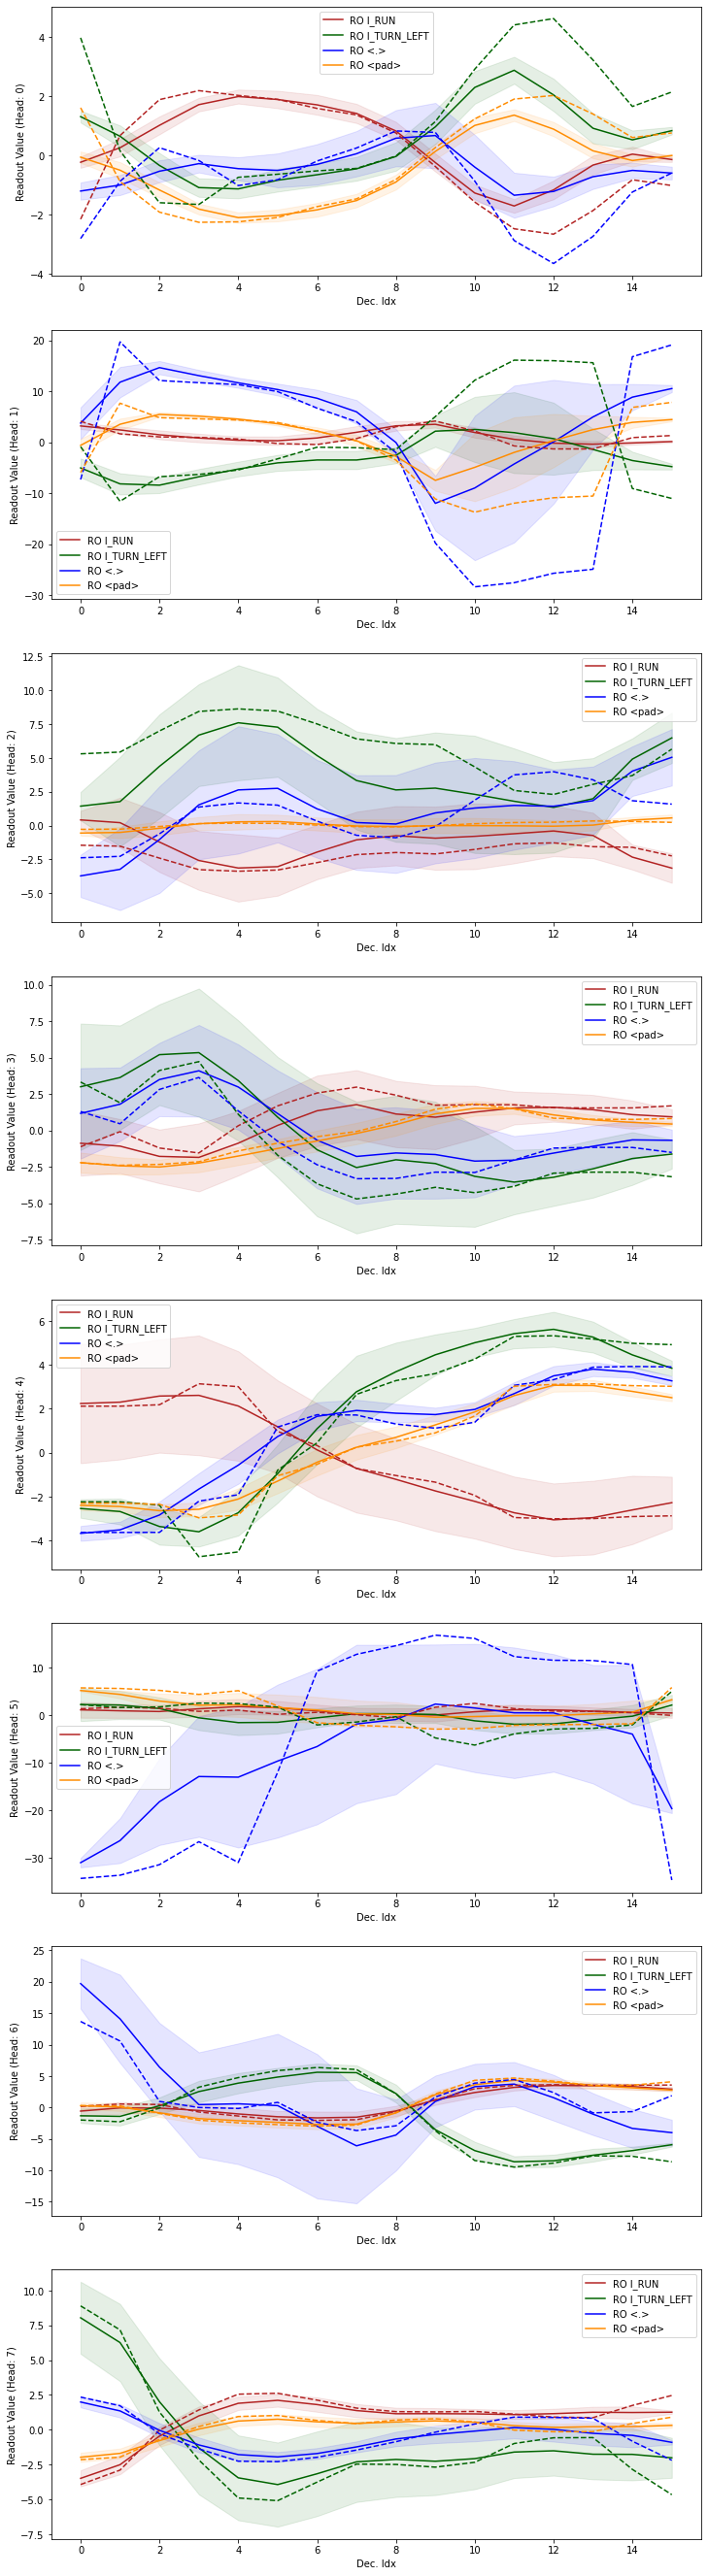

In [23]:
# Plots average readouts (+/- standard deviation) as a function of index for each head
# Also plots the temporal component readout as a function of time step

ro_masks = np.repeat(masks[:, :, np.newaxis], len(toy_params['out_words']), axis=2)

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

fig, axs = plt.subplots(rnn_specs['attn_heads'], 1, figsize=(12,6*rnn_specs['attn_heads']))
_, _, att_params, _ = final_params

if rnn_specs['attn_heads'] == 1: axs = (axs,)

for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):

    mean_ro_contrib = np.average(ro_contrib[head_idx], axis=0, weights=ro_masks)[:, :len(toy_params['out_words_pp'])]
    std_ro_contrib = analysis.mask_std(ro_contrib[head_idx], axis=0, weights=ro_masks)[:, :len(toy_params['out_words_pp'])]

    for idx, key in enumerate(group_idxs.keys()):
        group_ro_contrib = np.mean(mean_ro_contrib[:, group_idxs[key]], axis=1)
        group_ro_contrib_std = np.mean(std_ro_contrib[:, group_idxs[key]], axis=1)
        ax.plot(np.arange(dec_len), group_ro_contrib, color=state_colors[idx], 
                label='RO ' + key)
        ax.fill_between(np.arange(dec_len), group_ro_contrib + group_ro_contrib_std, 
                        group_ro_contrib - group_ro_contrib_std, color=state_colors[idx],
                        alpha = 0.1)

    # for ro_idx in range(len(toy_params['out_words_pp'])):
    #     ax.plot(np.arange(dec_len), mean_ro_contrib[:, ro_idx], color=state_colors[ro_idx], 
    #             label='RO ' + toy_params['out_words_pp'][ro_idx])
    #     ax.fill_between(np.arange(dec_len), mean_ro_contrib[:, ro_idx] + std_ro_contrib[:, ro_idx], 
    #                     mean_ro_contrib[:, ro_idx] - std_ro_contrib[:, ro_idx], color=state_colors[ro_idx],
    #                     alpha = 0.1)

    _, _, v_mat = att_params[0][head_idx]
    co_mat = att_params[1][head_idx*rnn_specs['v_size']:(head_idx+1)*rnn_specs['v_size'], :]

    attn_align = analysis.get_attn_align(rnn_specs, final_params, head=head_idx)

    # Attention matrix from mean input states
    attn_matrix = np.zeros((enc_len, dec_len))
    enc_seq = avg_hs[:enc_len, :]
    for seq_idx in range(dec_len):
        attn_matrix[:, seq_idx] = softmax(attn_align(enc_seq, avg_hs[enc_len + seq_idx, :]))
    
    avg_hs_context = np.matmul(attn_matrix.T, np.matmul(enc_seq, v_mat))

    temporal_logits = ro_apply(np.matmul(avg_hs_context, co_mat))[:, :len(toy_params['out_words_pp'])]

    for idx, key in enumerate(group_idxs.keys()):
        group_temporal_logits = np.mean(temporal_logits[:, group_idxs[key]], axis=1)
        ax.plot(np.arange(dec_len), group_temporal_logits, color=state_colors[idx], 
                linestyle='dashed')

    # # Logits from full attention matrix, but values are only temporal component
    # approx_context = np.matmul(np.transpose(attn_matrix_dir[:, :, :, head_idx], axes=[0, 2, 1]), np.matmul(enc_seq, v_mat))

    # approx_logits = ro_apply(np.matmul(approx_context, co_mat))[:, :, :len(toy_params['out_words_pp'])]
    # approx_logits = np.average(approx_logits, axis=0, weights=ro_masks[:,:,:len(toy_params['out_words_pp'])])

    # for idx, key in enumerate(group_idxs.keys()):
    #     group_approx_logits = np.mean(approx_logits[:, group_idxs[key]], axis=1)
    #     ax.plot(np.arange(dec_len), group_approx_logits, color='k', 
    #             linestyle='dotted')
        
    # # Logits from null input
    # attn_matrix = np.zeros((enc_len, dec_len))
    # enc_seq = hs['special'][-2, :enc_len, :]
    # for seq_idx in range(dec_len):
    #     attn_matrix[:, seq_idx] = softmax(attn_align(enc_seq, hs['special'][-2, enc_len + seq_idx, :]))
    
    # null_context = np.matmul(attn_matrix.T, np.matmul(enc_seq, v_mat))

    # null_logits = ro_apply(np.matmul(null_context, co_mat))[:, :len(toy_params['out_words_pp'])]

    # for idx, key in enumerate(group_idxs.keys()):
    #     group_null_logits = np.mean(null_logits[:, group_idxs[key]], axis=1)
    #     ax.plot(np.arange(dec_len), group_null_logits, color='k', 
    #             linestyle='dotted')
        
    ax.legend()
    ax.set_ylabel(f'Readout Value (Head: {head_idx})')
    ax.set_xlabel('Dec. Idx')

Finding average hidden state at each time step...


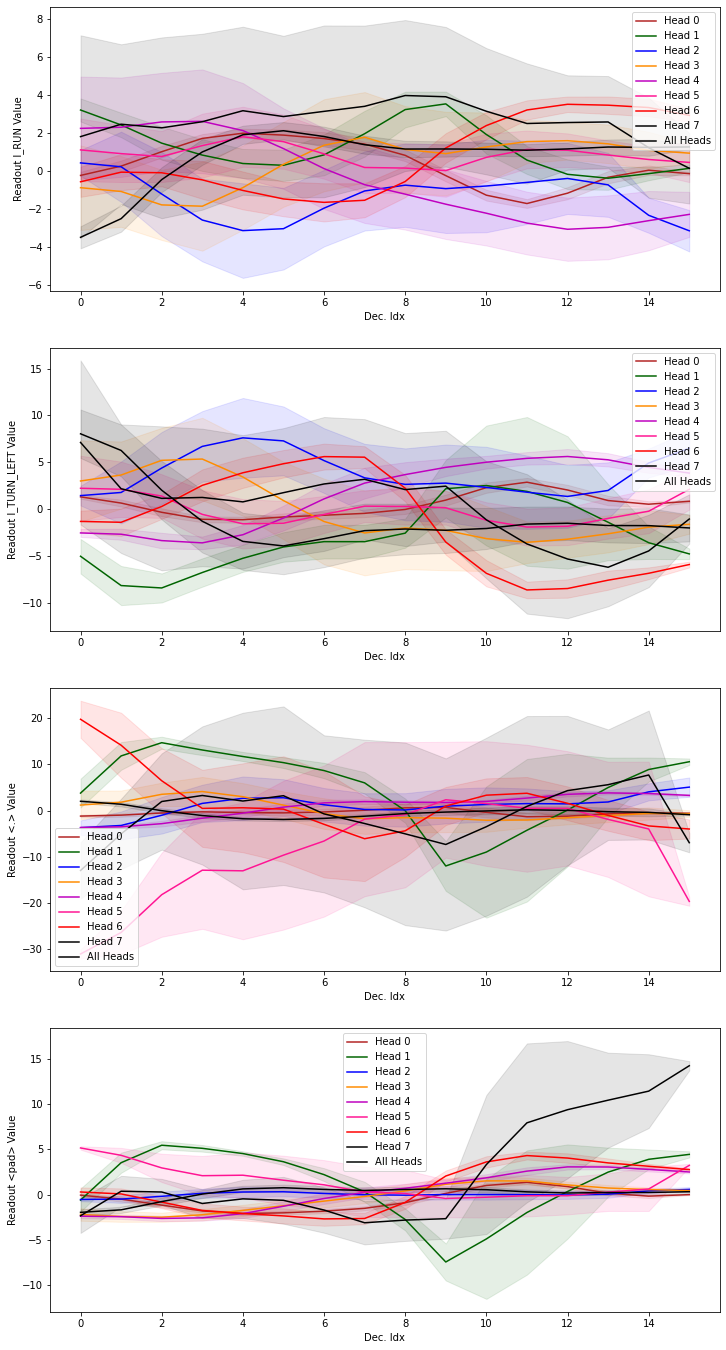

In [25]:
# Same as the above plots, but plots all head contributions to a single readout group on a single plot.

ro_masks = np.repeat(masks[:, :, np.newaxis], len(toy_params['out_words']), axis=2)

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

fig, axs = plt.subplots(len(group_idxs.keys()), 1, figsize=(12,6*len(group_idxs.keys())))
_, _, att_params, _ = final_params

for head_idx in range(rnn_specs['attn_heads']):

    mean_ro_contrib = np.average(ro_contrib[head_idx], axis=0, weights=ro_masks)[:, :len(toy_params['out_words_pp'])]
    std_ro_contrib = analysis.mask_std(ro_contrib[head_idx], axis=0, weights=ro_masks)[:, :len(toy_params['out_words_pp'])]

    for idx, (key, ax) in enumerate(zip(group_idxs.keys(), axs)):
        group_ro_contrib = np.mean(mean_ro_contrib[:, group_idxs[key]], axis=1)
        group_ro_contrib_std = np.mean(std_ro_contrib[:, group_idxs[key]], axis=1)
        ax.plot(np.arange(dec_len), group_ro_contrib, color=state_colors[head_idx], 
                label=f'Head {head_idx}')
        ax.fill_between(np.arange(dec_len), group_ro_contrib + group_ro_contrib_std, 
                        group_ro_contrib - group_ro_contrib_std, color=state_colors[head_idx],
                        alpha = 0.1)

    # for ro_idx in range(len(toy_params['out_words_pp'])):
    #     ax.plot(np.arange(dec_len), mean_ro_contrib[:, ro_idx], color=state_colors[ro_idx], 
    #             label='RO ' + toy_params['out_words_pp'][ro_idx])
    #     ax.fill_between(np.arange(dec_len), mean_ro_contrib[:, ro_idx] + std_ro_contrib[:, ro_idx], 
    #                     mean_ro_contrib[:, ro_idx] - std_ro_contrib[:, ro_idx], color=state_colors[ro_idx],
    #                     alpha = 0.1)

    # _, _, v_mat = att_params[0][head_idx]
    # co_mat = att_params[1][head_idx*rnn_specs['v_size']:(head_idx+1)*rnn_specs['v_size'], :]

    # attn_align = analysis.get_attn_align(rnn_specs, final_params, head=head_idx)

    # # Attention matrix from mean input states
    # attn_matrix = np.zeros((enc_len, dec_len))
    # enc_seq = avg_hs[:enc_len, :]
    # for seq_idx in range(dec_len):
    #     attn_matrix[:, seq_idx] = softmax(attn_align(enc_seq, avg_hs[enc_len + seq_idx, :]))
    
    # avg_hs_context = np.matmul(attn_matrix.T, np.matmul(enc_seq, v_mat))

    # temporal_logits = ro_apply(np.matmul(avg_hs_context, co_mat))[:, :len(toy_params['out_words_pp'])]

    # for idx, (key, ax) in enumerate(zip(group_idxs.keys(), axs)):
    #     group_temporal_logits = np.mean(temporal_logits[:, group_idxs[key]], axis=1)
    #     ax.plot(np.arange(dec_len), group_temporal_logits, color=state_colors[head_idx], 
    #             linestyle='dashed')

    # for ro_idx in range(len(toy_params['out_words_pp'])):
    #     ax.plot(np.arange(dec_len), temporal_logits[:, ro_idx], color=state_colors[ro_idx], 
    #             linestyle='dashed')
        
    # avg_hs_context = np.matmul(np.transpose(attn_matrix_dir[:, :, :, head_idx], axes=[0, 2, 1]), np.matmul(enc_seq, v_mat))

    # temporal_logits = ro_apply(np.matmul(avg_hs_context, co_mat))[:, :, :len(toy_params['out_words_pp'])]
    # temporal_logits = np.average(temporal_logits, axis=0, weights=ro_masks[:,:,:len(toy_params['out_words_pp'])])

    # for idx, (key, ax) in enumerate(zip(group_idxs.keys(), axs)):
    #     group_temporal_logits = np.mean(temporal_logits[:, group_idxs[key]], axis=1)
    #     ax.plot(np.arange(dec_len), group_temporal_logits, color='k', 
    #             linestyle='dotted')

    # for ro_idx in range(len(toy_params['out_words_pp'])):
    #     ax.plot(np.arange(dec_len), temporal_logits[:, ro_idx], color='k', 
    #             linestyle='dotted')

mean_ro_contrib = np.average(np.sum(ro_contrib, axis=0), axis=0, weights=ro_masks)[:, :len(toy_params['out_words_pp'])]
std_ro_contrib = analysis.mask_std(np.sum(ro_contrib, axis=0), axis=0, weights=ro_masks)[:, :len(toy_params['out_words_pp'])]
for idx, (key, ax) in enumerate(zip(group_idxs.keys(), axs)):
    # Plots total readout
    group_ro_contrib = np.mean(mean_ro_contrib[:, group_idxs[key]], axis=1)
    group_ro_contrib_std = np.mean(std_ro_contrib[:, group_idxs[key]], axis=1)
    ax.plot(np.arange(dec_len), group_ro_contrib, color='k', label=f'All Heads')
    ax.fill_between(np.arange(dec_len), group_ro_contrib + group_ro_contrib_std, 
                    group_ro_contrib - group_ro_contrib_std, color='k', alpha = 0.1)
    
    ax.legend()
    ax.set_ylabel(f'Readout {key} Value')
    ax.set_xlabel('Dec. Idx')

Finding average hidden state at each time step...


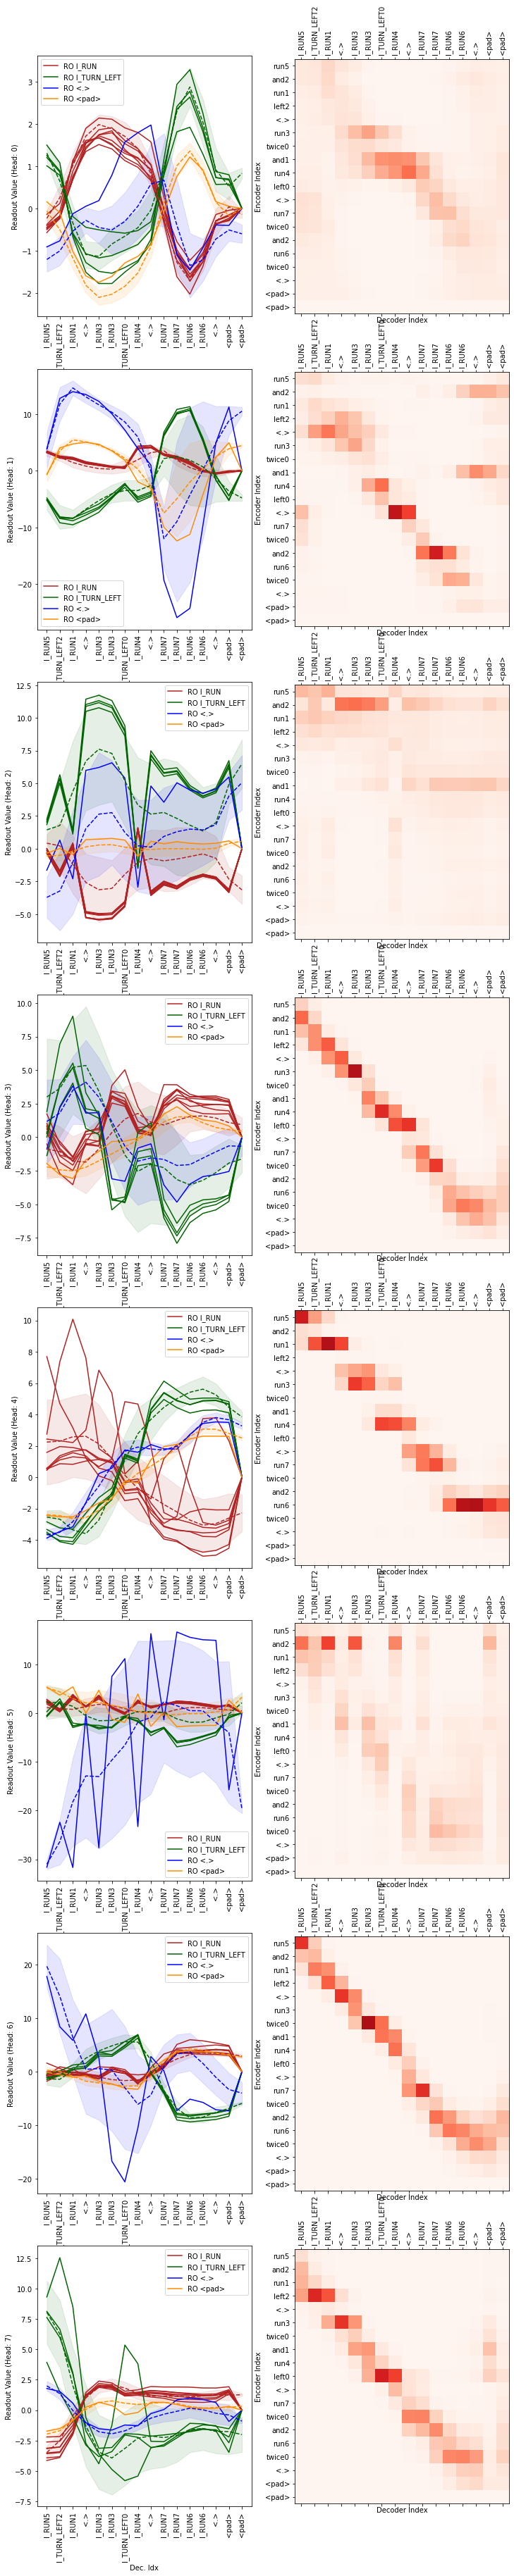

In [29]:
# Plots the logits of a single phrase for each head. Also plots the averages

phrase_idx = 3

ro_masks = np.repeat(masks[:, :, np.newaxis], len(toy_params['out_words']), axis=2)

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

fig, axs = plt.subplots(rnn_specs['attn_heads'], 2, figsize=(12,8*rnn_specs['attn_heads']))
_, _, att_params, _ = final_params

for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):

    ro_contrib_phrase = ro_contrib[head_idx, phrase_idx, :, :len(toy_params['out_words_pp'])]
    
    for idx, key in enumerate(group_idxs.keys()):
        first_key_idx = True
        for key_idx in group_idxs[key]:
            if first_key_idx:
                ro_label = f'RO {key}'
                first_key_idx = False
            else:
                ro_label = None
            ax[0].plot(np.arange(dec_len), ro_contrib_phrase[:, key_idx], color=state_colors[idx], 
                    label=ro_label)
            
    mean_ro_contrib = np.average(ro_contrib[head_idx], axis=0, weights=ro_masks)[:, :len(toy_params['out_words_pp'])]
    std_ro_contrib = analysis.mask_std(ro_contrib[head_idx], axis=0, weights=ro_masks)[:, :len(toy_params['out_words_pp'])]

    for idx, key in enumerate(group_idxs.keys()):
        group_ro_contrib = np.mean(mean_ro_contrib[:, group_idxs[key]], axis=1)
        group_ro_contrib_std = np.mean(std_ro_contrib[:, group_idxs[key]], axis=1)
        ax[0].plot(np.arange(dec_len), group_ro_contrib, color=state_colors[idx], linestyle='dashed')
        ax[0].fill_between(np.arange(dec_len), group_ro_contrib + group_ro_contrib_std, 
                        group_ro_contrib - group_ro_contrib_std, color=state_colors[idx],
                        alpha = 0.1)

    ax[1].matshow(attn_matrix_dir[phrase_idx, :, :, head_idx], cmap=plt.cm.Reds, vmin=0, vmax=1)


    ax[0].legend()
    ax[0].set_ylabel(f'Readout Value (Head: {head_idx})')
    ax[0].set_xlabel('Dec. Idx')

    enc_labels = toy.tensorToPhrase(hs_data['inputs'][phrase_idx], toy_params['in_words'])
    dec_labels = toy.tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['out_words'])    
    ax[0].set_xticks(np.arange(dec_len))
    ax[0].set_xticklabels(dec_labels, rotation=90)

    ax[1].set_ylabel('Encoder Index')
    ax[1].set_xlabel('Decoder Index')

    ax[1].set_xticks([j for j in range(dec_len)])
    ax[1].set_yticks([j for j in range(enc_len)])
    ax[1].set_yticklabels(enc_labels, rotation=0)
    ax[1].set_xticklabels(dec_labels, rotation=90)

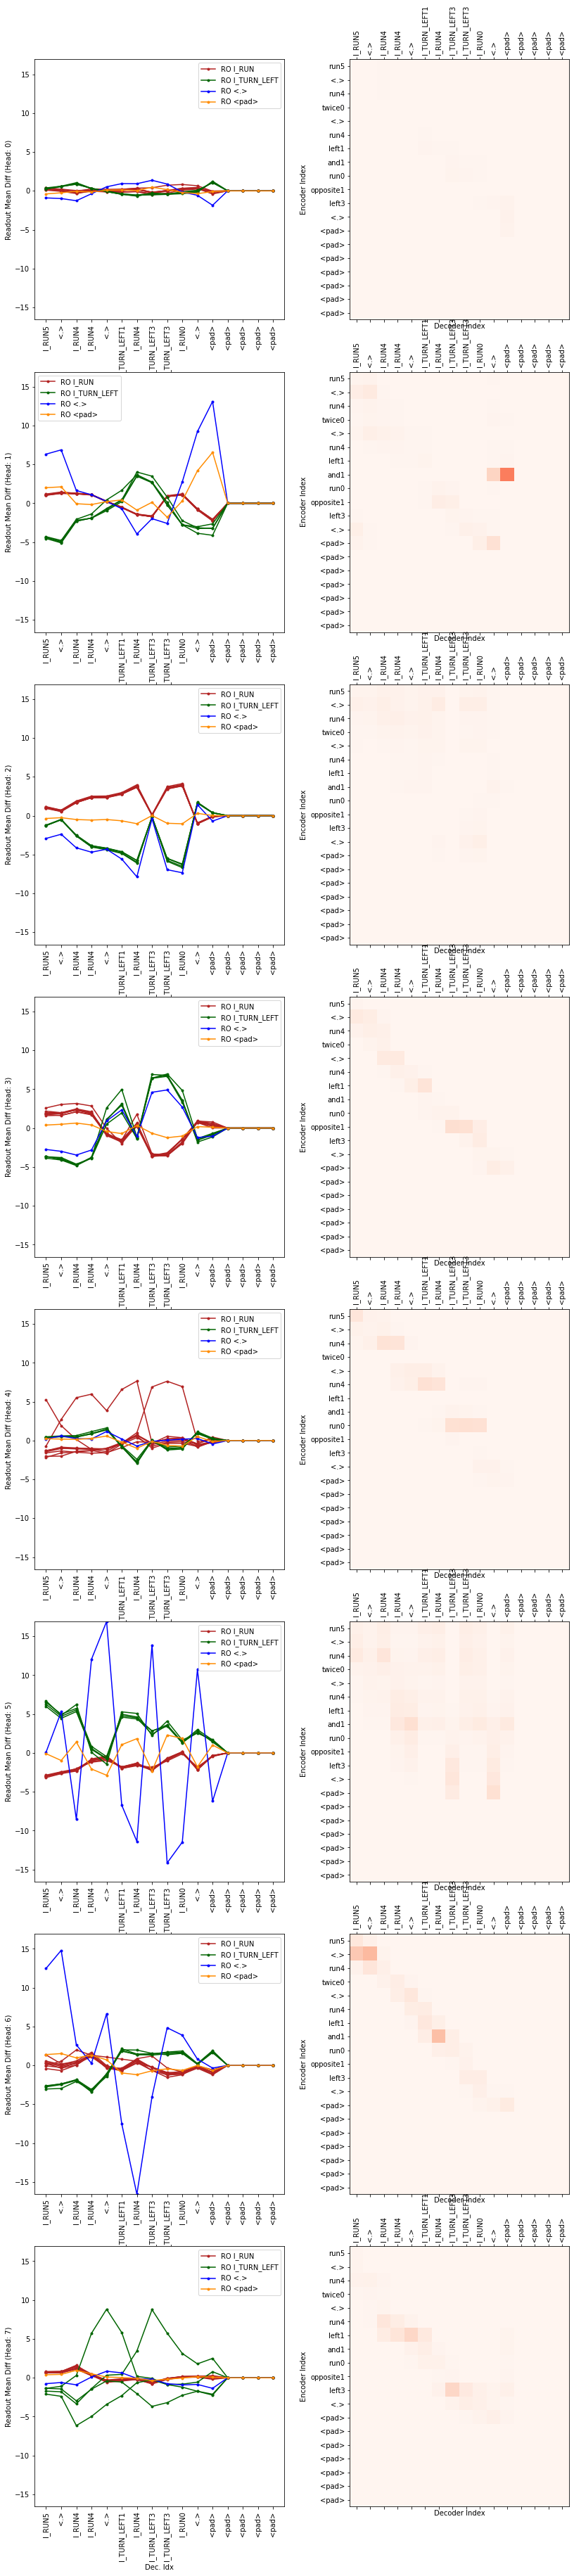

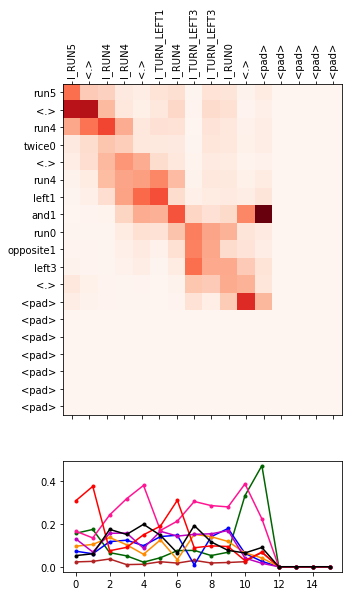

In [40]:
# For each head, uses the absolute difference of a given logit from its mean value
# as a measure of the importance of the head at that time step.

color_maps = (plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples)

phrase_idx = 12

fig, axs = plt.subplots(rnn_specs['attn_heads'], 2, figsize=(14,8*rnn_specs['attn_heads']))
fig2, axs2 = plt.subplots(2, 1, figsize=(5,9), gridspec_kw={'height_ratios': [3, 1]})

out_idx = hs_data['out_index'][phrase_idx]

mean_ro_contrib = np.average(ro_contrib, axis=1, weights=np.repeat(
    ro_masks[np.newaxis, :, :, :], rnn_specs['attn_heads'], axis=0))[:, :, :len(toy_params['out_words_pp'])]

ro_diff = np.zeros(mean_ro_contrib.shape)

for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):

    ro_contrib_phrase = ro_contrib[head_idx, phrase_idx, :, :len(toy_params['out_words_pp'])]

    ro_diff[head_idx] = ro_contrib_phrase - mean_ro_contrib[head_idx]
    # Sets diff to zero beyond pad_idx
    ro_diff[head_idx, out_idx+1:, :] = np.zeros((dec_len - out_idx - 1, len(toy_params['out_words_pp'])))

    for idx, key in enumerate(group_idxs.keys()):
        first_key_idx = True
        for key_idx in group_idxs[key]:
            if first_key_idx:
                ro_label = f'RO {key}'
                first_key_idx = False
            else:
                ro_label = None
            ax[0].plot(np.arange(dec_len), ro_diff[head_idx, :, key_idx], color=state_colors[idx], 
                    label=ro_label, marker='.')

total_max_diff = np.sum(np.max(np.abs(ro_diff), axis=2), axis=0)[:out_idx+1]
head_diff_weights = np.zeros((rnn_specs['attn_heads'], dec_len))
# head_diff_weights[:, :out_idx+1] = softmax(np.max(np.abs(ro_diff), axis=2), axis=0)[:, :out_idx+1]
weighted_attn_matrix = np.zeros((rnn_specs['attn_heads'], enc_len, dec_len))
# weighted_attn_matrix = np.zeros((rnn_specs['attn_heads'], enc_len, dec_len, 4))


for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):
    head_diff_weights[head_idx, :out_idx+1] = np.max(np.abs(ro_diff), axis=2)[head_idx, :out_idx+1]/total_max_diff
    head_attn_matrix = attn_matrix_dir[phrase_idx, :, :, head_idx]
    weighted_attn_matrix[head_idx] = head_attn_matrix * head_diff_weights[head_idx]
    ax[1].matshow(weighted_attn_matrix[head_idx], cmap=plt.cm.Reds, vmin=0, vmax=1)
    # head_attn_matrix = color_maps[head_idx](attn_matrix_dir[phrase_idx, :, :, head_idx]
    # weighted_attn_matrix[head_idx] = np.einsum('ijk,j->ijk', head_attn_matrix, head_diff_weights[head_idx])
    # ax[1].matshow(weighted_attn_matrix[head_idx])


for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):
    ax[0].set_ylim([np.min(ro_diff), np.max(ro_diff)])
    ax[0].legend()
    ax[0].set_ylabel(f'Readout Mean Diff (Head: {head_idx})')
    ax[0].set_xlabel('Dec. Idx')

    enc_labels = toy.tensorToPhrase(hs_data['inputs'][phrase_idx], toy_params['in_words'])
    dec_labels = toy.tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['out_words'])    
    ax[0].set_xticks(np.arange(dec_len))
    ax[0].set_xticklabels(dec_labels, rotation=90)

    ax[1].set_ylabel('Encoder Index')
    ax[1].set_xlabel('Decoder Index')

    ax[1].set_xticks([j for j in range(dec_len)])
    ax[1].set_yticks([j for j in range(enc_len)])
    ax[1].set_yticklabels(enc_labels, rotation=0)
    ax[1].set_xticklabels(dec_labels, rotation=90)

axs2[0].matshow(np.sum(weighted_attn_matrix, axis=0), cmap=plt.cm.Reds)

for head_idx in range(rnn_specs['attn_heads']):
    axs2[1].plot(np.arange(dec_len), head_diff_weights[head_idx], color=state_colors[head_idx], 
                label=f'Head: {head_idx}', marker='.')
    # axs2[1].legend()
    axs2[0].set_xticks([j for j in range(dec_len)])
    axs2[0].set_yticks([j for j in range(enc_len)])
    axs2[0].set_yticklabels(enc_labels, rotation=0)
    axs2[0].set_xticklabels(dec_labels, rotation=90)
    axs2[0].set_anchor('W')
    axs2[1].set_anchor('W')

In [145]:
a = [4, 3, 2, 1]
np.argpartition(a, 2)

array([3, 2, 1, 0])

In [139]:
head_idx = 0
n_rand = 1
head_weights = np.copy(head_diff_weights)
idxs = np.argpartition(head_diff_weights, rnn_specs['attn_heads'] - 1 - n_rand, axis=0)
print(idxs[:n_rand])
print(np.sum(idxs[-n_rand:] == head_idx, axis=0))

[[8 8 8 4 8 8 8 8 8 8 4 8 8 8 9 9]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [167]:
''' 
Again, calculates the relative importance of a head's attention at a given time
step using deviations from the mean as a measure. For heads whose attention
is not deemed important at a given time step, randomizes their attention to 
see how it affects the test accuracy.
'''
# n_rands = [1,]
n_rands = np.arange(0, 10) # Number of heads' attention to randomize
n_phrases = 100
mean_ro_contrib = np.average(ro_contrib, axis=1, weights=np.repeat(
    ro_masks[np.newaxis, :, :, :], rnn_specs['attn_heads'], axis=0))[:, :, :len(toy_params['out_words_pp'])]
mean_accs = np.zeros((len(n_rands)))
perc_head_rand = np.zeros((len(n_rands), rnn_specs['attn_heads']))
for n_rand_idx, n_rand in enumerate(n_rands):
    word_accs = np.zeros((n_phrases))
    head_drops = np.zeros((n_phrases, rnn_specs['attn_heads'], dec_len))

    for phrase_idx in range(n_phrases):

        out_idx = hs_data['out_index'][phrase_idx]
        enc_seq = hs['all'][phrase_idx][:enc_len, :]

        ro_diff = ro_contrib[:, phrase_idx, :, :len(toy_params['out_words_pp'])] - mean_ro_contrib
        ro_diff[:, out_idx+1:, :] = np.zeros((rnn_specs['attn_heads'], dec_len - out_idx - 1, len(toy_params['out_words_pp'])))

        total_max_diff = np.sum(np.max(np.abs(ro_diff), axis=2), axis=0)[:out_idx+1]
        head_diff_weights = np.zeros((rnn_specs['attn_heads'], dec_len))
        head_diff_weights[:, :out_idx+1] = np.max(np.abs(ro_diff), axis=2)[:, :out_idx+1]/total_max_diff
        weighted_attn_matrix = np.zeros((rnn_specs['attn_heads'], enc_len, dec_len))
        rand_idxs = np.argpartition(head_diff_weights, n_rand, axis=0) # Least important head
        # rand_idxs = np.argpartition(head_diff_weights, rnn_specs['attn_heads'] - 1 - n_rand, axis=0) # Most important head

        phrase_logits = np.zeros(hs_data['labels'][phrase_idx].shape)

        for head_idx in range(rnn_specs['attn_heads']):

            _, _, v_mat = att_params[0][head_idx]
            co_mat = att_params[1][head_idx*rnn_specs['v_size']:(head_idx+1)*rnn_specs['v_size'], :]

            # Determines which decoder idxs should be randomized for this head
            rand_mask = np.sum(rand_idxs[:n_rand] == head_idx, axis=0) # Creates a mask to randomize
            # rand_mask = np.sum(rand_idxs[n_rand:] == head_idx, axis=0) # Creates a mask to randomize (most important head)
            head_drops[phrase_idx, head_idx, :out_idx+1] = rand_mask[:out_idx+1]
            
            # Uniform random aligns
            rand_aligns = np.zeros((enc_len, dec_len))
            rand_aligns[:in_idx+1, :out_idx+1] = np.random.uniform(-5, 5, size=(in_idx+1, out_idx+1))
            rand_attn_matrix = softmax(rand_aligns, axis=0)

            # print(f'Head: {head_idx}:', rand_mask)

            masked_attn_matrix = (attn_matrix_dir[phrase_idx, :, :, head_idx] * (1 - rand_mask) 
                                + rand_attn_matrix * rand_mask)

            # print((masked_attn_matrix == attn_matrix_dir[phrase_idx, :, :, head_idx]).all())

            rand_context = np.matmul(np.transpose(masked_attn_matrix), np.matmul(enc_seq, v_mat))
            rand_logits = ro_apply(np.matmul(rand_context, co_mat))
            phrase_logits += rand_logits

        labels = np.argmax(hs_data['labels'][phrase_idx], axis=1)
        predictions = np.argmax(phrase_logits, axis=1) 

        word_accs[phrase_idx] = np.average(labels==predictions, weights=masks[phrase_idx])
    perc_head_rand[n_rand_idx] = [np.average(head_drops[:, head_idx, :], weights=masks[:n_phrases]) for head_idx in range(rnn_specs['attn_heads'])]
    mean_accs[n_rand_idx] = np.mean(word_accs)
    print('Head Drops:', perc_head_rand[n_rand_idx])
    print('Word Accuracy:', mean_accs[n_rand_idx])

Head Drops: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Word Accuracy: 0.9941538461538463
Head Drops: [0.00785546 0.         0.01413983 0.45404556 0.25373134 0.
 0.00864101 0.07619796 0.06598586 0.10290652 0.         0.
 0.         0.         0.01649647 0.        ]
Word Accuracy: 0.9919010989010989
Head Drops: [0.03613511 0.         0.02592302 0.66142969 0.62450903 0.
 0.01413983 0.16025137 0.17989002 0.24744698 0.         0.
 0.00157109 0.         0.0479183  0.00078555]
Word Accuracy: 0.9920586080586081
Head Drops: [9.42655145e-02 0.00000000e+00 3.92772977e-02 8.03613511e-01
 8.29536528e-01 0.00000000e+00 2.12097408e-02 2.56087981e-01
 3.69992145e-01 4.94108405e-01 0.00000000e+00 7.85545954e-04
 1.57109191e-03 0.00000000e+00 8.40534171e-02 5.49882168e-03]
Word Accuracy: 0.9853643023643025
Head Drops: [0.19245876 0.         0.06127258 0.91516104 0.94658288 0.
 0.03063629 0.36842105 0.5930872  0.73369992 0.         0.00157109
 0.00785546 0.         0.13275727 0.01649647]
Word Accu

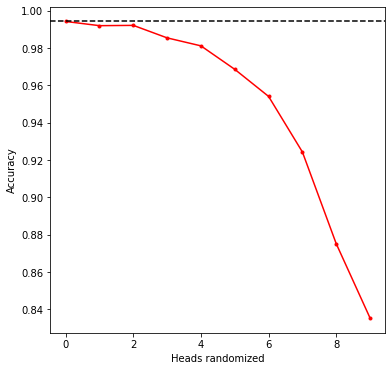

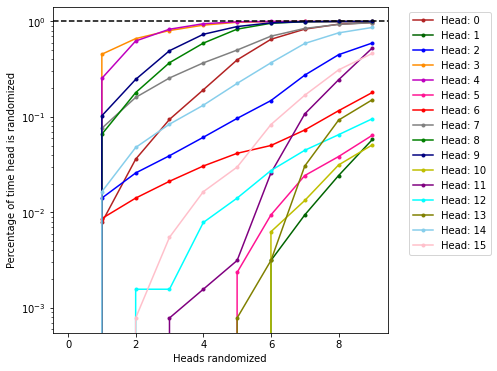

In [168]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
fig2, ax2 = plt.subplots(1, 1, figsize=(6,6))

ax1.plot(n_rands, mean_accs, color='r', marker='.')
ax1.axhline(np.max(mean_accs), color='k', linestyle='dashed')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Heads randomized')

for head_idx in range(rnn_specs['attn_heads']):
    ax2.semilogy(n_rands, perc_head_rand[:, head_idx], color=state_colors[head_idx], 
             label=f'Head: {head_idx}', marker='.')

ax2.set_ylabel('Percentage of time head is randomized')
ax2.set_xlabel('Heads randomized')
ax2.axhline(1.0, color='k', linestyle='dashed')
# ax2.set_ylim([1e-4, 1.1])
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

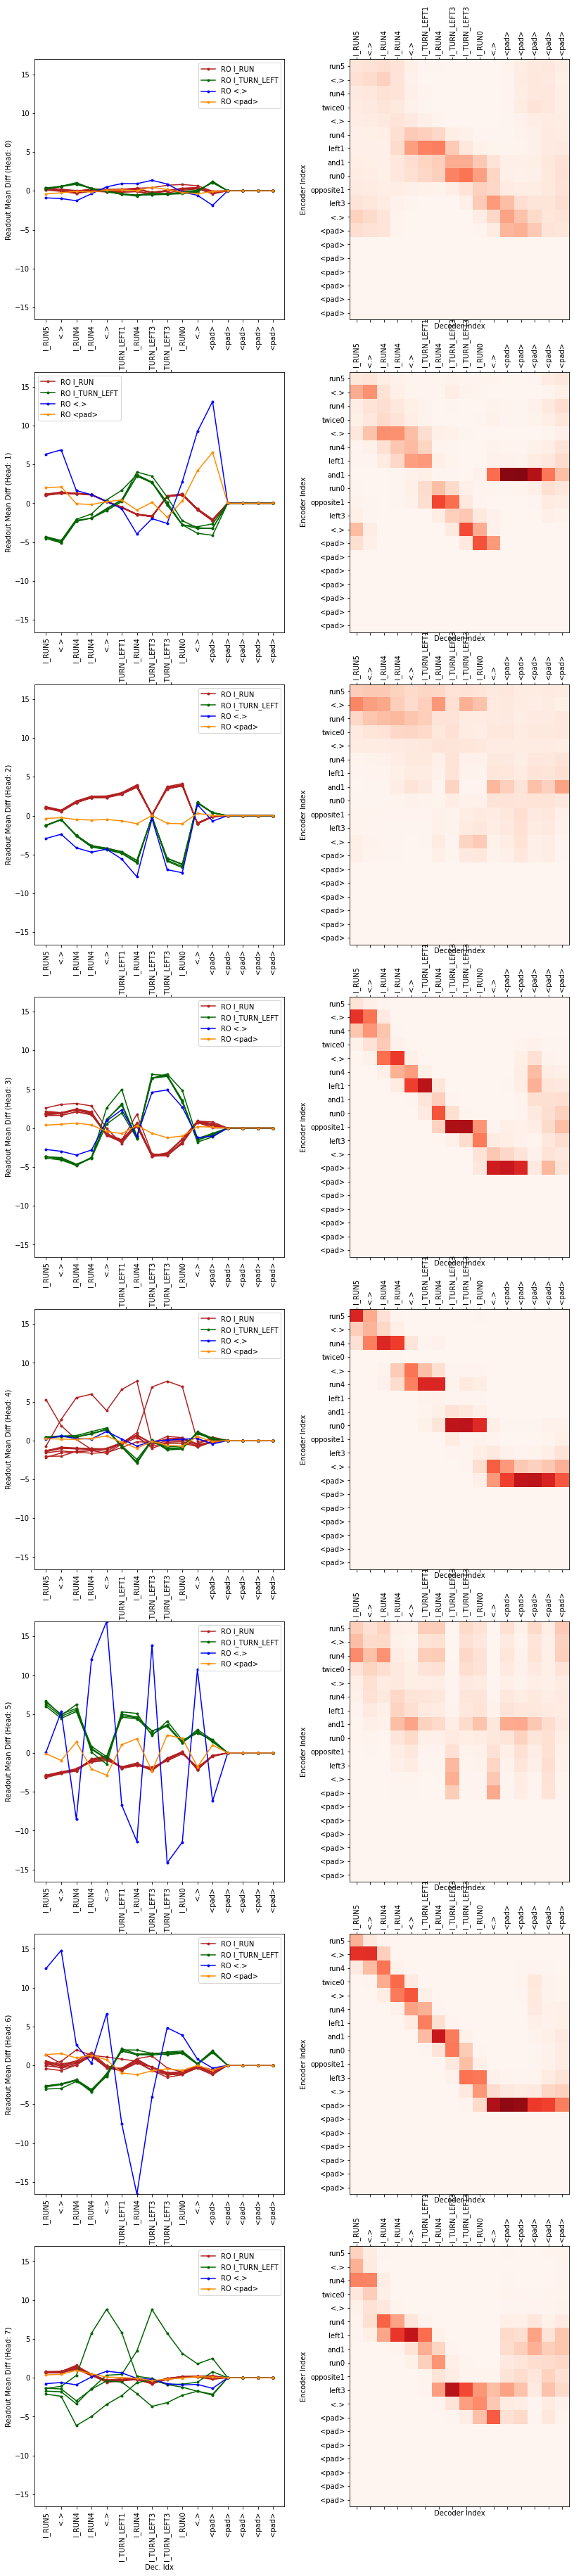

In [52]:
'''
For each head, randomizes (in various ways) the attention matrix to see
how the logit values change. Then, for a given phrase, 
plots the deviation from the (actual)
mean logit values (and the randomized attention matrix)
This tests the robustness of the average attention
of various heads to changing attention. 

For each head, uses the absolute difference of a given logit from its mean value
as a measure of the importance of the head at that time step.
'''
phrase_idx = 12

fig, axs = plt.subplots(rnn_specs['attn_heads'], 2, figsize=(14,8*rnn_specs['attn_heads']))

in_idx = hs_data['in_index'][phrase_idx]
out_idx = hs_data['out_index'][phrase_idx]
_, _, att_params, _ = final_params

mean_ro_contrib = np.average(ro_contrib, axis=1, weights=np.repeat(
    ro_masks[np.newaxis, :, :, :], rnn_specs['attn_heads'], axis=0))[:, :, :len(toy_params['out_words_pp'])]
ro_diff = np.zeros(mean_ro_contrib.shape)
enc_seq = hs['all'][phrase_idx][:enc_len, :]

idxs = np.argpartition(head_diff_weights, n_rand, axis=0)

for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):

    _, _, v_mat = att_params[0][head_idx]
    co_mat = att_params[1][head_idx*rnn_specs['v_size']:(head_idx+1)*rnn_specs['v_size'], :]

    rand_attn_matrix = attn_matrix_dir[phrase_idx, :, :, head_idx]

    # # Uniform random aligns
    # rand_aligns = np.zeros((enc_len, dec_len))
    # rand_aligns[:in_idx+1, :out_idx+1] = np.random.uniform(-5, 5, size=(in_idx+1, out_idx+1))
    # rand_attn_matrix = softmax(rand_aligns, axis=0)

    rand_context = np.matmul(np.transpose(rand_attn_matrix), np.matmul(enc_seq, v_mat))
    rand_logits = ro_apply(np.matmul(rand_context, co_mat))[:, :len(toy_params['out_words_pp'])]

    ro_diff[head_idx] = rand_logits - mean_ro_contrib[head_idx]
    # Sets diff to zero beyond pad_idx
    ro_diff[head_idx, out_idx+1:, :] = np.zeros((dec_len - out_idx - 1, len(toy_params['out_words_pp'])))

    for idx, key in enumerate(group_idxs.keys()):
        first_key_idx = True
        for key_idx in group_idxs[key]:
            if first_key_idx:
                ro_label = f'RO {key}'
                first_key_idx = False
            else:
                ro_label = None
            ax[0].plot(np.arange(dec_len), ro_diff[head_idx, :, key_idx], color=state_colors[idx], 
                    label=ro_label, marker='.')

    ax[1].matshow(rand_attn_matrix, cmap=plt.cm.Reds, vmin=0, vmax=1)

for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):
    ax[0].set_ylim([np.min(ro_diff), np.max(ro_diff)])
    ax[0].legend()
    ax[0].set_ylabel(f'Readout Mean Diff (Head: {head_idx})')
    ax[0].set_xlabel('Dec. Idx')

    enc_labels = toy.tensorToPhrase(hs_data['inputs'][phrase_idx], toy_params['in_words'])
    dec_labels = toy.tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['out_words'])    
    ax[0].set_xticks(np.arange(dec_len))
    ax[0].set_xticklabels(dec_labels, rotation=90)

    ax[1].set_ylabel('Encoder Index')
    ax[1].set_xlabel('Decoder Index')

    ax[1].set_xticks([j for j in range(dec_len)])
    ax[1].set_yticks([j for j in range(enc_len)])
    ax[1].set_yticklabels(enc_labels, rotation=0)
    ax[1].set_xticklabels(dec_labels, rotation=90)

Head: 0, Max dot: 33.62861633300781, Min dot: -37.548095703125
Head: 1, Max dot: 9.447281837463379, Min dot: -6.462809085845947
Head: 2, Max dot: 23.375600814819336, Min dot: -30.980955123901367
Head: 3, Max dot: 20.933351516723633, Min dot: -21.134292602539062


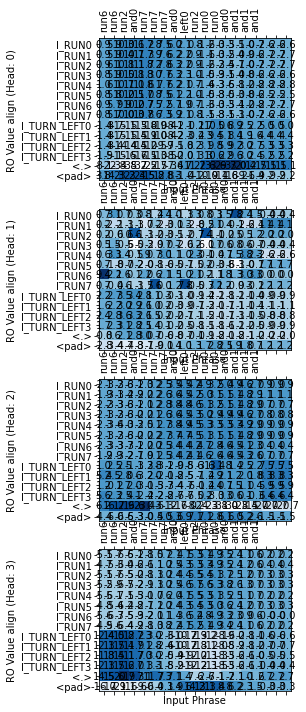

In [46]:
# For a given phrase, sees how much the encoder hidden states (times value 
# matrix and context out matrix) overlaps with the readouts for each head

phrase_idx = 3

fig, axs = plt.subplots(rnn_specs['attn_heads'], 1, figsize=(12,3*rnn_specs['attn_heads']))

for head_idx, ax in zip(range(rnn_specs['attn_heads']), axs):

    readout_dots = np.zeros((enc_len, len(toy_params['out_words_pp'])))

    # Projections for various types of learnable attention
    _, _, att_params, _ = final_params
    _, _, v_mat = att_params[0][head_idx]
    co_mat = att_params[1][head_idx*rnn_specs['v_size']:(head_idx+1)*rnn_specs['v_size'], :]
    value_proj = np.matmul(v_mat, co_mat) # Both values and context_out projection for given head

    enc_phrase_proj = np.matmul(hs['all'][phrase_idx][:enc_len], value_proj)
    readout_dots = np.matmul(enc_phrase_proj, readout.T)
    
    print(f'Head: {head_idx}, Max dot: {np.max(readout_dots)}, Min dot: {np.min(readout_dots)}')

    ax.matshow(readout_dots.T, cmap=plt.cm.Blues)

    for i in range(readout_dots.shape[1]):
        for j in range(readout_dots.shape[0]):
            c = readout_dots[j,i]
            ax.text(j, i, str(round(c, 1)), va='center', ha='center')

    ax.set_xticks(np.arange(enc_len))
    x_labels = toy.tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['in_words'])
    ax.set_xticklabels(x_labels, rotation=90)
    ax.set_yticks([i for i in range(len(toy_params['out_words_pp']))])
    ax.set_yticklabels(toy_params['out_words_pp'], rotation=0)
    ax.set_ylabel(f'RO Value align (Head: {head_idx})')
    ax.set_xlabel('Input Phrase')

Text(0.5, 0, 'Dec. Idx')

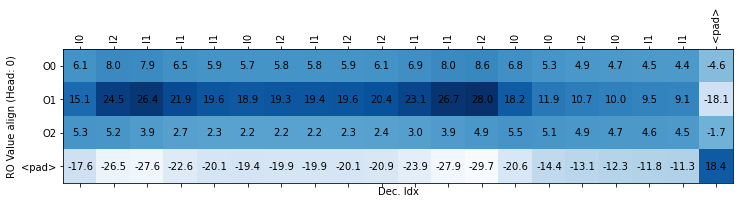

In [112]:
head0_aligns = np.matmul(attn_matrix.T, readout_dots)

fig, ax = plt.subplots(1, 1, figsize=(12,3))

ax.matshow(head0_aligns.T, cmap=plt.cm.Blues)

for i in range(head0_aligns.shape[1]):
    for j in range(head0_aligns.shape[0]):
        c = head0_aligns[j,i]
        ax.text(j, i, str(round(c, 1)), va='center', ha='center')

ax.set_xticks(np.arange(enc_len))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_yticks([i for i in range(len(toy_params['out_words_pp']))])
ax.set_yticklabels(toy_params['out_words_pp'], rotation=0)
ax.set_ylabel(f'RO Value align (Head: {head_idx})')
ax.set_xlabel('Dec. Idx')

In [68]:
np.argmax(ro_contrib[1, phrase_idx, :, :], axis=1)

array([2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2])

In [69]:
attn_matrix_dir.shape

(1000, 20, 20, 2)

In [79]:
attn_matrix_dir[phrase_idx, 4, :, 1]

DeviceArray([1.2893388e-05, 5.8111851e-04, 1.9783914e-02, 2.5495884e-01,
             5.6739813e-01, 2.5534445e-01, 2.3348134e-02, 8.1026671e-04,
             6.6261423e-06, 1.6502920e-08, 9.0018853e-11, 2.0155897e-13,
             9.5294129e-16, 2.7186629e-17, 1.2866141e-18, 1.4404192e-17,
             9.6278032e-16, 5.4701404e-13, 7.6153139e-10, 1.5748437e-06],            dtype=float32)

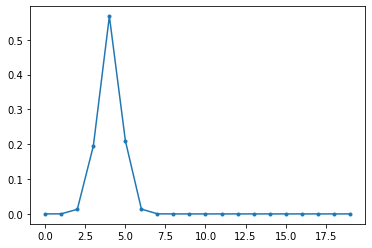

In [96]:
plt.plot(attn_matrix_dir[phrase_idx, :, 4, head_idx], marker='.')

In [101]:
head_idx = 1

_, _, att_params, _ = final_params
_, _, v_mat = att_params[0][head_idx]
co_mat = att_params[1][head_idx*rnn_specs['v_size']:(head_idx+1)*rnn_specs['v_size'], :]
value_proj = np.matmul(v_mat, co_mat)

context_vec_head = np.matmul(attn_matrix_dir[phrase_idx, :, 4, head_idx], np.matmul(hs['all'][phrase_idx][:enc_len], value_proj))

print(np.matmul(readout, context_vec_head))

diagonal_attend = np.zeros((20,))
diagonal_attend[4] = 0.5
diagonal_attend[5] = 0.2
diagonal_attend[3] = 0.2

context_vec_head = np.matmul(diagonal_attend, np.matmul(hs['all'][phrase_idx][:enc_len], value_proj))

print(np.matmul(readout, context_vec_head))

[-0.34901032  0.4840386   2.371009   -3.7250068 ]
[-0.34520235  0.2440022   2.32276717 -3.31238105]


### Ensemble Plotting

#### eSCAN

In [ ]:
# Loads many networks and computes accuracy and average hs dots
arch_type = 'AO'

if arch_type == 'AO':
  trial_idxs = [1, 8, 9, 10, 11, 12, 25, 27, 29,]
  base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_andlefttwicescan_nolefttwice_5datasets_l2is1e-4.pickle'
elif arch_type == 'AED':
  trial_idxs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
  base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aed_andlefttwicescan_nolefttwice_5datasets_l2is1e-4.pickle'

dot_idx = base_path.index('.')
data_type = 'scan'
n_trials = 1000

# trial_idxs = [10,]
# trial_idxs = [17, 18, 20]

trial_temp_var_ratios = np.zeros((len(trial_idxs)))

dot_keys = ['temp_temp', 'temp_inp', 'temp_del', 'inp_temp', 'inp_inp', 'inp_del', 'del_temp', 'del_inp', 'del_del']
trial_dot_ratios = np.zeros((len(trial_idxs), len(dot_keys)))

b_off = 2
f_off = 4

trial_enc_word_dots = np.zeros((len(trial_idxs), len(toy_params['in_words_pp']), b_off+f_off+1))
trial_enc_word_angles = np.zeros((len(trial_idxs), len(toy_params['in_words_pp']), b_off+f_off+1))

for trial_idx in range(len(trial_idxs)):

  new_path = base_path[:dot_idx] + '_' + str(trial_idxs[trial_idx]) + base_path[dot_idx:]
  with open(new_path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

  rnn_params, rnn_params_dec, readout_params = params_loaded
  final_params = params_loaded
  train_params, toy_params, rnn_specs = train_build.default_params(train_params, toy_params, rnn_specs)

  if trial_idx == 0: # Only generates new data on first run
    scan_data, _ = scan.generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=n_trials)
    hs_data =  {
      'inputs': scan_data['inputs'],
      'labels': scan_data['labels'],
      'in_index': scan_data['in_index'],
      'out_index': scan_data['out_index'],
    }

    enc_len = hs_data['inputs'][0].shape[0]
    dec_len = hs_data['labels'][0].shape[0]
    trial_dot_vals = np.zeros((len(trial_idxs), dec_len, enc_len))

  # Builds new apply and accuracy function
  _, apply_fun, _, _, accuracy_fun = train_build.build_rnn(rnn_specs)
  phrase_acc, word_acc = accuracy_fun(final_params, hs_data)
  print(f'Trial: {trial_idxs[trial_idx]},  Test Acc:', np.mean(phrase_acc), ', Word Acc:', np.mean(word_acc))

  # Gets raw hidden states
  cell, _ = analysis.build_cell(rnn_specs)
  cell_dec, readout_apply = analysis.build_cell(rnn_specs)
  cells = cell, cell_dec
  hs = {}
  raw_logits, hs['all'] = analysis.rnn_states(cells, readout_apply, hs_data, final_params, rnn_specs, return_hidden=True)

  #### Finds decoder input values ####
  hs_data['dec_inputs'] = np.zeros((n_trials, dec_len), dtype=np.int32)
  for logits, idx in zip(raw_logits, range(n_trials)):
    rolled_logits = np.roll(np.argmax(logits, axis=1), shift=1)
    rolled_logits[0] = len(toy_params['out_words_pp']) # Assigns <BoS> to first unused index
    hs_data['dec_inputs'][idx] = rolled_logits

  avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

  for seq_idx in range(dec_len):
    raw_dots = np.dot(avg_hs[:enc_len], avg_hs[enc_len+seq_idx])
    trial_dot_vals[trial_idx, seq_idx, :] = raw_dots

  # Finds variance reduction
  word_var_enc, word_var_enc_nt, word_var_dec, word_var_dec_nt = analysis.var_before_after_temp(hs, hs_data, toy_params)

  trial_temp_var_ratios[trial_idx] = np.mean(word_var_enc_nt/word_var_enc)

  # Finds dot decomposition
  dot_keys = ['temp_temp', 'temp_inp', 'temp_del', 'inp_temp', 'inp_inp', 'inp_del', 'del_temp', 'del_inp', 'del_del']

  align_values = analysis.find_align_breakdown(hs, hs_data, toy_params, rnn_specs)
  dot_ratio_vals = analysis.calculate_dot_ratios(align_values, 5, hs_data)

  # Averages for each key
  for dot_key, idx in zip(dot_keys, range(len(dot_keys))):
    trial_dot_ratios[trial_idx, idx] = np.mean(dot_ratio_vals[idx])

  # Encoder word and decoder time calculation
  enc_word_dots, enc_word_angles = enc_word_dec_temp(hs, hs_data, toy_params, b_off=b_off, f_off=f_off)

  trial_enc_word_dots[trial_idx] = enc_word_dots
  trial_enc_word_angles[trial_idx] = enc_word_angles

SCAN data generated in: 0.05 sec.
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Decoder sequence size: (1000, 15, 100)
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Trial: 1,  Test Acc: 0.90900004 , Word Acc: 0.98006666
Using GRU cell
Using GRU cell
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: standard
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Decoder sequence size: (1000, 15, 100)
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Decoder sequence size: (1000, 15, 100)
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Trial: 8,  Test Acc: 0.883 , Word Acc: 0.9752
Using GRU cell
Using GRU cell
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: standard
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Decoder sequence size: (1000, 15, 100)
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Decoder sequence size: (1000, 15, 100)
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Trial: 9,  Test Acc: 0.879000

/content/drive/My Drive/ml_research/fixedpoints_nlp/seq2seq_files/analysis.py:320: RuntimeWarning: invalid value encountered in true_divide
  avg_offset = displacements/length_count


Average offset [0.338      0.309      1.002      1.142      0.987      1.16
 1.372      1.641      1.962      2.         2.077      2.30192503
 2.60935525 2.97238372 3.06111111 2.9941691  3.00793651        nan]


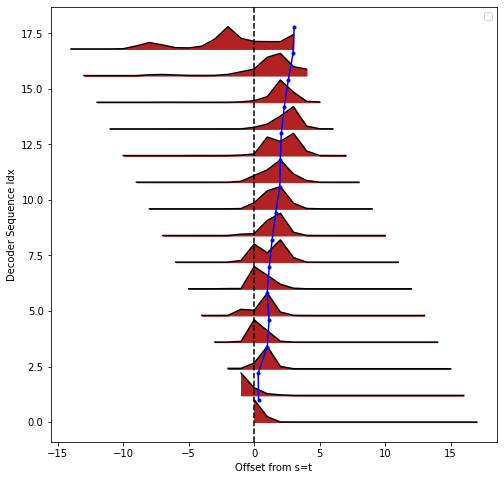

In [ ]:
avg_dot_vals = np.mean(trial_dot_vals, axis=0)
end_pad = 0
avg_softmax_vals = np.zeros((dec_len, enc_len - end_pad))
for seq_idx in range(dec_len):
  if end_pad > 0:
    avg_softmax = softmax(avg_dot_vals[seq_idx,:-end_pad])
  else:
    avg_softmax = softmax(avg_dot_vals[seq_idx,:])
  # Normalizes dot product between 0 and 1
  avg_softmax_vals[seq_idx, :] = (avg_softmax - np.min(avg_softmax))/(np.max(avg_softmax)-np.min(avg_softmax))
  # avg_softmax_vals[seq_idx, :] = avg_softmax

avg_offset = analysis.find_scan_offset(hs_data, toy_params)
print('Average offset', avg_offset)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Generate line plots
y_spacing = 1.2

lines = []
for seq_idx in range(dec_len):
  # Same for linewidth (thicker strokes on bottom)
  lw = 1.5 - seq_idx / 100.0
  # line, = ax1.plot([i-seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='k', lw=lw)
  # ax1.fill_between([i-seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx, y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='grey')
  line, = ax1.plot([i - seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='k', lw=lw)
  ax1.fill_between([i - seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx, y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='firebrick')

  lines.append(line)

# ax1.plot(avg_offset[:dec_len], [y_spacing*seq_idx+1 for seq_idx in range(dec_len)], color='b', marker='.')
ax1.plot([avg_offset[i] for i in range(avg_offset[:dec_len].shape[0])], [y_spacing*seq_idx+1 for seq_idx in range(dec_len)], color='b', marker='.')

ax1.axvline(0.0, color='k', linestyle='dashed')
ax1.set_ylabel('Decoder Sequence Idx')
ax1.set_xlabel('Offset from s=t')
ax1.legend()
# ax1.set_xlim([-8, 8])

In [ ]:
# Saves the data
if arch_type == 'AO':
  path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_andlefttwicescan_nolefttwice_5datasets_l2is1e-4_average_dots.pickle'
elif arch_type == 'AED':
  path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aed_andlefttwicescan_nolefttwice_5datasets_l2is1e-4_average_dots.pickle'

escan_data = {}
escan_data['trial_temporal_dots'] = trial_dot_vals
escan_data['avg_offset'] = avg_offset
escan_data['enc_len'] = enc_len
escan_data['dec_len'] = dec_len
escan_data['dot_keys'] = dot_keys
escan_data['trial_dot_ratios'] = trial_dot_ratios
escan_data['trial_temp_var_ratios'] = trial_temp_var_ratios
escan_data['trial_enc_word_dots'] = trial_enc_word_dots
escan_data['trial_enc_word_angles'] = trial_enc_word_angles

with open(path, 'wb') as save_file:
  pickle.dump(escan_data, save_file, protocol=pickle.HIGHEST_PROTOCOL)

/content/drive/My Drive/ml_research/fixedpoints_nlp/seq2seq_files/analysis.py:319: RuntimeWarning: invalid value encountered in true_divide
  avg_offset = displacements/length_count


(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
Average offset [0.324      0.324      1.028      1.137      0.997      1.174
 1.373      1.653      1.97       2.022      2.059      2.26390293
 2.59273671 2.98535871 3.05860806 3.00566572 3.016      4.
        nan]


Text(0.5, 0, 'Sequence Index')

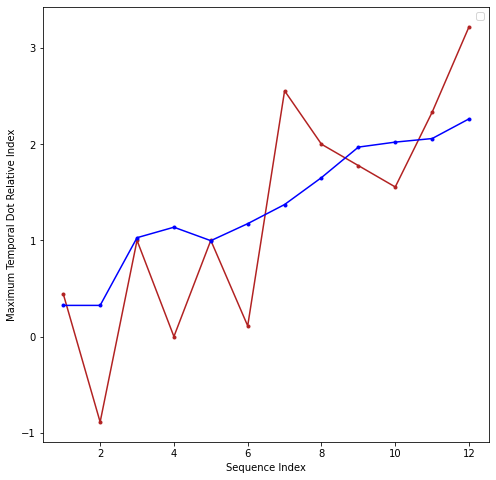

In [ ]:
end_pad = 1
rel_argmax_locs = np.zeros((len(trial_idxs), dec_len))
for trial_idx in range(len(trial_idxs)):
  argmax_vals = np.argmax(trial_dot_vals[trial_idx, :, :-end_pad], axis=1)
  print(argmax_vals.shape)
  rel_argmax_locs[trial_idx] = np.array([argmax_vals[i]-i for i in range(argmax_vals.shape[0])])

avg_offset = analysis.find_scan_offset(hs_data, toy_params)
print('Average offset', avg_offset)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# for trial_idx in range(len(trial_idxs)):
#   ax1.plot([i+1 for i in range(dec_len)], rel_argmax_locs[trial_idx], marker='.', alpha=1.0, label=trial_idxs[trial_idx])
# ax1.plot([i+1 for i in range(dec_len)], rel_argmax_locs[trial_idxs.index(0)], color='green', marker='.')

plot_until = 12
ax1.plot([i+1 for i in range(plot_until)], np.mean(rel_argmax_locs, axis=0)[:plot_until], color='firebrick', marker='.')
ax1.plot([i+1 for i in range(plot_until)], avg_offset[:plot_until], color='b', marker='.')

ax1.legend()
ax1.set_ylabel('Maximum Temporal Dot Relative Index')
ax1.set_xlabel('Sequence Index')

/content/drive/My Drive/ml_research/fixedpoints_nlp/seq2seq_files/analysis.py:319: RuntimeWarning: invalid value encountered in true_divide
  avg_offset = displacements/length_count


Average offset [0.324      0.291      1.013      1.167      0.99       1.156
 1.386      1.676      1.979      2.013      2.079      2.26915323
 2.60424469 2.97740113 3.06140351 2.98626374 3.                nan]


Text(0.5, 0, 'Sequence Index')

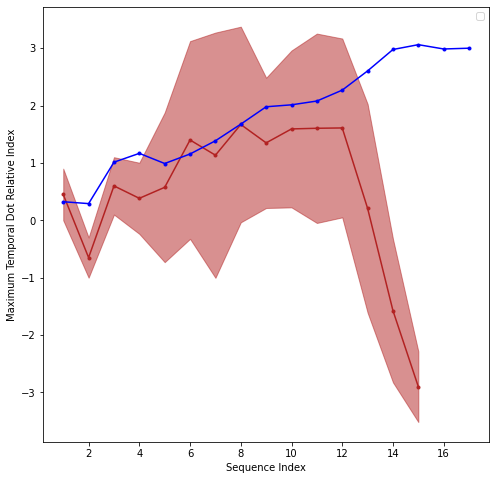

In [ ]:
thresh = 0.8 # Value argmax values neeed to exceed
end_pad = 1

trial_means = np.zeros((len(trial_idxs), dec_len))
trial_stds = np.zeros((len(trial_idxs), dec_len))

for trial_idx in range(len(trial_idxs)):
  softmax_trial = softmax(trial_dot_vals[trial_idx, :, :], axis=1) # (dec_len, enc_len)
  for dec_idx in range(dec_len):
    sorted_idxs = np.argsort(softmax_trial[dec_idx])
    sum = 0
    idxs = []
    while sum < thresh:
      sum += softmax_trial[dec_idx, sorted_idxs[-1]]
      idxs.append(sorted_idxs[-1])
      sorted_idxs = sorted_idxs[:-1]    
    trial_means[trial_idx, dec_idx] = np.mean(idxs)
    trial_stds[trial_idx, dec_idx] = np.std(idxs)

avg_offset = analysis.find_scan_offset(hs_data, toy_params)
print('Average offset', avg_offset)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

argmax_locs = np.argmax(avg_softmax_vals, axis=1)
argmax_locs -= np.arange(argmax_locs.shape[0])

means_offset = np.mean(trial_means, axis=0)-np.arange(dec_len)

ax1.plot([i+1 for i in range(dec_len)], means_offset, color='firebrick', marker='.')
ax1.fill_between([i+1 for i in range(dec_len)], means_offset - np.mean(trial_stds, axis=0), means_offset + np.mean(trial_stds, axis=0),
                 color='firebrick', alpha=0.5)
ax1.plot([i+1 for i in range(enc_len-1)], avg_offset[:-1], color='b', marker='.')

ax1.legend()
ax1.set_ylabel('Maximum Temporal Dot Relative Index')
ax1.set_xlabel('Sequence Index')

Sythentic data generated in: 0.11 sec.
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20.0
Zero context True
Test Acc: 1.0 , Word Acc: 1.0
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: standard
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20.0
Zero context True
Sythentic data generated in: 0.11 sec.
Test Acc: 1.0 , Word Acc: 1.0
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: False
Sythentic data generated in: 0.15 sec.
Zero context False
Test Acc: 1.0 , Word Acc: 1.0


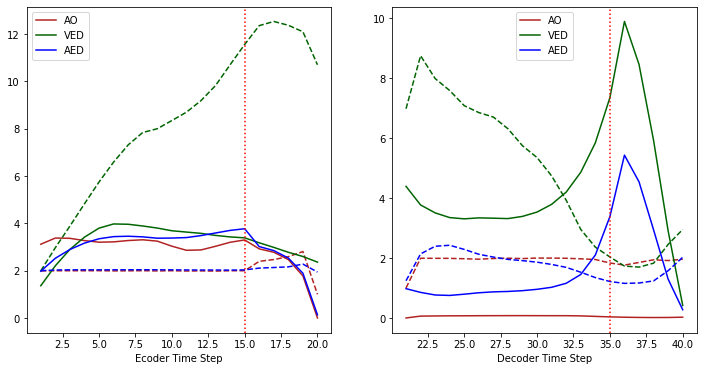

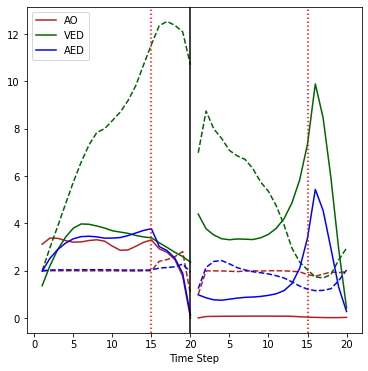

In [ ]:
# Plots variances for several architectures

ved_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ved_toy_3words_15to20_l2is1e-4_7.pickle'
ao_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_toy_3words_15to20_l2is1e-3_2.pickle'
aed_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aed_toy_3words_15to20_l2is1e-3_3.pickle'
paths = [ao_path, ved_path, aed_path]
data_type = 'toy'
n_trials = 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig, ax3 = plt.subplots(1, 1, figsize=(6,6))


for trial_idx in range(len(paths)):
  with open(paths[trial_idx], 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

  rnn_params, rnn_params_dec, readout_params = params_loaded
  final_params = params_loaded
  train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

  
  hs_data = generate_data(n_trials, toy_params, rnn_specs)

  enc_len = hs_data['inputs'][0].shape[0]
  dec_len = hs_data['labels'][0].shape[0]
  min_len = np.min([enc_len, dec_len])

  if trial_idx == 0: # Only generates new data on first run
    time_var = np.zeros((len(paths), enc_len+dec_len))
    time_pr = np.zeros((len(paths), enc_len+dec_len))

  # Builds new apply and accuracy function
  _, apply_fun, _, _, accuracy_fun = build_rnn(rnn_specs)

  phrase_acc, word_acc = accuracy_fun(final_params, hs_data)
  print(f'Test Acc:', np.mean(phrase_acc), ', Word Acc:', np.mean(word_acc))

  # Gets raw hidden states
  hs['all'] = rnn_states(hs_data, final_params, rnn_specs)

  hs_time_word_enc, hs_time_word_dec = sort_hs_by_time_and_word(hs, hs_data, toy_params)

  for time_idx in range(hs['all'][0].shape[0]):
    time_hs = []
    if time_idx < enc_len: # Encoder
      for word_list in hs_time_word_enc[time_idx]:
        time_hs.extend(word_list)
    else: # Decoder
      for word_list in hs_time_word_dec[time_idx-enc_len]:
        time_hs.extend(word_list)
      
    time_hs = np.array(time_hs)
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    _ = pca_time.fit_transform(time_hs)
    time_var[trial_idx, time_idx] = np.sum(pca_time.explained_variance_)
    time_pr[trial_idx, time_idx] = participation_ratio_vector(pca_time.explained_variance_)

trial_labels = ['AO', 'VED', 'AED']
for trial_idx in range(len(paths)):
  enc_times = [i+1 for i in range(enc_len)]
  dec_times = [i+1+enc_len for i in range(dec_len)]
  ax1.plot(enc_times, time_var[trial_idx, :enc_len], color=state_colors[trial_idx], label=trial_labels[trial_idx])
  ax1.plot(enc_times, time_pr[trial_idx, :enc_len], color=state_colors[trial_idx], linestyle='dashed')
  ax2.plot(dec_times, time_var[trial_idx, enc_len:], color=state_colors[trial_idx], label=trial_labels[trial_idx])
  ax2.plot(dec_times, time_pr[trial_idx, enc_len:], color=state_colors[trial_idx], linestyle='dashed')
  ax3.plot(enc_times, time_var[trial_idx, :enc_len], color=state_colors[trial_idx], label=trial_labels[trial_idx])
  ax3.plot(enc_times, time_pr[trial_idx, :enc_len], color=state_colors[trial_idx], linestyle='dashed')
  ax3.plot(dec_times, time_var[trial_idx, enc_len:], color=state_colors[trial_idx])
  ax3.plot(dec_times, time_pr[trial_idx, enc_len:], color=state_colors[trial_idx], linestyle='dashed')

ax1.axvline(15, color='r', linestyle='dotted')
ax2.axvline(35, color='r', linestyle='dotted')
ax3.axvline(15, color='r', linestyle='dotted')
ax3.axvline(35, color='r', linestyle='dotted')
ax3.axvline(20, color='k', linestyle='solid')

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax3.set_xlabel('Time Step')

ax3.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
ax3.set_xticklabels([0, 5, 10, 15, 20, 5, 10, 15, 20])

ax1.legend()
ax2.legend()
ax3.legend()

#### One-to-One

In [ ]:
# Loads many networks and computes accuracy and average hs dots
arch_type = 'AO'

if arch_type == 'AO':
  trial_idxs = [2,]
  base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_toy_3words_15to20_l2is1e-3.pickle'
elif arch_type == 'AED':
  trial_idxs = [3,]
  base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aed_toy_3words_15to20_l2is1e-3.pickle'

dot_idx = base_path.index('.')
data_type = 'toy'
n_trials = 1000

# trial_idxs = [10,]
# trial_idxs = [17, 18, 20]

trial_temp_var_ratios = np.zeros((len(trial_idxs)))

dot_keys = ['temp_temp', 'temp_inp', 'temp_del', 'inp_temp', 'inp_inp', 'inp_del', 'del_temp', 'del_inp', 'del_del']
trial_dot_ratios = np.zeros((len(trial_idxs), len(dot_keys)))

for trial_idx in range(len(trial_idxs)):

  new_path = base_path[:dot_idx] + '_' + str(trial_idxs[trial_idx]) + base_path[dot_idx:]
  with open(new_path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

  rnn_params, rnn_params_dec, readout_params = params_loaded
  final_params = params_loaded
  train_params, toy_params, rnn_specs = train_build.default_params(train_params, toy_params, rnn_specs)

  if trial_idx == 0: # Only generates new data on first run
    hs_data = train_build.generate_data(n_trials, toy_params, rnn_specs)

    enc_len = hs_data['inputs'][0].shape[0]
    dec_len = hs_data['labels'][0].shape[0]
    trial_dot_vals = np.zeros((len(trial_idxs), dec_len, enc_len))

  # Builds new apply and accuracy function
  _, apply_fun, _, _, accuracy_fun = train_build.build_rnn(rnn_specs)
  phrase_acc, word_acc = accuracy_fun(final_params, hs_data)
  print(f'Trial: {trial_idxs[trial_idx]},  Test Acc:', np.mean(phrase_acc), ', Word Acc:', np.mean(word_acc))

  # Gets raw hidden states
  cell, _ = analysis.build_cell(rnn_specs)
  cell_dec, readout_apply = analysis.build_cell(rnn_specs)
  cells = cell, cell_dec
  hs = {}
  raw_logits, hs['all'] = analysis.rnn_states(cells, readout_apply, hs_data, final_params, rnn_specs, return_hidden=True)

  #### Finds decoder input values ####
  hs_data['dec_inputs'] = np.zeros((n_trials, dec_len), dtype=np.int32)
  for logits, idx in zip(raw_logits, range(n_trials)):
    rolled_logits = np.roll(np.argmax(logits, axis=1), shift=1)
    rolled_logits[0] = len(toy_params['out_words_pp']) # Assigns <BoS> to first unused index
    hs_data['dec_inputs'][idx] = rolled_logits

  avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

  for seq_idx in range(dec_len):
    raw_dots = np.dot(avg_hs[:enc_len], avg_hs[enc_len+seq_idx])
    trial_dot_vals[trial_idx, seq_idx, :] = raw_dots

  # Finds variance reduction
  word_var_enc, word_var_enc_nt, word_var_dec, word_var_dec_nt = analysis.var_before_after_temp(hs, hs_data, toy_params)

  trial_temp_var_ratios[trial_idx] = np.mean(word_var_enc_nt/word_var_enc)

  # Finds dot decomposition
  dot_keys = ['temp_temp', 'temp_inp', 'temp_del', 'inp_temp', 'inp_inp', 'inp_del', 'del_temp', 'del_inp', 'del_del']

  align_values = analysis.find_align_breakdown(hs, hs_data, toy_params, rnn_specs)
  dot_ratio_vals = analysis.calculate_dot_ratios(align_values, 5, hs_data)

  # Averages for each key
  for dot_key, idx in zip(dot_keys, range(len(dot_keys))):
    trial_dot_ratios[trial_idx, idx] = np.mean(dot_ratio_vals[idx])

Sythentic data generated in: 0.12 sec.
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20.0
Decoder sequence size: (1000, 20, 50)
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20.0
Zero context True
Trial: 2,  Test Acc: 1.0 , Word Acc: 1.0
Using GRU cell
Using GRU cell
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: standard
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20.0
Decoder sequence size: (1000, 20, 50)
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20.0
Zero context True
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...
Finding average hidden state at each time step...


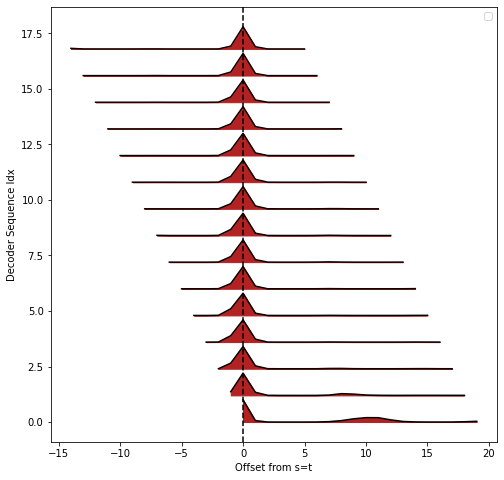

In [ ]:
avg_dot_vals = np.mean(trial_dot_vals, axis=0)
end_pad = 0
avg_softmax_vals = np.zeros((dec_len, enc_len - end_pad))
for seq_idx in range(dec_len):
  if end_pad > 0:
    avg_softmax = softmax(avg_dot_vals[seq_idx,:-end_pad])
  else:
    avg_softmax = softmax(avg_dot_vals[seq_idx,:])
  # Normalizes dot product between 0 and 1
  avg_softmax_vals[seq_idx, :] = (avg_softmax - np.min(avg_softmax))/(np.max(avg_softmax)-np.min(avg_softmax))
  # avg_softmax_vals[seq_idx, :] = avg_softmax

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Generate line plots
max_seq_idx = 15
y_spacing = 1.2

lines = []
for seq_idx in range(max_seq_idx):
  # Same for linewidth (thicker strokes on bottom)
  lw = 1.5 - seq_idx / 100.0
  # line, = ax1.plot([i-seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='k', lw=lw)
  # ax1.fill_between([i-seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx, y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='grey')
  line, = ax1.plot([i - seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='k', lw=lw)
  ax1.fill_between([i - seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx, y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='firebrick')

  lines.append(line)

ax1.axvline(0.0, color='k', linestyle='dashed')
ax1.set_ylabel('Decoder Sequence Idx')
ax1.set_xlabel('Offset from s=t')
ax1.legend()
# ax1.set_xlim([-8, 8])

In [ ]:
# Saves the data
if arch_type == 'AO':
  path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_toy_3words_15to20_l2is1e-3_average_dots.pickle'
elif arch_type == 'AED':
  path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aed_toy_3words_15to20_l2is1e-3_average_dots.pickle'

one_to_one_data = {}
one_to_one_data['trial_temporal_dots'] = trial_dot_vals
one_to_one_data['enc_len'] = enc_len
one_to_one_data['dec_len'] = dec_len
one_to_one_data['dot_keys'] = dot_keys
one_to_one_data['trial_dot_ratios'] = trial_dot_ratios
one_to_one_data['trial_temp_var_ratios'] = trial_temp_var_ratios

with open(path, 'wb') as save_file:
  pickle.dump(one_to_one_data, save_file, protocol=pickle.HIGHEST_PROTOCOL)


#### All

[Text(0, 0, 'AED toy'),
 Text(0, 0, 'AO toy'),
 Text(0, 0, 'AED eSCAN'),
 Text(0, 0, 'AO eSCAN')]

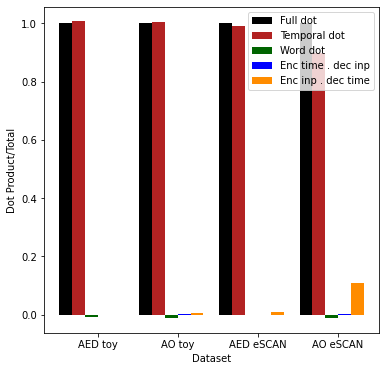

In [ ]:
# Percent of align data

# Order: Full dot, Temporal dot, Word dot, Enc time, Enc inp . dec time

aed_toy = [17.136137, 17.252214171335726, -0.11447536165135996, -0.005080152443500323, 0.003479022181664587]
ao_toy = [4.930403, 4.946632281094619, -0.05054207291767007, 0.002306375885632655, 0.03200617653480895]
ao_scan = [5.3862123, 4.843179396405194, -0.06289350489387595, 0.017220188715708212, 0.5887065548376492]
aed_scan = [23.908497, 23.7026692102443, -0.03883832767405657, -0.005785419624739229, 0.250452163056647]
datasets = [aed_toy, ao_toy, aed_scan, ao_scan]

full_dots = np.zeros((len(datasets)))
temp_dots = np.zeros((len(datasets)))
word_dots = np.zeros((len(datasets)))
enc_t_dec_i = np.zeros((len(datasets)))
enc_i_dec_t = np.zeros((len(datasets)))
for dot_vals, idx in zip(datasets, range(len(datasets))):
  full_dots[idx] = dot_vals[0]
  temp_dots[idx] = dot_vals[1]
  word_dots[idx] = dot_vals[2]
  enc_t_dec_i[idx] = dot_vals[3]
  enc_i_dec_t[idx] = dot_vals[4]

fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
labels = ['Full dot', 'Temporal dot', 'Word dot', 'Enc time . dec inp', 'Enc inp . dec time']

ax1.bar([i for i in range(len(datasets))], full_dots/full_dots, width=0.16, color='k',  label=labels[0])
ax1.bar([i+0.16 for i in range(len(datasets))], temp_dots/full_dots, width=0.16, color=state_colors[0], label=labels[1])
ax1.bar([i+0.32 for i in range(len(datasets))], word_dots/full_dots, width=0.16, color=state_colors[1], label=labels[2])
ax1.bar([i+0.48 for i in range(len(datasets))], enc_t_dec_i/full_dots, width=0.16, color=state_colors[2], label=labels[3])
ax1.bar([i+0.64 for i in range(len(datasets))], enc_i_dec_t/full_dots, width=0.16, color=state_colors[3], label=labels[4])
ax1.set_ylabel('Dot Product/Total')
ax1.set_xlabel('Dataset')
ax1.legend()

ax1.set_xticks([i+0.4 for i in range(len(datasets))])
ax1.set_xticklabels(['AED toy', 'AO toy', 'AED eSCAN', 'AO eSCAN'])

### Find Fixed Points

In [ ]:
add_noise = True
noise_scale = 0.5
cell_type = 'enc'

word = '<pad>' # 'I0'
if word == None:
  word_tensor = 1/rnn_specs['input_size']*jnp.ones(rnn_specs['input_size'])
elif cell_type == 'enc':
  word_tensor = wordToTensor(word, toy_params['in_words'])[0]
elif cell_type == 'dec':
  word_tensor = wordToTensor(word, toy_params['out_words'])[0]

xstar = np.repeat(word_tensor[np.newaxis, :], pts[pts_subset].shape[0], axis=0)

if add_noise:
  seed_pts = pts[pts_subset] + np.random.normal(loc=0.0, scale=noise_scale, size=pts[pts_subset].shape)
else:
  seed_pts = pts[pts_subset]

if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  if cell_type == 'dec':
    print('Decoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell_dec, rnn_params_dec)
  elif cell_type == 'enc':
    print('Encoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
  if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # add zeros to hidden state
    null_hs = np.zeros(pts[pts_subset].shape)
    seed_pts = np.concatenate((seed_pts, null_hs), axis=1)
else:
  fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
xstar = jnp.asarray(xstar)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, seed_pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2)
print('Done')

if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  fixed_points = fixed_points[:, :rnn_specs['hidden_size']]

pca_fixed_points = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fixed_points.fit_transform(fixed_points)
print('Fixed Points PR:', participation_ratio_vector(pca_fixed_points.explained_variance_ratio_))
print('% Var Exp:', pca_fixed_points.explained_variance_ratio_[:5])

Encoder fixed points.
Done
Fixed Points PR: 1.0157657504933155
% Var Exp: [9.9219364e-01 5.1310076e-03 2.0770244e-03 3.1081797e-04 1.2073886e-04]


Text(0, 0.5, 'PC5')

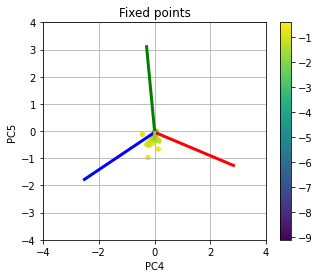

In [ ]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 4
pc2 = 5

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
# pca_fps = pca.transform(np.vstack(hs_grid_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')


plt_lim = 4
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)
plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))

x 1.0
y 1.0
x.y 7.4505806e-08


Text(0, 0.5, 'RO vec space2')

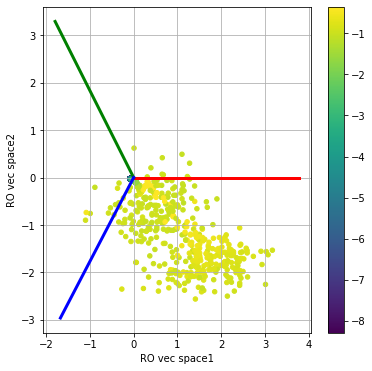

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

if rnn_specs['arch'] in ['enc_dec_atth']:
  h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)
else:
  h0_x_val = np.dot(np.matmul(h0, proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0, proj), y_basis)


fps_x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
fps_y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(fps_x_vals, fps_y_vals, s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()
plt.colorbar()

ro_colors = ['r', 'g', 'b', 'y', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

# plt.xlim(-7, 7)
# plt.ylim(-7, 7)